# Analysis

In [ ]:
#| default_exp analysis

Suite of tools and metrics to analyze models performance on specific aspects.

In [ ]:
!ls ../../../data/analysis

step_noise7to20nmtraining_pred_proteins.npz	step_pred_log.npz
step_noiselesstraining_pred_proteins.npz	step_pred_mat.npz
step_noiselessvarlentraining_pred_proteins.npz	step_pred.npz


In [ ]:
from matplotlib.colors import LogNorm

In [ ]:
#| export

def save_plot(fig, fname, fpath="../../../data/analysis/", save=1, x=None, y=None):
    """Optionally saves (1) png, (2) svg, and (3) data to reproduce the plot."""
    if save >= 1:
        fig.savefig(fpath+fname+'.png')
        if save >=2: 
            fig.savefig(fpath+fname+'.svg')
            if save >=3:# TODO generalize to dict of arrays
                assert x is not None
                assert y is not None
                np.savez_compressed(fpath+fname, x=x, y=y)

# Load dataset and model

In [ ]:
#| export
import torch
import numpy as np
from fastcore.all import *
from fastai.vision.all import *
from andi_datasets.datasets_phenom import datasets_phenom

## Multistate

In [ ]:
def get_dls(N,T,dict_all, data_path,bs,target=[0],valid_pct=0.2,shuffle=True):
    """Returns the DataLoaders with requested data and preprocessing"""
    """target 0: alpha, 1: D, 2: state, 3: CP, 4: alpha and D, ...??"""
    # from raw
    # load raw trajs and labels from phenomenological datasets
    trajs, labels = datasets_phenom().create_dataset(N_model = N, # number of trajectories per model
                                                     T = T,
                                                     dics = dict_all,
                                                     load = True, path = data_path
                                                    )  # T, N, d (3)
    #trajs  # T, N, d Numpy arrays
    #labels           # T, N, 3:[D, alpha, state]
    
    # preprocessing on memory
    if 0 in target: 
        disp = trajs[1:] - trajs[:-1]
        std  = disp.std(0, keepdims=True) # keepdim for torch
        # print(len(std), std[0], std.shape, disp.shape)
        # trajs = torch.cat((torch.zeros_like(std), (disp/std).cumsum(1)), dim=1)
        trajs = np.concatenate((np.zeros_like(std), (disp/std).cumsum(0)),axis=0)
    
    if 1 in target: labels=labels[1:] # logXResAttn predictions refer to the displacements and have length T-1.
    # TODO: problem when predicting both alpha and D if D has T-1

    # transpose time and samples dimension
    trajs = np.transpose(trajs,axes=(1,0,2))
    labels = np.transpose(labels,axes=(1,0,2))
    
    # input x, target y
    x = trajs;    y = labels[:,:,target]
    # ensure data type
    x = x.astype(np.float32);  y = y.astype(np.float32)
    # form dataset
    ds = L(zip(x, y))  # N
    # create splitting
    idx = torch.randperm(len(ds)) if shuffle else tensor(range(len(ds)))
    split_pct = valid_pct
    cut = int(len(ds)*split_pct)
    train_ds, val_ds = ds[idx[cut:]], ds[idx[:cut]]
    # cut to different lengths here? or add a batch transform???
    return DataLoaders.from_dsets(train_ds, val_ds, bs=bs, shuffle=shuffle)
    # ds = np.concatenate((labels,ds),axis=-1)

    # processing on the fly
    # tfm = ConditionalsTransform(n_labels=n_labels)
    # n_inp = 1
    # splits_idx = RandomSplitter(valid_pct=ds_args['valid_pct'], seed=ds_args['seed'])(np.arange(len(ds)))
    # tfl = TfmdLists(ds, tfm, splits=splits_idx,)  # iter
    # return tfl.dataloaders(ds_args['bs'], n_inp=n_inp, num_workers=2, pin_memory=True, drop_last=True)
    
    # from preprocessed

    # return

In [ ]:
data_path= "../../../data/raw/"

In [ ]:
!pwd

/media/scratrch_data/gfernandez/STEProids/nbs/src


In [ ]:
!ls $data_path

 2D_NVE_pbc_N256rho072T0457g1_s1e1k1m1_LJrc25rn4_dt0005ts20000_posvel.npz
 2D_NVT_Langevin_pbc_N256rho072T1g1_s1e1k1m1_LJrc25_dt00005ts2M2saveevery100burn4k_LAMMPS.npz
 2D_NVT_Langevin_pbc_N256rho072T1g1_s1e1k1m1_LJrc25_dt0005ts2M2saveevery100burn4k_LAMMPS.npz
 dataframe_traj_mat.csv
 dataframe_traj_proteins.csv
'detections connected 20221020 migration assay hela halotag mutants.csv'
'detections connected 20221110 migration assay hela halotag mutants.csv'
'detections connected 20221117 migration assay hela halotag mutants.csv'
 df.csv
 df_final_filled.csv
 Miguel_LJcut25_N2500T10M.npz
 Miguel_SHcut25_N2500T10M.npz
 multi_state_0.npy
 multi_state.csv


In [ ]:
N = 600
box_L = 200
T = 400
# state = diffusive, trapped
alphas = [1.0,       0.05]
Ds =     [10**-0.45, 10**-1.5]
M  =     np.array([[0.98, 0.02],
          [0.01, 0.99]])
dict_model_1 = dict(model ='multi_state', L = box_L, alphas = alphas, Ds = Ds, M = M)

dict_all = [dict_model_1]

In [ ]:
#dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets

In [ ]:
dls_a = get_dls(N=N, T=T, dict_all=dict_all, 
              data_path=data_path, bs=8,target=[0],
              valid_pct=0.8,shuffle=True)

In [ ]:
dls_a.one_batch()[0].shape # B, T, d

torch.Size([8, 400, 2])

In [ ]:
dls_a.one_batch()[1].shape # B, T, n_targets

torch.Size([8, 400, 1])

In [ ]:
dls_D = get_dls(N=N, T=T, dict_all=dict_all, 
              data_path=data_path, bs=8,target=[1],
              valid_pct=0.8,shuffle=True)

In [ ]:
dls_D.one_batch()[0].shape # B, T, d

torch.Size([8, 400, 2])

In [ ]:
dls_D.one_batch()[1].shape # B, T, n_targets

torch.Size([8, 399, 1])

## STdataset

In [ ]:
# from numba import njit
# from numba.np.extensions import cross2d
#@njit
def get_angle_njit(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    # patch Bug fix acos(1.000001)
    # as in The  models_phenom.confinement computation of the reflection 
    #  It can be solved by clipping like suggested here (but better use arctan2 variant):
     # https://stackoverflow.com/a/48235342 
    ang = np.arccos(np.clip(dot_product, -1, 1))
    #ang = np.rad2deg(ang) # format at convenience
    d = np.cross(vector_2,vector_1) # TODO is this necessary???
    # TODO cross2d from numba gives nan for very close or orthogonal vectors
    # https://github.com/numba/numba/blob/df07de114404225e64eea3c0622d3aee4a12e0c8/numba/np/arraymath.py#L4816
    # look at more stable, and faster implementations:
    # https://scicomp.stackexchange.com/questions/27689/numerically-stable-way-of-computing-angles-between-vectors
    # https://stackoverflow.com/questions/78118265/efficiently-calculate-angle-between-three-points-over-triplets-of-rows-in-a-nump
    # https://stackoverflow.com/questions/35176451/python-code-to-calculate-angle-between-three-point-using-their-3d-coordinates#35178910
    return ang if d < 0 else -ang

def dataset_angles_(trajs # N,T, d
                  ):
    # TODO vectorized version in time
    # vecorized in N dimension assuming all trajs have same length, faster??
    angles = [[get_angle_njit(a, b, c) for (a, b, c) in zip(traj[:-2], traj[1:-1], traj[2:]) ]
              for traj in trajs]
    if isinstance(trajs, list):            return angles
    elif isinstance(trajs, np.ndarray):    return np.array(angles)

def get_angle(from_vec, # T, d=2
              to_vec,   # T, d=2
              ):
    x1, y1 = from_vec[...,0], from_vec[...,1]
    x2, y2 = to_vec[...,0], to_vec[...,1]
    dot = x1*x2 + y1*y2      # Dot product between [x1, y1] and [x2, y2]
    det = x1*y2 - y1*x2      # Determinant (cross2d) # 2.53 micros, njit 256 ns
    return np.arctan2(det, dot)

# We want a relative description of the trajectory
# the modulus of the displacement Delta r, and the change of angle between successive displacements Delta theta 
def cartesian_to_relative_polar(trajs_cart):
    """
    Converts 2D trajectories in cartesian coordinates to 
    a relative representation of polar coordinates.
    
    Parameters:
    - cartesian_coordinates:
    A numpy array of shape (N, T, 2) where
    N is the number of trajectories,
    T is the number of time steps, and
    2 represents the x and y coordinates.
    
    Returns:
    - An array containing:
    the radius (rho) of each point, and
    the angle from previous direction (theta) of each point in radians.
    """
    # take displacements of the trajectory
    disps_cart = trajs_cart[:, 1:] - trajs_cart[:, :-1]
    # Allocate
    polar_coords = np.zeros_like(disps_cart)
    
    # Calculate the magnitude (rho) of each point
    polar_coords[...,0] = np.hypot(disps_cart[..., 0], disps_cart[..., 1])  #  dr
    
    # Calculate the angle (theta) between segments
    v1,v2 = trajs_cart[:,1:-1]-trajs_cart[:,:-2], trajs_cart[:,2:]-trajs_cart[:,1:-1]
    polar_coords[:,1:,1] = get_angle(v1,v2) # d theta
    
    return polar_coords

In [ ]:
# will be imported from steproids ---------------------------------------------
from fastai.vision.all import *
from torch.utils.data import Dataset
#| export
class STDataset(Dataset):
    """Single trajectory-centric data set in which every sample is a single trajectory.
       Made with performance in mind for in-memory (mmap otherwise) datasets with bucketing.
    """
    # load the file in memory and slice it for batches.
    # Defining batch_size_=B*T as a constant, we make batches for each index.
    # For instance, idx=0 corresponds to T=20 so take B trajs from array of lengths=20 such that B*T==batch_size_
    # idx=1 takes the next bucket from T=20 array
    # so we need to map idx to length-mini-batch pair:
    # from known number of arrays with length T and bs create an indexable of pairs(length, slice)
    # to load that contiguous part
    def __init__(self, path,
                 bs: int,
                 target: int,
                 drop_last: bool=False,
                 load_600: bool=False,
                ):
        self.target = target
        #path = path/'trajectories.npz'
        f = np.load(path[-4]+'_600.npz') if load_600 else np.load(path)
        # rest of the pipeline not implemented for 600, left for custom batch cutting of variable length
        self.trajs = f
        # number of trajectories per length
        num_trajs_len = f['num_trajs_len']  #if hasattr(f, 'num_trajs_len') else np.array([v.shape[0] for v in L(f.values())[:-2]])
        self.num_trajs_len = num_trajs_len  # debug    
        lengths = f['lengths']  # 20,21...599
        self.lengths = lengths
        size_trajs_len = num_trajs_len * lengths  # size = num_trajs*T
        
        # how many buckets of size bs are on each length
        num_buc = size_trajs_len/bs
        if drop_last:
            num_buc = np.floor (num_buc).astype(int)
        else:  # take also incomplete buckets, not empty ones
            num_buc = np.ceil  (num_buc).astype(int)
        num_buc_cum = np.cumsum(num_buc)
        self.num_buc_cum = num_buc_cum
        
        # bucket lengths: how many N trajs of length T are on each length
        bucs_len = (bs / lengths).astype(int)
        # or equally distributed bucs per length bucs_len = num_trajs_len/num_buc
        self.bucs_len = bucs_len # debug
        
        # create bucket slices
        self.bucs = L([slice(i*blen,min((i+1)*blen, trajs_L))
                     for blen,n_buc,trajs_L in zip(bucs_len,num_buc, num_trajs_len)
                     for i in range(n_buc)])
        self.size = len(self.bucs)

    def __len__(self):
        "Return the number of batches in the dataset"
        return self.size
        
    def idx2lenbuc(self, idx):
        # length from index for desired bs
        l = np.digitize(idx, self.num_buc_cum) 
    
        # compute here every time
        # num_buc_cum_0 = np.concatenate((self.num_buc_cum,[0]))
        # b_idx = idx-num_buc_cum_0[l-1]
        
        # buc = slice(b_idx*self.bucs_len[l],min((b_idx+1)*self.bucs_len[l],self.num_trajs_len[l]))
        # assert buc==self.bucs[idx], f'{idx=} {num_buc_cum_0[l-1]=} {b_idx=} {buc=} {self.bucs[idx]=}'
        
        # or take precomputed ---------v
        return self.lengths[l], self.bucs[idx]
    
    def __getitem__(self, idx):
        if idx<0: idx= self.size+idx-1
        l, buc = self.idx2lenbuc(idx)
        # finally, slice and split into inputs and targets: xb, yb
        # trajs = {'20':ndarray(N', T=20,F)}, F=x,y,alpha,D,state
        x = self.trajs[str(l)][buc,:, :2]  # x, y
        if self.target!=4: x = cartesian_to_relative_polar(x) # dr, dtheta
        if self.target==0:
            #y = self.trajs[str(l)][buc,:, 2:3] # alpha
            y = self.trajs[str(l)][buc,1:, 2:3] # alpha [1:]
        if self.target==1:
            y = self.trajs[str(l)][buc,1:, 3:4]
            # for old STEP comment the following
            # x[...,0] = np.log10(x[...,0]) # log10 dr
            x[...,0] = np.log10(np.maximum(x[...,0],1e-10)) # log10 dr
            y = np.log10(np.maximum(y,1e-10)) # log10 D [1:]
        if self.target==4: # old logStep_bm D
            y = self.trajs[str(l)][buc,1:, 3:4]
            y = np.log10(np.maximum(y,1e-10)) # log10 D [1:]
        if self.target==2: #                     state
            y = self.trajs[str(l)][buc,:,4:5].astype(int)
        if self.target==3: #                                                               cps
            y = self.trajs[str(l)][buc,1:,5:6].astype(int)
            y[:,-1] = 0 # erase last (in time dimension) cp indicating sequence length
        return x,y #batch

class STPDataset(Dataset):
    """Single trajectory predictions-centric data set in which every sample is a prediction of a single trajectory.
       Made with performance in mind for in-memory (mmap otherwise) datasets with bucketing.
    """
    # load the file in memory and slice it for batches.
    # Defining batch_size_=B*T as a constant, we make batches for each index.
    # For instance, idx=0 corresponds to T=20 so take B trajs from array of lengths=20 such that B*T==batch_size_
    # idx=1 takes the next bucket from T=20 array
    # so we need to map idx to length-mini-batch pair:
    # from known number of arrays with length T and bs create an indexable of pairs(length, slice)
    # to load that contiguous part
    def __init__(self, path_x, path_y,
                 bs: int,
                 drop_last: bool=False,
                 load_600: bool=False,
                ):
        #path = path/'trajectories.npz'
        # TODO load and process in memory with npy(flat by cat, load and cut by length)???, then access
        # now it is lazy loading the npz, on access: decompressing, transforming 
        self.x = np.load(path_x)
        f = np.load(path_y[-4]+'_600.npz') if load_600 else np.load(path_y)
        # rest of the pipeline not implemented for 600, left for custom batch cutting of variable length
        self.trajs = f
        # number of trajectories per length
        num_trajs_len = f['num_trajs_len'] # if hasattr(f, 'num_trajs_len') else np.array([v.shape[0] for v in L(f.values())[:-2]])
        self.num_trajs_len = num_trajs_len  # debug    
        lengths = f['lengths']  # 20,21...599
        self.lengths = lengths
        size_trajs_len = num_trajs_len * lengths  # size = num_trajs*T
        
        # how many buckets of size bs are on each length
        num_buc = size_trajs_len/bs
        if drop_last:
            num_buc = np.floor (num_buc).astype(int)
        else:  # take also incomplete buckets, not empty ones
            num_buc = np.ceil  (num_buc).astype(int)
        num_buc_cum = np.cumsum(num_buc)
        self.num_buc_cum = num_buc_cum
        
        # bucket lengths: how many N trajs of length T are on each length
        bucs_len = (bs / lengths).astype(int)
        # or equally distributed bucs per length bucs_len = num_trajs_len/num_buc
        self.bucs_len = bucs_len # debug
        
        # create bucket slices
        self.bucs = L([slice(i*blen,min((i+1)*blen, trajs_L))
                     for blen,n_buc,trajs_L in zip(bucs_len,num_buc, num_trajs_len)
                     for i in range(n_buc)])
        self.size = len(self.bucs)

    def __len__(self):
        "Return the number of batches in the dataset"
        return self.size
        
    def idx2lenbuc(self, idx):
        # length from index for desired bs
        l = np.digitize(idx, self.num_buc_cum) 
    
        # compute here every time
        # num_buc_cum_0 = np.concatenate((self.num_buc_cum,[0]))
        # b_idx = idx-num_buc_cum_0[l-1]
        
        # buc = slice(b_idx*self.bucs_len[l],min((b_idx+1)*self.bucs_len[l],self.num_trajs_len[l]))
        # assert buc==self.bucs[idx], f'{idx=} {num_buc_cum_0[l-1]=} {b_idx=} {buc=} {self.bucs[idx]=}'
        
        # or take precomputed ---------v
        return self.lengths[l], self.bucs[idx]
    
    def __getitem__(self, idx):
        if idx<0: idx= self.size+idx-1
        l, buc = self.idx2lenbuc(idx)
        # finally, slice and split into inputs and targets: xb, yb
        # trajs = {'20':ndarray(N', T=20,F)}, F=x,y,alpha,D,state
        #                                 x,y                         state
        #batch = self.trajs[str(l)][buc,:, :2], self.trajs[str(l)][buc,:,4:5].astype(int)
        #                                                               cps
        y = self.trajs[str(l)][buc,:,5:6].astype(int)
        y[:,-1] = 0 # erase last (in time dimension) cp indicating sequence length
        #             preds: alpha,log10D; target: cps
        batch = self.x[str(l)][buc,:, :2], y
        return batch
#| export
#https://github.com/fastai/fastai/blob/master/fastai/data/load.py#L85
class DataLoaderIndexed(DataLoader):
    def __init__(self, idxs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        store_attr()
    def get_idxs(self):
        idxs = self.idxs #Inf.count if self.indexed else Inf.nones
        #if self.n is not None: idxs = list(itertools.islice(idxs, self.n))
        if self.shuffle: idxs = self.shuffle_fn(idxs)
        return idxs
#| export
def _get_dls_from_ds(ds, split_pct=0.2, shuffle=True):
    "Returns `DataLoaders` built from `ds`."
    idx = torch.randperm(len(ds)).tolist() if shuffle else list(range(len(ds)))
    cut = int(len(ds)*split_pct)
    train_dl = DataLoaderIndexed(L(idx[cut:]),ds, shuffle=shuffle) # pin_memory=True
    # train_dl.idxs = L(idx[cut:])
    # TODO DataLoaderIndexed without ?? No, It will fail the purpose when fastai creates a new dl for get_preds
    valid_dl = DataLoaderIndexed(L(idx[:cut]),ds, shuffle=False)
    return DataLoaders(train_dl, valid_dl,)
#------------------------------------------------------------------------------
def get_dls_array(data_path, bs_, drop_last: bool=False):
    return _get_dls_from_ds(STDataset(data_path, bs_, drop_last=drop_last))
def get_dls_array_preds(preds_path, data_path, bs_, drop_last: bool=False):
    return _get_dls_from_ds(STPDataset(preds_path, data_path, bs_, drop_last=drop_last))

In [ ]:
!ls /media/scratrch_data/nanoninjas/data/raw/medium_49/track_2

exp_0	  exp_25    exp_400   exp_5501	exp_7002  exp_8504
exp_1	  exp_250   exp_4000  exp_5502	exp_7003  exp_8505
exp_10	  exp_2500  exp_4001  exp_5503	exp_7004  exp_8506
exp_100   exp_2501  exp_4002  exp_5504	exp_7005  exp_8507
exp_1000  exp_2502  exp_4003  exp_5505	exp_7006  exp_8508
exp_1001  exp_2503  exp_4004  exp_5506	exp_7007  exp_8509
exp_1002  exp_2504  exp_4005  exp_5507	exp_7008  exp_851
exp_1003  exp_2505  exp_4006  exp_5508	exp_7009  exp_8510
exp_1004  exp_2506  exp_4007  exp_5509	exp_701   exp_8511
exp_1005  exp_2507  exp_4008  exp_551	exp_7010  exp_8512
exp_1006  exp_2508  exp_4009  exp_5510	exp_7011  exp_8513
exp_1007  exp_2509  exp_401   exp_5511	exp_7012  exp_8514
exp_1008  exp_251   exp_4010  exp_5512	exp_7013  exp_8515
exp_1009  exp_2510  exp_4011  exp_5513	exp_7014  exp_8516
exp_101   exp_2511  exp_4012  exp_5514	exp_7015  exp_8517
exp_1010  exp_2512  exp_4013  exp_5515	exp_7016  exp_8518
exp_1011  exp_2513  exp_4014  exp_5516	exp_7017  exp_8519
exp_1012  exp_2514  e

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_49/track_2/trajectories.npz")

bs_=200*20
data_a = STDataset(data_path, bs_, target=0, drop_last=False)

#dl_a = DataLoader(data_a, shuffle=False, )#collate_fn=collate_fn)
dls_a = DataLoaders.from_dsets(data_a, data_a,bs=None,drop_last=False,
                               num_workers=0) # zip file is limited to be read in one process.
                                # there is a workaround if each subprocess open its own version of the file

In [ ]:
sum(dls_a.valid.dataset.num_trajs_len), sum(dls_a.valid.dataset.num_trajs_len* (dls_a.valid.dataset.lengths-1))

(375096, 58311972)

In [ ]:
len(preds_a_flat)/58311972

0.973520309002755

In [ ]:
b = dls_a.one_batch()
b[0].shape, b[1].shape # B, T, d

(torch.Size([10, 391, 2]), torch.Size([10, 391, 1]))

In [ ]:
dls_a.valid.one_batch()[1].shape # B, T, n_targets

torch.Size([200, 19, 1])

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_49/track_2/trajectories.npz")

bs_=200*20
data_cps = STDataset(data_path, bs_, target=3, drop_last=False)

dls_cps = DataLoaders.from_dsets(data_cps, data_cps,bs=None,drop_last=False,
                               num_workers=0) # zip file is limited to be read in one process.
                                # there is a workaround if each subprocess open its own version of the file

In [ ]:
dls_cps.one_batch()[0].shape # B, T, d

torch.Size([7, 515, 2])

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_49/track_2/trajectories.npz")

bs_=200*20
data_D = STDataset(data_path, bs_, target=1, drop_last=False)

#dl_D = DataLoader(data_D, shuffle=False, )#collate_fn=collate_fn)
dls_D = DataLoaders.from_dsets(data_D, data_D,bs=None,drop_last=False,
                               num_workers=0) # zip file is limited to be read in one process.
                                # there is a workaround if each subprocess open its own version of the file

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_49/track_2/trajectories.npz")

bs_=200*20
data_D_ = STDataset(data_path, bs_, target=4, drop_last=False)
dls_D_  = DataLoaders.from_dsets(data_D_, data_D_,bs=None,drop_last=False,
                               num_workers=0) # zip file is limited to be read in one process.
                                # there is a workaround if each subprocess open its own version of the file

In [ ]:
dls_D.one_batch()[0].shape # B, T, d

torch.Size([66, 59, 2])

In [ ]:
dls_D_.one_batch()[0].shape # B, T, d

torch.Size([7, 505, 2])

In [ ]:
dls_D.valid.one_batch()[1].shape # B, T, n_targets

torch.Size([200, 19, 1])

In [ ]:
dls_D.valid.dataset[0][0].shape

(200, 19, 2)

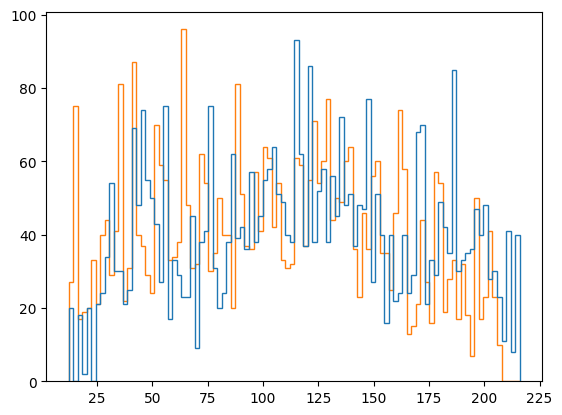

In [ ]:
plt.hist(dls_D_.valid.dataset[0][0].reshape(-1,2), 100, histtype='step');

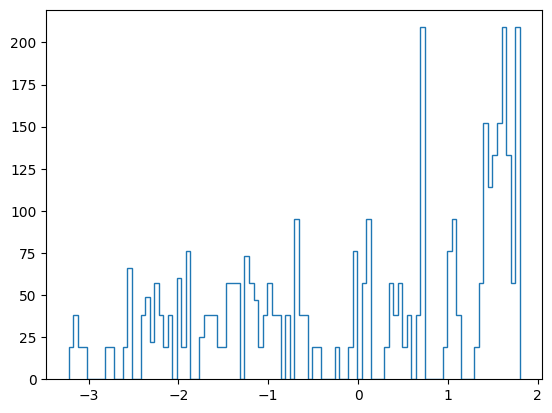

In [ ]:
plt.hist(dls_D_.valid.dataset[0][1].reshape(-1), 100, histtype='step');

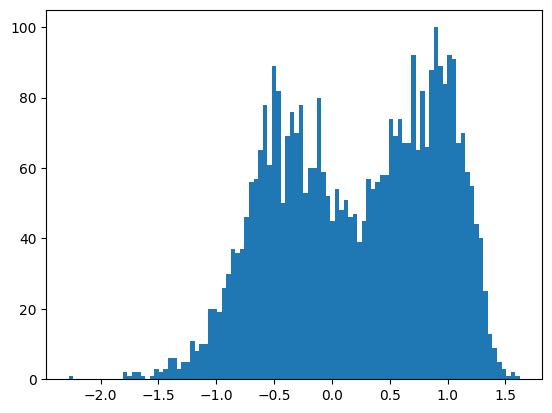

In [ ]:
plt.hist(dls_D.valid.dataset[0][0][:,:,0].reshape(-1),100);

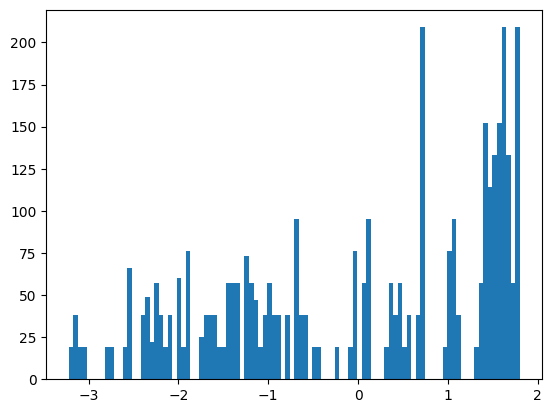

In [ ]:
plt.hist(dls_D.valid.dataset[0][1][:,:,0].reshape(-1),100);

In [ ]:
# check there are no nans in the dataset
for i,t in tenumerate(dls_D.valid.dataset):
    if np.any(np.logical_not(np.isfinite(t[0]))): print(i)
    if np.any(np.logical_not(np.isfinite(t[1]))): print(1,i)

  0%|          | 0/14949 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
f = np.load(data_path)

In [ ]:
f['20'].shape

(8616, 20, 6)

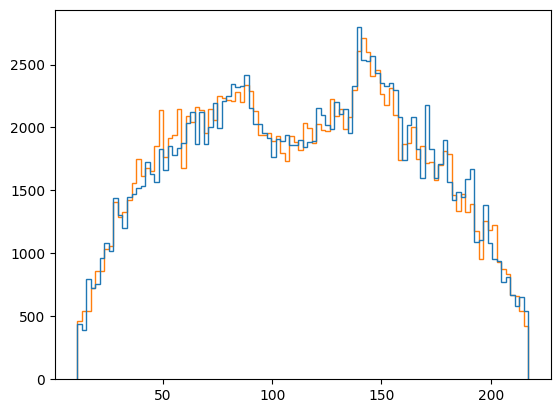

In [ ]:
plt.hist(f['20'][:,:,:2].reshape(-1,2), 100,histtype='step');

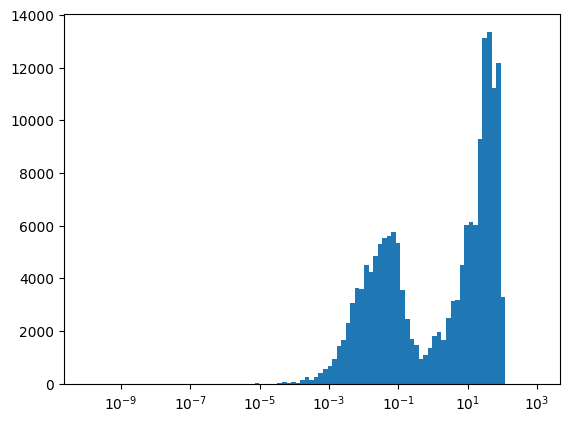

In [ ]:
plt.hist(f['20'][:,:,3].reshape(-1),np.geomspace(1e-10,1e3,100));plt.xscale('log');

In [ ]:
f['20'][:,:,3].max(), np.log10(f['20'][:,:,3].max())

(103.05935, 2.0130875)

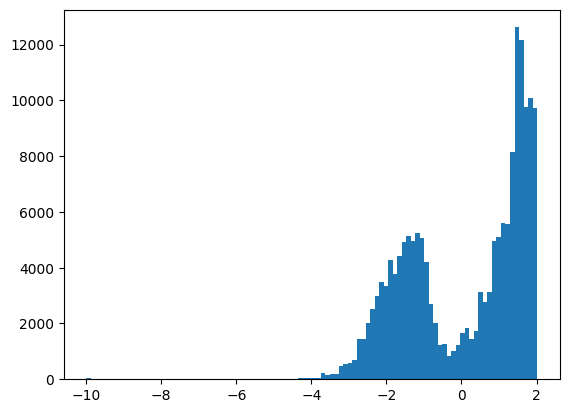

In [ ]:
plt.hist(np.log10(np.maximum(f['20'][:,:,3],1e-10)).reshape(-1),100);

In [ ]:
x_r = cartesian_to_relative_polar(f['42'][:,:,:2])

In [ ]:
x_r.max((0,1)), x_r.min((0,1))

(array([52.674084 ,  3.1415706], dtype=float32),
 array([ 8.3380594e-04, -3.1415806e+00], dtype=float32))

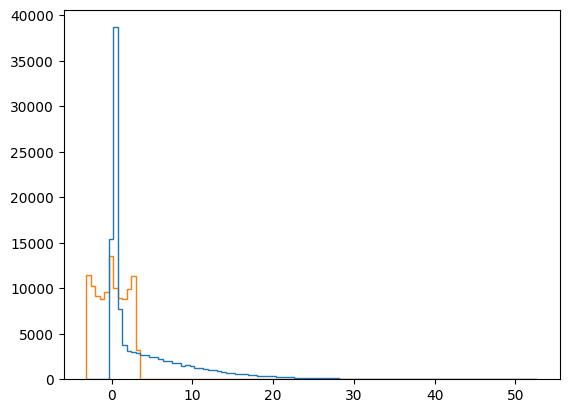

In [ ]:
plt.hist(x_r.reshape(-1,2),100, histtype='step');

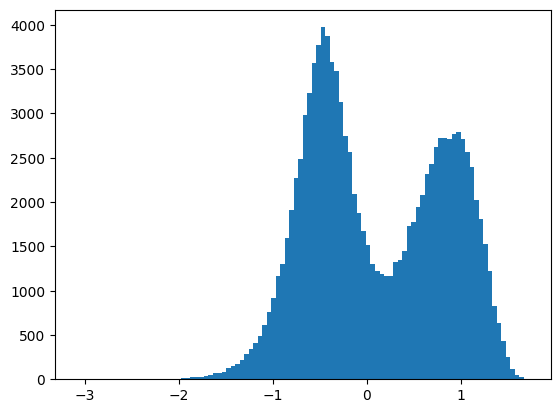

In [ ]:
plt.hist(np.log10(x_r[:,:,0]).reshape(-1),100);

In [ ]:
data_path

Path('/media/scratrch_data/nanoninjas/data/raw/medium_49/track_2/trajectories.npz')

In [ ]:
r = np.load(f'/media/scratrch_data/nanoninjas/data/raw/big/track_2/trajectories_c_L{590}.npy')

In [ ]:
r.shape

(5040, 590, 8)

In [ ]:
np.all(np.isfinite(r))

True

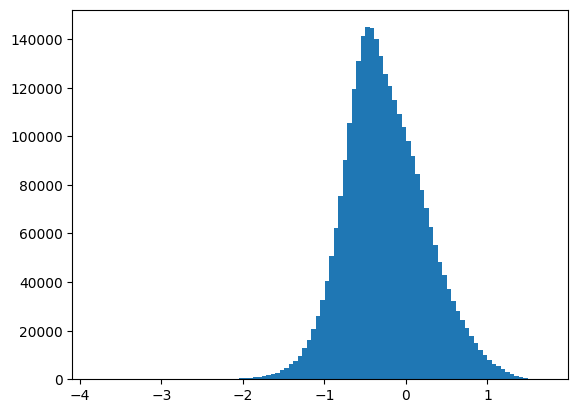

In [ ]:
plt.hist(np.log10(r[:,1:,-2]).reshape(-1),100);

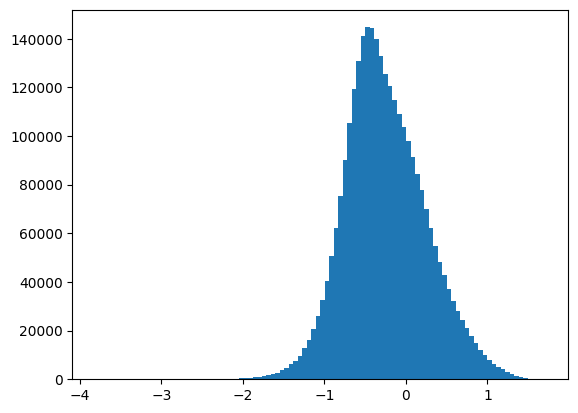

In [ ]:
plt.hist(np.log10(cartesian_to_relative_polar(r[:,:,:2])[:,1:,-2]).reshape(-1),100);

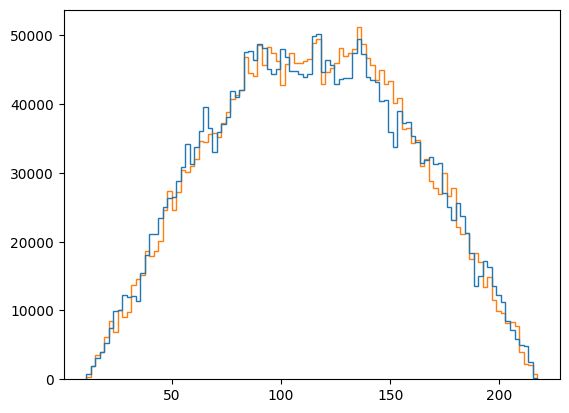

In [ ]:
plt.hist(r[:,:,:2].reshape(-1,2),100, histtype='step');

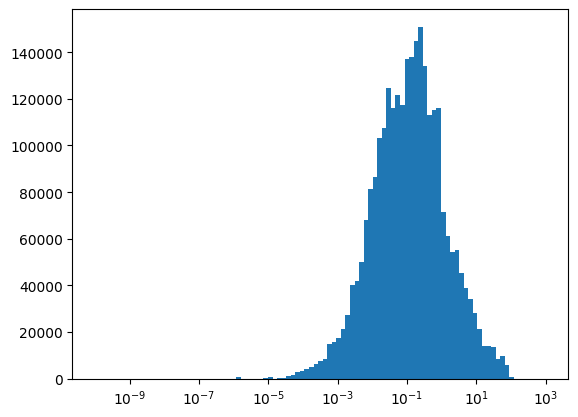

In [ ]:
plt.hist(r[:,1:,3].reshape(-1),np.geomspace(1e-10,1e3,100));plt.xscale('log');

In [ ]:
r[:,1:,3].max(), np.log10(r[:,1:,3].max())

(101.86572, 2.0080283)

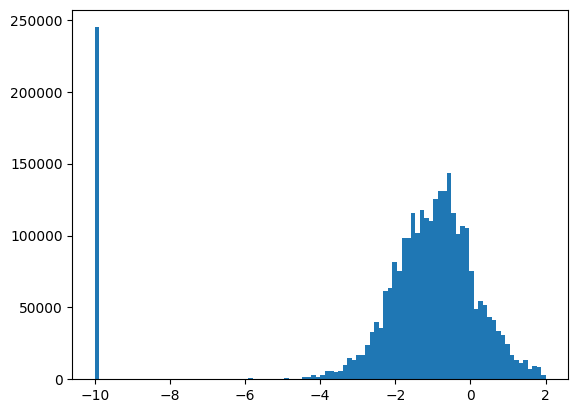

In [ ]:
plt.hist(np.log10(np.maximum(r[:,1:,3],1e-10)).reshape(-1),100);

In [ ]:
np.log10(np.maximum(x[...,0],1e-10))

## Load models

In [ ]:
from step.data import *
from step.utils import *
from step.models import *

from tqdm.auto import tqdm, trange
from fastai.vision.all import *

dim = 2

In [ ]:
from tqdm.contrib import tenumerate, tzip, tmap as tqmap

In [ ]:
MODEL_PATH

Path('/media/scratrch_data/gfernandez/STEProids/models')

In [ ]:
!pwd

/media/scratrch_data/gfernandez/STEProids/nbs/src


In [ ]:
MODEL_PATH = Path(MODEL_PATH.parent.parent/'models')

In [ ]:
MODEL_PATH, MODEL_PATH.parent, default_device()

(Path('/media/scratrch_data/gfernandez/STEProids/models'),
 Path('/media/scratrch_data/gfernandez/STEProids'),
 device(type='cuda', index=0))

In [ ]:
!ls $MODEL_PATH

xresattn_2d_varlen_relpolar_log10r_curated_01.pth
xresattn_2d_varlen_relpolar_log10r_curated_MSE.pth
xresattn_2d_varlen_relpolar_log10r_curated.pth
xresattn_2d_varlen_relpolar_log10r.pth
xresattn_2d_varlen_relpolar_log10r_yrange_m105_45_big22E2.pth
xresattn_2d_varlen_relpolar_log10r_yrange_m65_25_big17E2_colapsed.pth
xresattn_2d_varlen_relpolar_log10r_yrange_m65_25_big17E2.pth
xresattn_alpha_2d_varlen_relpolar_curated.pth
xresattn_alpha_2d_varlen_relpolar_curated_yrange_m01_21.pth
xresattn_alpha_2d_varlen_relpolar_E2.pth
xresattn_alpha_2d_varlen_relpolar.pth
xresattn_alpha_2d_varlen_relpolar_yrange_m01_21_big17E2.pth
xresattn_alpha_2d_varlen_relpolar_yrange_m01_21_big17E3.pth
xresattn_alpha_2d_varlen_relpolar_yrange_m01_21_big22E2.pth


In [ ]:
!ls ../../../models

logxresattn_bm_2d_1_to_4_cp_noisestd7to20nm.pth
logxresattn_bm_2d_1_to_4_cp.pth
logxresattn_bm_2d_1_to_5_cp_varlen_42.pth
logxresattn_bm_2d_72.pth
xresattn_bm_2d_paper.pth
xresattn_cps_2d_varlen_predalphalog10D.pth
xresattn_exp_2d_1_to_4_cp_locnoise7to20nm.pth
xresattn_exp_2d_1_to_4_cp.pth
xresattn_exp_2d_fbm_varlen.pth
xresattn_exp_2d_paper.pth
xresattn_states_2d_varlen.pth


In [ ]:
# Anomalous exponent model
with default_device():
    model_a = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                 dim_ff=512, nhead_enc=8, linear_layers=[])
    # Create the learners
    learn_a  = Learner(dls_a, model_a,  loss_func=L1LossFlat(), model_dir=MODEL_PATH)
    # load the weights
    # model_a_name = f'xresattn_exp_{dim}d_paper'
    # model_a_name = 'xresattn_exp_2d_1_to_4_cp'
    # model_a_name = 'xresattn_exp_2d_1_to_4_cp_locnoise7to20nm'
    model_a_name = 'xresattn_exp_2d_fbm_varlen'
    # model_a_name = Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_alpha_2d_varlen_relpolar.pth')
    learn_a.load(model_a_name)
    learn_a.model.eval();

In [ ]:
# Anomalous exponent model
with default_device():
    model_a = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                 dim_ff=512, nhead_enc=8, norm=False, linear_layers=[],yrange=(-0.1,2.1))
    # Create the learners
    learn_a  = Learner(dls_a, model_a,  loss_func=L1LossFlat(), model_dir=MODEL_PATH)
    # load the weights
    #model_a_name = 'xresattn_exp_2d_fbm_varlen'
    model_a_path = Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_alpha_2d_varlen_relpolar')
    # model_a_path = model_a_path.with_name('xresattn_alpha_2d_varlen_relpolar_curated')
    # model_a_path = model_a_path.with_name('xresattn_alpha_2d_varlen_relpolar_curated_yrange_m01_21')
    # model_a_path = model_a_path.with_name('xresattn_alpha_2d_varlen_relpolar_yrange_m01_21_big17E3')
    model_a_path = model_a_path.with_name('xresattn_alpha_2d_varlen_relpolar_yrange_m01_21_big22E2')
    model_a_name = model_a_path.name
    learn_a.load(model_a_path, device=default_device())
    learn_a.model.eval();

In [ ]:
# diffusion coefficient model
with default_device():
    model_log_D_ = LogXResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, 
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                 linear_layers=[], norm=False, 
                             yrange=(-4.1, #-6.1,
                                     2.1)
                            )
    learn_log_D_ = Learner(dls_D_, model_log_D_, loss_func=L1LossFlat(), model_dir='../../../models')
    # model_log_D_name = f'logxresattn_bm_{dim}d_72'
    # model_log_D_name = 'logxresattn_bm_2d_1_to_4_cp'
    # model_log_D_name = 'logxresattn_bm_2d_1_to_4_cp_noisestd7to20nm'
    model_log_D_name_ = 'logxresattn_bm_2d_1_to_5_cp_varlen_42'
    learn_log_D_.load(model_log_D_name_)
    learn_log_D_.model.eval();

In [ ]:
# diffusion coefficient model
with default_device():
    model_log_D = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, 
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                 linear_layers=[], norm=False, yrange=(-10.5,4.5))#(-6.5,2.5))#(-10.1, 2.1))
    learn_log_D = Learner(dls_D, model_log_D, loss_func=MSELossFlat(), model_dir=MODEL_PATH)
    
    model_log_D_path = Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_2d_varlen_relpolar_log10r')
    # model_log_D_path = model_log_D_path.with_name('xresattn_2d_varlen_relpolar_log10r_curated')
    # model_log_D_path = model_log_D_path.with_name('xresattn_2d_varlen_relpolar_log10r_curated_01')
    # model_log_D_path = model_log_D_path.with_name('xresattn_2d_varlen_relpolar_log10r_yrange_m65_25_big17E2')
    model_log_D_path = model_log_D_path.with_name('xresattn_2d_varlen_relpolar_log10r_yrange_m105_45_big22E2')
    
    learn_log_D.load(model_log_D_path, device=default_device())
    model_log_D_name = model_log_D_path.name
    learn_log_D.model.eval();

# Create, save, and load predictions

## Get predictions with fastai DataLoaders

## multistate

In [ ]:
preds_a, targs_a = learn_a.get_preds()

KeyboardInterrupt: 

In [ ]:
preds_D, targs_D = learn_log_D.get_preds(save_preds=None)

error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 41, in fetch
    data = next(self.dataset_iter)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/fastai/data/load.py", line 138, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/fastai/data/load.py", line 153, in do_item
    try: return self.after_item(self.create_item(s))
                                ^^^^^^^^^^^^^^^^^^^
  File "/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/fastai/data/load.py", line 160, in create_item
    if self.indexed: return self.dataset[s or 0]
                            ~~~~~~~~~~~~^^^^^^^^
  File "/tmp/ipykernel_1456524/56443561.py", line 78, in __getitem__
    x = cartesian_to_relative_polar(self.trajs[str(l)][buc,:, :2]) # dr, dtheta
                                    ~~~~~~~~~~^^^^^^^^
  File "/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/numpy/lib/npyio.py", line 253, in __getitem__
    return format.read_array(bytes,
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/numpy/lib/format.py", line 824, in read_array
    data = _read_bytes(fp, read_size, "array data")
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/numpy/lib/format.py", line 959, in _read_bytes
    r = fp.read(size - len(data))
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gfernandez/miniforge3/envs/step/lib/python3.11/zipfile.py", line 955, in read
    data = self._read1(n)
           ^^^^^^^^^^^^^^
  File "/home/gfernandez/miniforge3/envs/step/lib/python3.11/zipfile.py", line 1031, in _read1
    data = self._decompressor.decompress(data, n)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
zlib.error: Error -3 while decompressing data: invalid block type


In [ ]:
preds_a.shape, targs_a.shape, preds_D.shape, targs_D.shape

(torch.Size([480, 400, 1]),
 torch.Size([480, 400, 1]),
 torch.Size([480, 399, 1]),
 torch.Size([480, 399, 1]))

In [ ]:
preds_a = preds_a.cpu().numpy().squeeze()
targs_a = targs_a.cpu().numpy().squeeze()
preds_D = preds_D.cpu().numpy().squeeze()
targs_D = targs_D.cpu().numpy().squeeze()

In [ ]:
preds_D = 10**preds_D

In [ ]:
preds_a.shape, targs_a.shape, preds_D.shape, targs_D.shape

((480, 400), (480, 400), (480, 399), (480, 399))

ValueError: only one element tensors can be converted to Python scalars

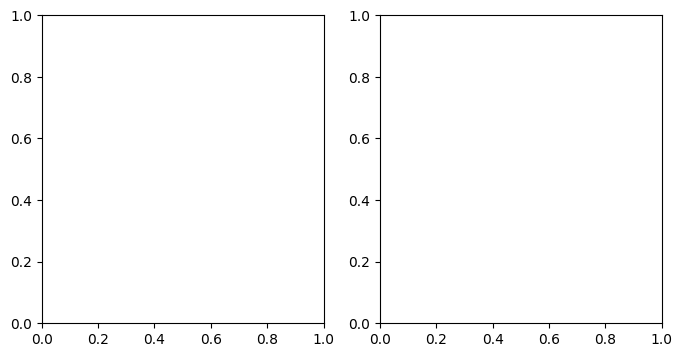

In [ ]:
i = 50
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(targs_a[i], label='target'); axs[0].plot(preds_a[i], label='pred');
axs[0].set_ylabel(r'$\alpha$', rotation=0, ha='right')
axs[1].plot(targs_D[i], label='target'); axs[1].plot(preds_D[i], label='pred');
axs[1].set_ylabel(r'$D$', rotation=0, ha='right')
for ax in axs: ax.legend();

  0%|          | 0/18 [00:00<?, ?it/s]

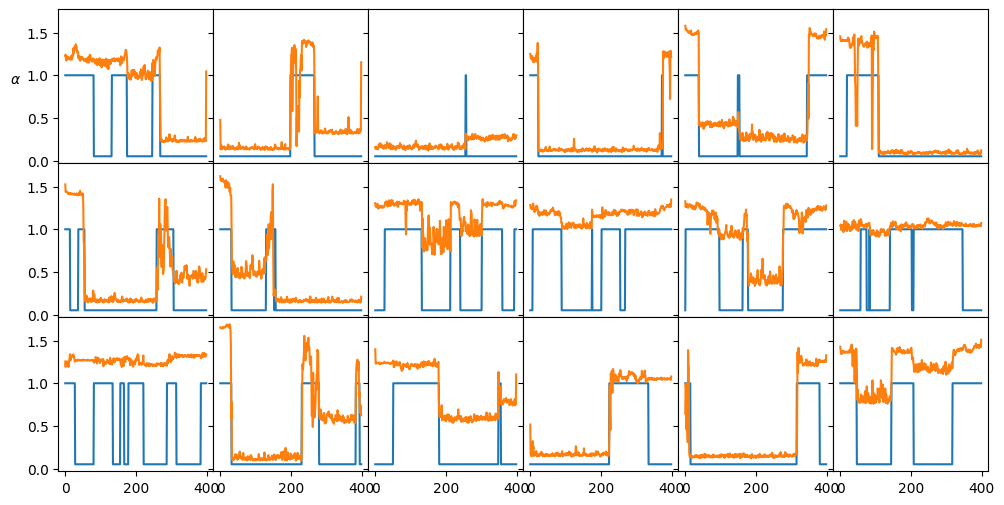

In [ ]:
n=3
fig, axs = plt.subplots(n,2*n, figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
axs = axs.flatten()
axs[0].set_ylabel(r'$\alpha$', rotation=0, ha='right')
for i, ax in tenumerate(axs):
    ax.plot(targs_a[i]);ax.plot(preds_a[i]);

  0%|          | 0/18 [00:00<?, ?it/s]

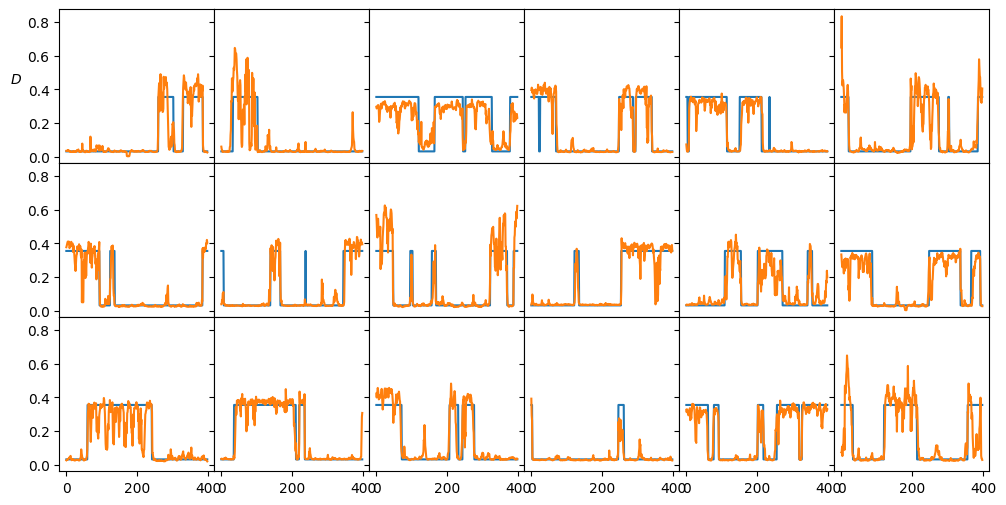

In [ ]:
n=3
fig, axs = plt.subplots(n,2*n, figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
axs = axs.flatten()
axs[0].set_ylabel(r'$D$', rotation=0, ha='right')
for i, ax in tenumerate(axs):
    ax.plot(targs_D[i]);ax.plot(preds_D[i]);

## STDataset

In [ ]:
# does not work well with STDataset # it messes up with batched preds
# preds_a, targs_a = learn_a.get_preds()

In [ ]:
preds_a = []
targs_a = []
dvc = next(learn_a.model.parameters()).device
with torch.inference_mode():
    for i,b in tenumerate(learn_a.dls.valid):
        x,y = b
        pred = to_detach(learn_a.model(x.to(dvc))).numpy()
        preds_a.append(pred)
        targs_a.append(y.numpy())

  0%|          | 0/14949 [00:00<?, ?it/s]

In [ ]:
preds_D = []
targs_D = []
dvc = next(learn_log_D.model.parameters()).device
with torch.inference_mode():
    for i,b in tenumerate(learn_log_D.dls.valid):
        x,y = b
        pred = to_detach(learn_log_D.model(x.to(dvc))).numpy()
        preds_D.append(pred)
        targs_D.append(y.numpy())

  0%|          | 0/14949 [00:00<?, ?it/s]

In [ ]:
preds_D = [10**p for p in preds_D]
targs_D = [10**p for p in targs_D]

In [ ]:
preds_D_ = []
targs_D_ = []
dvc = next(learn_log_D_.model.parameters()).device
with torch.inference_mode():
    for i,b in tenumerate(learn_log_D_.dls.valid):
        x,y = b
        pred = to_detach(learn_log_D_.model(x.to(dvc))).numpy()
        preds_D_.append(pred)
        targs_D_.append(y.numpy())

  0%|          | 0/14949 [00:00<?, ?it/s]

In [ ]:
preds_D_ = [10**p for p in preds_D_]
targs_D_ = [10**p for p in targs_D_]

In [ ]:
# preds_cps = []
targs_cps = []
# dvc = next(learn_cps.model.parameters()).device
with torch.inference_mode():
    for i,b in tenumerate(dls_cps.valid):
        x,y = b
        # pred = to_detach(learn_cps.model(x.to(dvc))).numpy()
        # preds_cps.append(pred)
        targs_cps.append(y.numpy())

  0%|          | 0/14949 [00:00<?, ?it/s]

In [ ]:
len(preds_a), preds_a[-1].shape, targs_a[-1].shape, len(preds_D), preds_D[-1].shape, targs_D[-1].shape

(14949, (6, 598, 1), (6, 598, 1), 14949, (6, 598, 1), (6, 598, 1))

In [ ]:
len(targs_cps), targs_cps[-1].shape

(14949, (6, 598, 1))

In [ ]:
preds_len = L(np.concatenate((pred_a_len, pred_d_len), axis=-1) for pred_a_len, pred_d_len in zip(preds_a, preds_D)) 

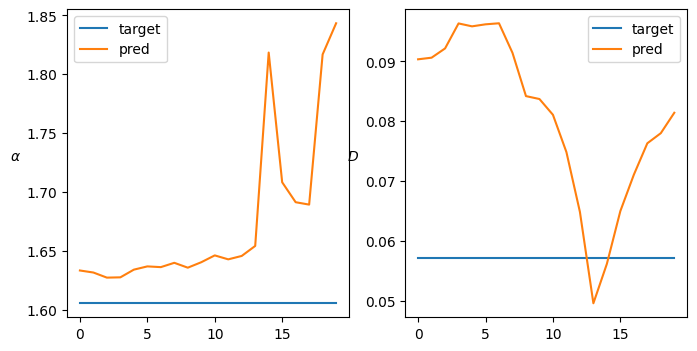

In [ ]:
i = 50
j = 0
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(targs_a[i][j], label='target'); axs[0].plot(preds_a[i][j], label='pred');
axs[0].set_ylabel(r'$\alpha$', rotation=0, ha='right')
axs[1].plot(targs_D[i][j], label='target'); axs[1].plot(preds_D[i][j], label='pred');
axs[1].set_ylabel(r'$D$', rotation=0, ha='right')
for ax in axs: ax.legend();

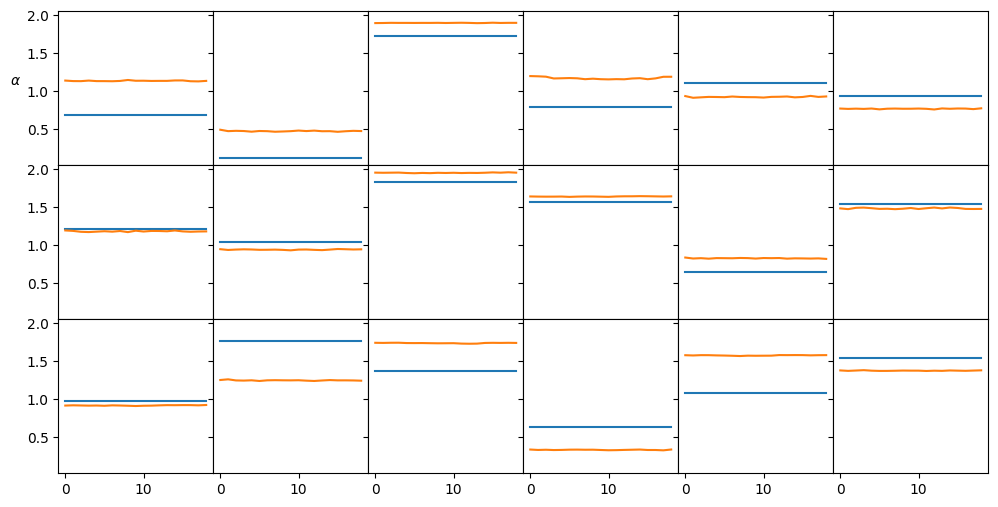

In [ ]:
n=3
fig, axs = plt.subplots(n,2*n, figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
axs = axs.flatten()
axs[0].set_ylabel(r'$\alpha$', rotation=0, ha='right')
for i, ax in enumerate(axs):
    ax.plot(targs_a[i][0]);ax.plot(preds_a[i][0]);

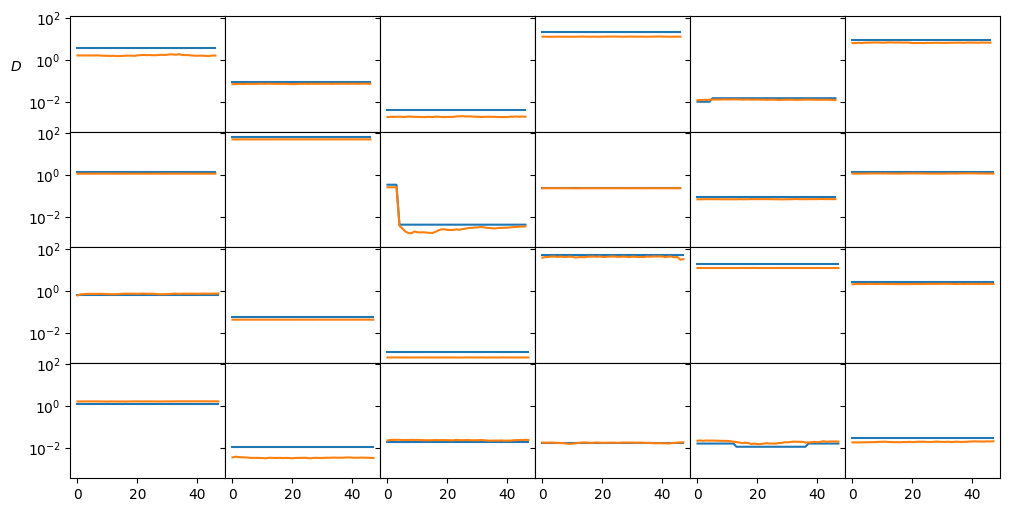

In [ ]:
n=4
fig, axs = plt.subplots(n,min(6,2*n), figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
axs = axs.flatten()
axs[0].set_ylabel(r'$D$', rotation=0, ha='right')
for i, ax in enumerate(axs):
    ax.semilogy(targs_D[i+1000][0]);ax.plot(preds_D[i+1000][0]);

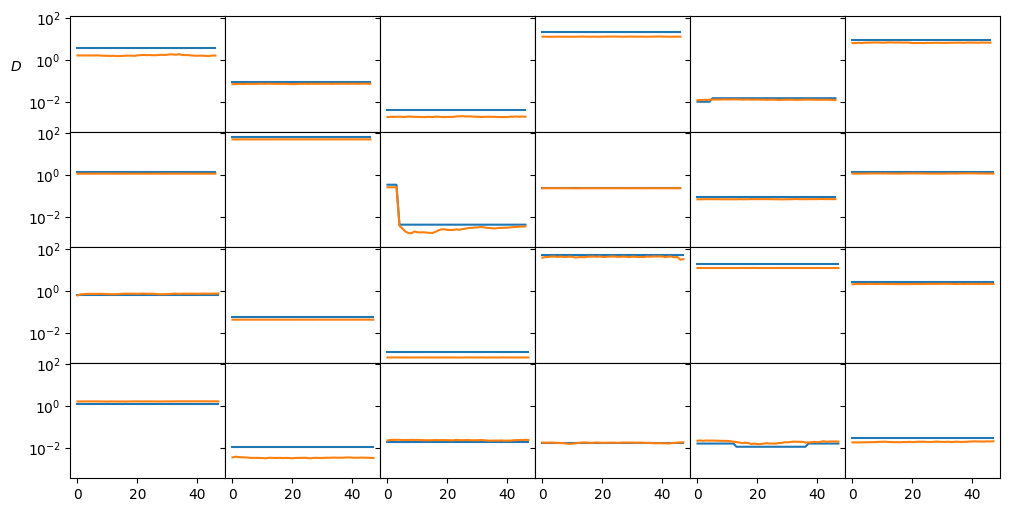

In [ ]:
n=4
fig, axs = plt.subplots(n,min(6,2*n), figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
axs = axs.flatten()
axs[0].set_ylabel(r'$D$', rotation=0, ha='right')
for i, ax in enumerate(axs):
    ax.semilogy(targs_D[i+1000][0]);ax.plot(preds_D[i+1000][0]);

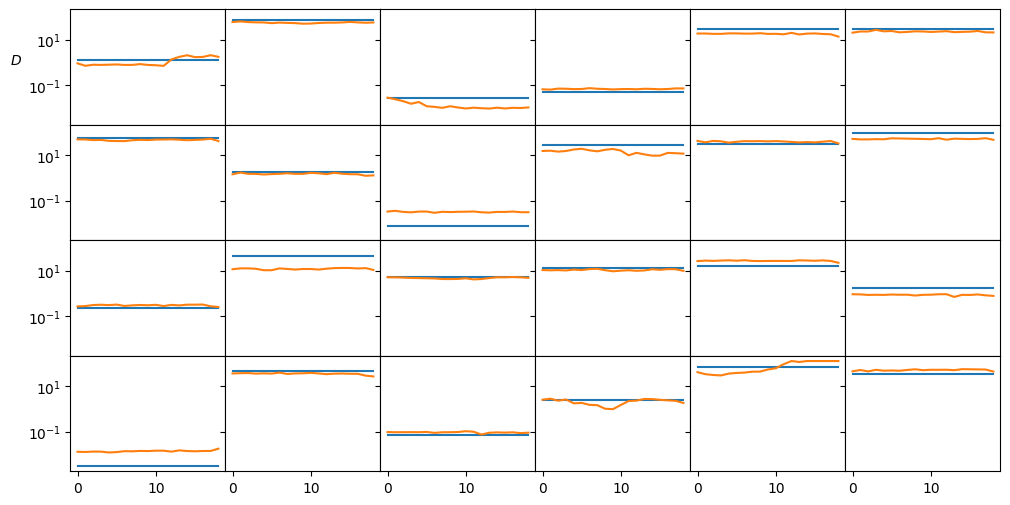

In [ ]:
n=4
fig, axs = plt.subplots(n,min(6,2*n), figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
axs = axs.flatten()
axs[0].set_ylabel(r'$D$', rotation=0, ha='right')
for i, ax in enumerate(axs):
    ax.semilogy(targs_D_[i][0]);ax.plot(preds_D_[i][0]);

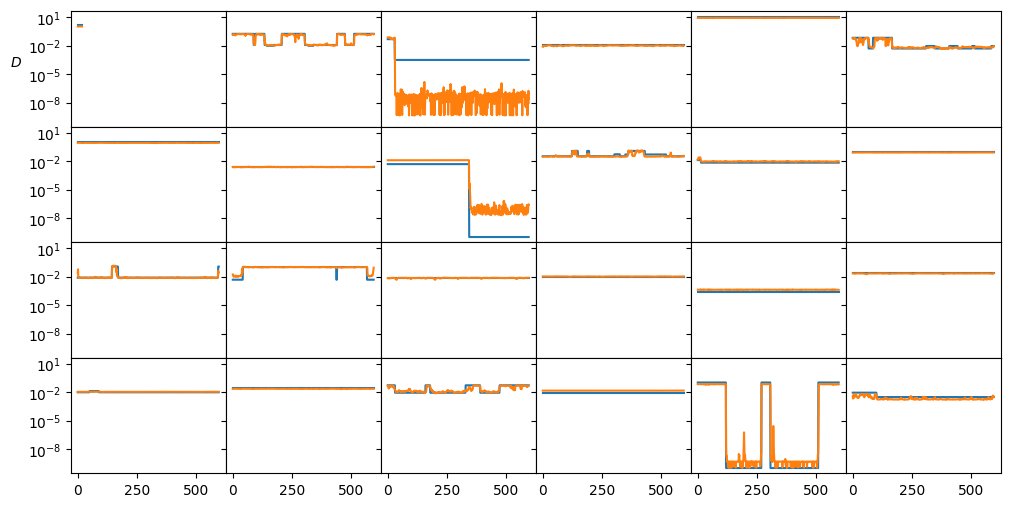

In [ ]:
n=4
fig, axs = plt.subplots(n,min(6,2*n), figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
axs = axs.flatten()
axs[0].set_ylabel(r'$D$', rotation=0, ha='right')
for i, ax in enumerate(axs):
    ax.semilogy(targs_D[-i][0]);ax.plot(preds_D[-i][0]);

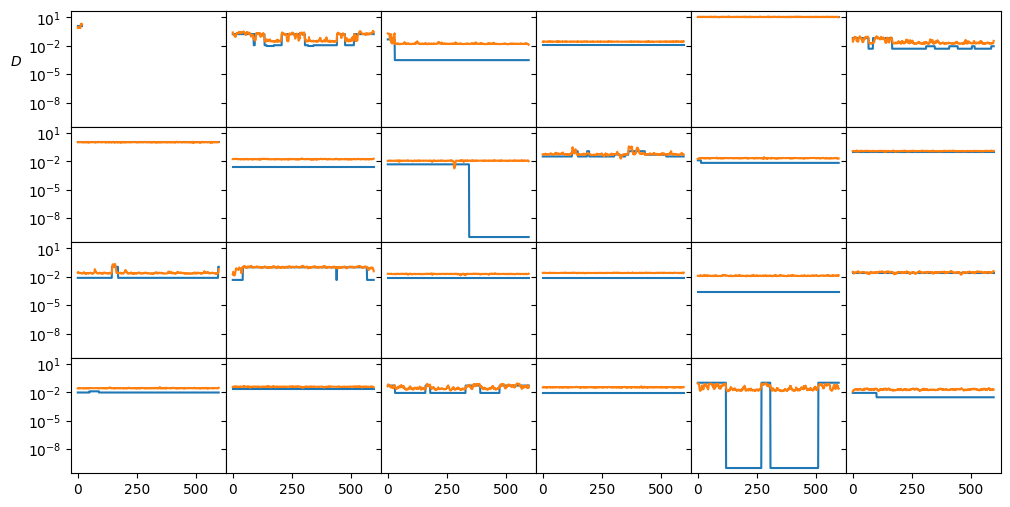

In [ ]:
n=4
fig, axs = plt.subplots(n,min(6,2*n), figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
axs = axs.flatten()
axs[0].set_ylabel(r'$D$', rotation=0, ha='right')
for i, ax in enumerate(axs):
    ax.semilogy(targs_D_[-i][0]);ax.plot(preds_D_[-i][0]);

In [ ]:
preds_a[0].flatten().shape, targs_a[0].flatten().shape

((3800,), (3800,))

In [ ]:
preds_a_flat = np.concatenate([p.flatten() for p in preds_a]).flatten()
targs_a_flat = np.concatenate([p.flatten() for p in targs_a]).flatten()

In [ ]:
preds_a_flat.shape, targs_a_flat.shape

((56767889,), (56767889,))

In [ ]:
preds_D_flat = np.concatenate([p.flatten() for p in preds_D]).flatten()
targs_D_flat = np.concatenate([t.flatten() for t in targs_D]).flatten()

In [ ]:
preds_D_flat.shape, targs_D_flat.shape

((56767889,), (56767889,))

In [ ]:
preds_D_flat_ = np.concatenate([p.flatten() for p in preds_D_]).flatten()
targs_D_flat_ = np.concatenate([t.flatten() for t in targs_D_]).flatten()

In [ ]:
preds_D_flat_.shape, targs_D_flat_.shape

((56767889,), (56767889,))

In [ ]:
# preds_cps_flat = np.concatenate([p.flatten() for p in preds_cps]).flatten()
targs_cps_flat = np.concatenate([t.flatten() for t in targs_cps]).flatten()

In [ ]:
# preds_cps_flat.shape, 
targs_cps_flat.shape[0]#-375096

56767889

In [ ]:
true_cps = [np.argwhere(t.squeeze()).squeeze(-1) +1 # because we took off the first one
                  for true_cps_len in targs_cps
                  for t in true_cps_len]

In [ ]:
true_cps_nolen = L(L(np.argwhere(t.squeeze()).squeeze(-1) +1 # because we took off the first one
                  for t in true_cps_len)
                  for true_cps_len in targs_cps)

In [ ]:
true_cps_nolen[i][0]

array([ 89,  94, 135, 144, 174, 208, 306, 320, 342, 442, 476, 514])

## Segment prediction

In [ ]:
import ruptures as rpt
# https://centre-borelli.github.io/ruptures-docs/code-reference/detection/kernelcpd-reference/#ruptures.detection.kernelcpd.KernelCPD
def find_segments(pred_a, pred_D, # T
                  pen=1, # penalty, beta
                  **kwargs):
    preds = np.stack((pred_a, pred_D), axis=-1) # T, 2
    alg = rpt.KernelCPD(**kwargs).fit(preds) # Shape (n_samples, n_features) or (n_samples,).
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    alphas, Ds = [], []
    for i, j in zip(cps[:-1], cps[1:]):
        alpha_seg, D_seg = pred_a[i+1:j-1].mean(), pred_D[i+1:j-1].mean()
        alphas.append(alpha_seg);    Ds.append(D_seg)
    #residence_time = cps[1:] - cps[:-1] # segment_length
    return alphas, Ds, cps #,residence_time

In [ ]:
import ruptures as rpt
# https://centre-borelli.github.io/ruptures-docs/code-reference/detection/kernelcpd-reference/#ruptures.detection.kernelcpd.KernelCPD
def find_segments_preds(preds, # T,2
                          pen=1, # penalty, beta
                          **kwargs):
    alg = rpt.KernelCPD(**kwargs).fit(preds) # Shape (n_samples, n_features) or (n_samples,).
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    alphas, Ds = [], []
    # TODO vectorize for preds in general
    for i, j in zip(cps[:-1], cps[1:]):
        preds_seg = preds[i+1:j-1].mean(0)
        alphas.append(alpha_seg);    Ds.append(D_seg)
    #residence_time = cps[1:] - cps[:-1] # segment_length
    return alphas, Ds, cps #,residence_time

In [ ]:
%load_ext line_profiler

In [ ]:
find_segments(preds_a[i][0].squeeze(), preds_D[i][0].squeeze(), min_size=4, pen=5, kernel="rbf")

([0.95492357,
  1.2207279,
  0.9534773,
  1.2336011,
  0.9628617,
  1.2353147,
  0.95433414,
  1.2330264,
  0.95504457],
 [0.15038085,
  0.012813694,
  0.14597245,
  0.011698023,
  0.13065837,
  0.011449517,
  0.14771743,
  0.012721012,
  0.14630243],
 array([  0,  88,  97, 135, 208, 305, 442, 476, 515, 598]))

In [ ]:
%lprun -u 1 -f find_segments find_segments(preds_a[i][0].squeeze(), preds_D[i][0].squeeze(), min_size=4, pen=5, kernel="rbf")

Timer unit: 1 s

Total time: 0.00901105 s
File: /tmp/ipykernel_2427554/1063815695.py
Function: find_segments at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def find_segments(pred_a, pred_D, # T
     4                                                             pen=1, # penalty, beta
     5                                                             **kwargs):
     6         1          0.0      0.0      1.0      preds = np.stack((pred_a, pred_D), axis=-1) # T, 2
     7         1          0.0      0.0     61.1      alg = rpt.KernelCPD(**kwargs).fit(preds) # Shape (n_samples, n_features) or (n_samples,).
     8         1          0.0      0.0     34.4      cps = np.concatenate(([0], alg.predict(pen=pen)))
     9         1          0.0      0.0      0.0      alphas, Ds = [], []
    10        10          0.0      0.0      0.2      for i, j in zip(cps[:-1], cps[1:]):
    11         9          0.0      0.0      3.2   

In [ ]:
find_segments_preds(preds_len[0][0], min_size=4, pen=5, kernel="rbf")

NameError: name 'pred_D' is not defined

In [ ]:
%lprun -u 1 -f find_segments_preds find_segments_preds(preds_len[0][0], min_size=4, pen=5, kernel="rbf")

In [ ]:
pred_a.shape, pred_d.shape

((19, 1), (19, 1))

In [ ]:
i=13_000
pred_a, pred_d = preds_a[i][0].squeeze(-1), preds_D[i][0].squeeze(-1)
a_seg, d_seg, cps = find_segments(pred_a, pred_d, min_size=4, pen=7, kernel="rbf")
# a_seg, d_seg, cps = find_segments(pred_a, pred_d, min_size=4, pen=5, kernel="linear")

cps_D = copy(cps)
cps+=1 # because we take out the first   ^ data point of the trajectory
cps[0]=0

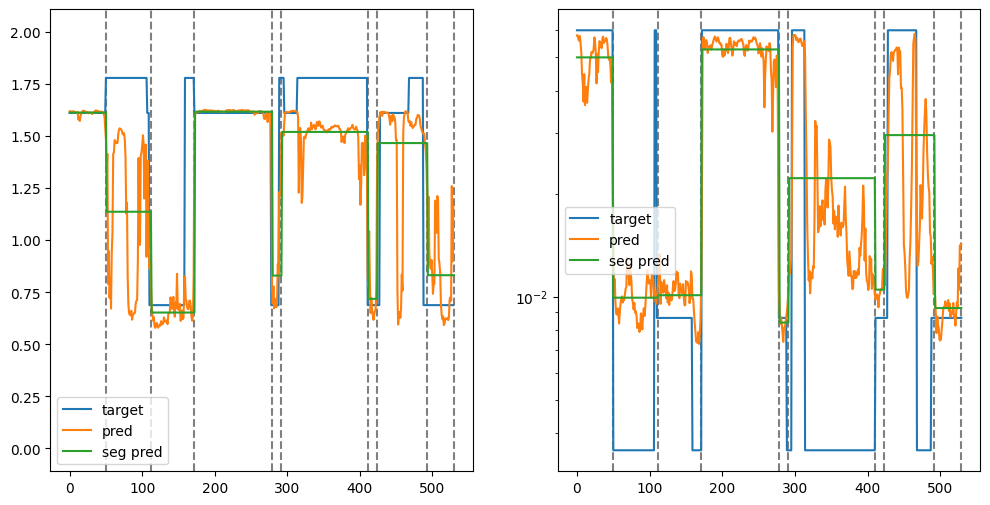

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
# cps
for cp in cps[1:]: axs[0].axvline(cp-1, ls='--', c='gray'); # minus one to start at 0
# alpha
axs[0].plot(targs_a[i][0], label='target'); axs[0].plot(pred_a, label='pred');
axs[0].plot(np.array(a_seg).repeat(cps[1:] - cps[:-1]), label='seg pred');
axs[0].set_ylim(-0.11, 2.11);
axs[0].legend();

for cp in cps_D[1:]: axs[1].axvline(cp-1, ls='--', c='gray');
# D
axs[1].plot(targs_D[i][0], label='target'); axs[1].plot(pred_d, label='pred');
axs[1].set_yscale('log');
axs[1].plot(np.array(d_seg).repeat(cps_D[1:] - cps_D[:-1]), label='seg pred');
axs[1].legend();

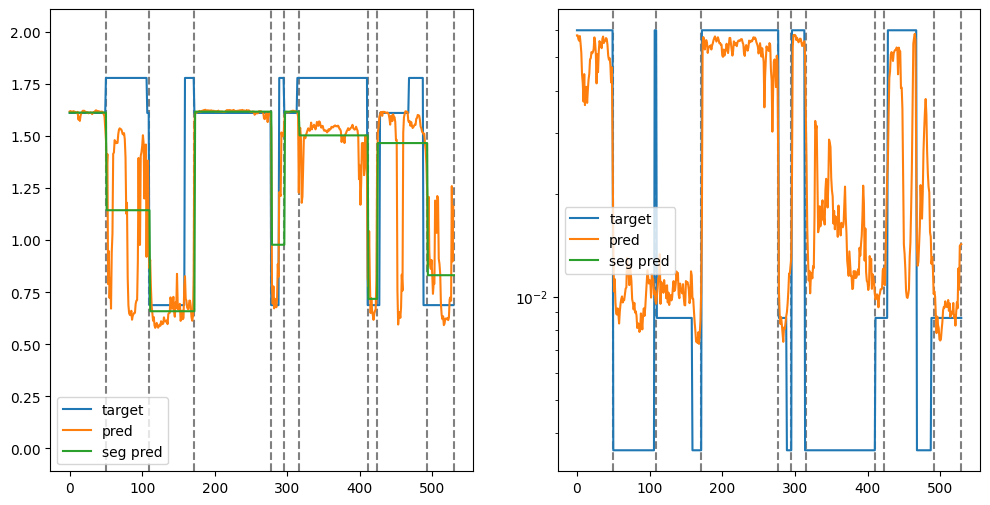

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
# cps
for cp in cps[1:]: axs[0].axvline(cp-1, ls='--', c='gray'); # minus one to start at 0
# alpha
axs[0].plot(targs_a[i][0], label='target'); axs[0].plot(pred_a, label='pred');
axs[0].plot(np.array(a_seg).repeat(cps[1:] - cps[:-1]), label='seg pred');
axs[0].set_ylim(-0.11, 2.11);
axs[0].legend();

for cp in cps_D[1:]: axs[1].axvline(cp-1, ls='--', c='gray');
# D
axs[1].plot(targs_D[i][0], label='target'); axs[1].plot(pred_d, label='pred');
axs[1].set_yscale('log');
axs[1].plot(np.array(d_seg).repeat(cps_D[1:] - cps_D[:-1]), label='seg pred');
axs[1].legend();

In [ ]:
pred_a[1:].shape, pred_d.shape

((529,), (530,))

In [ ]:
cps, len(a_seg), len(d_seg), cps[1:] - cps[:-1], sum(cps[1:] - cps[:-1])

(array([  0,  50,  81,  95, 113, 173, 280, 293, 400, 412, 425, 453, 461,
        493, 513, 531]),
 15,
 15,
 array([ 50,  31,  14,  18,  60, 107,  13, 107,  12,  13,  28,   8,  32,
         20,  18]),
 531)

In [ ]:
cps_D, cps_D[1:] - cps_D[:-1], sum(cps_D[1:] - cps_D[:-1])

(array([  0,  49,  80,  94, 112, 172, 279, 292, 399, 411, 424, 452, 460,
        492, 512, 530]),
 array([ 49,  31,  14,  18,  60, 107,  13, 107,  12,  13,  28,   8,  32,
         20,  18]),
 530)

In [ ]:
targs_a[i].shape, pred_a.shape

((7, 530, 1), (530,))

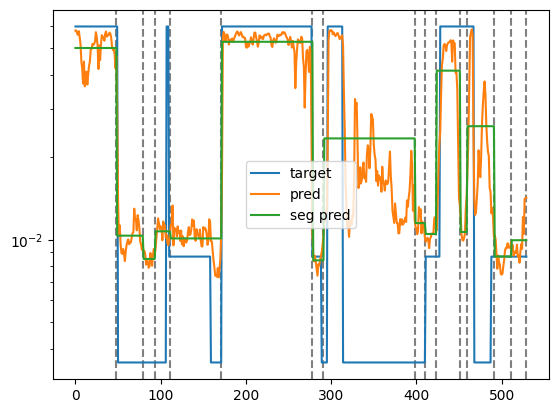

In [ ]:
# cps
for cp in cps_D[1:]: plt.axvline(cp-1, ls='--', c='gray');
# D
plt.plot(targs_D[i][0], label='target'); plt.plot(pred_d, label='pred');
plt.yscale('log');
plt.plot(np.array(d_seg).repeat(cps_D[1:] - cps_D[:-1]), label='seg pred');
plt.legend();
#plt.xlim(390,400);

In [ ]:
len(preds_a[i][0])

598

In [ ]:
print(cps[1:])
print(true_cps_nolen[i][0])

[ 50  81  95 113 173 280 293 400 412 425 453 461 493 513 531]
[ 89  94 135 144 174 208 306 320 342 442 476 514]


In [ ]:
true_cps_nolen[i][0]

array([ 89,  94, 135, 144, 174, 208, 306, 320, 342, 442, 476, 514])

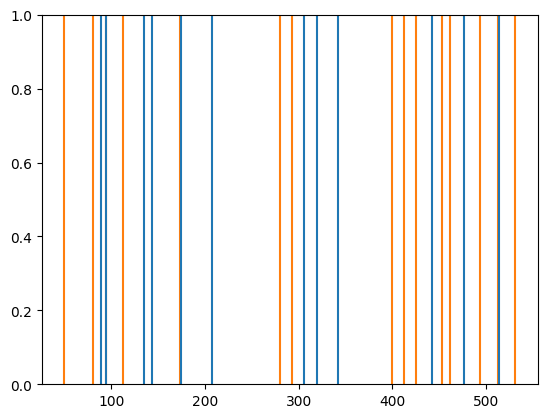

In [ ]:
# cps
for cp in cps[1:]: plt.axvline(cp, c='C1')
for cp in true_cps_nolen[i][0]: plt.axvline(cp, c='C0')

In [ ]:
preds_a.shape, preds_D.shape

((480, 400), (480, 399))

In [ ]:
seg_a, seg_D, seg_cps = list(zip(*[find_segments(pred_a[1:], pred_d, min_size=4, pen=3.5, kernel="rbf")
                                   for pred_a, pred_d in zip(preds_a, preds_D)]))

seg_cps = [cps[1:]+1 for cps in seg_cps]

In [ ]:
seg_s = [np.random.randint(0, high=4, size=len(seg)) for seg in seg_a] 

In [ ]:
pred_a.shape

(400,)

In [ ]:
targs_a[0:1].shape, targs_D[0:1].shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
from andi_datasets.utils_challenge import label_continuous_to_list
true_cps, true_a, true_D = list(zip(*[label_continuous_to_list(
                                        np.concatenate((targs_a[i,1:,None], targs_D[i,:,None]),axis=1))
                                     for i in range(len(targs_a))
                                     ]))
# print('changepoints:', true_cps,
#       '\nalphas:', true_a,
#       '\nDs:', true_D)

In [ ]:
fake_s = [np.random.randint(0, high=4, size=len(seg)) for seg in true_a] 

In [ ]:
true_cps = [cps+1 for cps in true_cps]

In [ ]:
seg_cps[0], true_cps[0]

(array([176, 261, 269, 289, 330, 387, 400]),
 array([ 81, 132, 175, 247, 261, 269, 304, 331, 387, 400]))

## Save preds

## Load preds

In [ ]:
# will be imported from steproids ---------------------------------------------
from fastai.vision.all import *
from torch.utils.data import Dataset
#| export
class STDataset(Dataset):
    """Single trajectory-centric data set in which every sample is a single trajectory.
       Made with performance in mind for in-memory (mmap otherwise) datasets with bucketing.
    """
    # load the file in memory and slice it for batches.
    # Defining batch_size_=B*T as a constant, we make batches for each index.
    # For instance, idx=0 corresponds to T=20 so take B trajs from array of lengths=20 such that B*T==batch_size_
    # idx=1 takes the next bucket from T=20 array
    # so we need to map idx to length-mini-batch pair:
    # from known number of arrays with length T and bs create an indexable of pairs(length, slice)
    # to load that contiguous part
    def __init__(self, path,
                 bs: int,
                 drop_last: bool=False,
                 load_600: bool=False,
                ):
        #path = path/'trajectories.npz'
        f = np.load(path[-4]+'_600.npz') if load_600 else np.load(path)
        # rest of the pipeline not implemented for 600, left for custom batch cutting of variable length
        self.trajs = f
        # number of trajectories per length
        num_trajs_len = f['num_trajs_len']  #if hasattr(f, 'num_trajs_len') else np.array([v.shape[0] for v in L(f.values())[:-2]])
        self.num_trajs_len = num_trajs_len  # debug    
        lengths = f['lengths']  # 20,21...599
        self.lengths = lengths
        size_trajs_len = num_trajs_len * lengths  # size = num_trajs*T
        
        # how many buckets of size bs are on each length
        num_buc = size_trajs_len/bs
        if drop_last:
            num_buc = np.floor (num_buc).astype(int)
        else:  # take also incomplete buckets, not empty ones
            num_buc = np.ceil  (num_buc).astype(int)
        num_buc_cum = np.cumsum(num_buc)
        self.num_buc_cum = num_buc_cum
        
        # bucket lengths: how many N trajs of length T are on each length
        bucs_len = (bs / lengths).astype(int)
        # or equally distributed bucs per length bucs_len = num_trajs_len/num_buc
        self.bucs_len = bucs_len # debug
        
        # create bucket slices
        self.bucs = L([slice(i*blen,min((i+1)*blen, trajs_L))
                     for blen,n_buc,trajs_L in zip(bucs_len,num_buc, num_trajs_len)
                     for i in range(n_buc)])
        self.size = len(self.bucs)

    def __len__(self):
        "Return the number of batches in the dataset"
        return self.size
        
    def idx2lenbuc(self, idx):
        # length from index for desired bs
        l = np.digitize(idx, self.num_buc_cum) 
    
        # compute here every time
        # num_buc_cum_0 = np.concatenate((self.num_buc_cum,[0]))
        # b_idx = idx-num_buc_cum_0[l-1]
        
        # buc = slice(b_idx*self.bucs_len[l],min((b_idx+1)*self.bucs_len[l],self.num_trajs_len[l]))
        # assert buc==self.bucs[idx], f'{idx=} {num_buc_cum_0[l-1]=} {b_idx=} {buc=} {self.bucs[idx]=}'
        
        # or take precomputed ---------v
        return self.lengths[l], self.bucs[idx]
    
    def __getitem__(self, idx):
        if idx<0: idx= self.n+idx-1
        l, buc = self.idx2lenbuc(idx)
        # finally, slice and split into inputs and targets: xb, yb
        # trajs = {'20':ndarray(N', T=20,F)}, F=x,y,alpha,D,state
        #                                 x,y                         state
        #batch = self.trajs[str(l)][buc,:, :2], self.trajs[str(l)][buc,:,4:5].astype(int)
        #                                                               cps
        y = self.trajs[str(l)][buc,:,5:6].astype(int)
        y[:,-1] = 0 # erase last (in time dimension) cp indicating sequence length
        batch = self.trajs[str(l)][buc,:, :2], y
        return batch

class STPDataset(Dataset):
    """Single trajectory predictions-centric data set in which every sample is a prediction of a single trajectory.
       Made with performance in mind for in-memory (mmap otherwise) datasets with bucketing.
    """
    # load the file in memory and slice it for batches.
    # Defining batch_size_=B*T as a constant, we make batches for each index.
    # For instance, idx=0 corresponds to T=20 so take B trajs from array of lengths=20 such that B*T==batch_size_
    # idx=1 takes the next bucket from T=20 array
    # so we need to map idx to length-mini-batch pair:
    # from known number of arrays with length T and bs create an indexable of pairs(length, slice)
    # to load that contiguous part
    def __init__(self, path_x, path_y,
                 bs: int,
                 drop_last: bool=False,
                 load_600: bool=False,
                ):
        #path = path/'trajectories.npz'
        self.x = np.load(path_x)
        f = np.load(path_y[-4]+'_600.npz') if load_600 else np.load(path_y)
        # rest of the pipeline not implemented for 600, left for custom batch cutting of variable length
        self.trajs = f
        # number of trajectories per length
        num_trajs_len = f['num_trajs_len'] # if hasattr(f, 'num_trajs_len') else np.array([v.shape[0] for v in L(f.values())[:-2]])
        self.num_trajs_len = num_trajs_len  # debug    
        lengths = f['lengths']  # 20,21...599
        self.lengths = lengths
        size_trajs_len = num_trajs_len * lengths  # size = num_trajs*T
        
        # how many buckets of size bs are on each length
        num_buc = size_trajs_len/bs
        if drop_last:
            num_buc = np.floor (num_buc).astype(int)
        else:  # take also incomplete buckets, not empty ones
            num_buc = np.ceil  (num_buc).astype(int)
        num_buc_cum = np.cumsum(num_buc)
        self.num_buc_cum = num_buc_cum
        
        # bucket lengths: how many N trajs of length T are on each length
        bucs_len = (bs / lengths).astype(int)
        # or equally distributed bucs per length bucs_len = num_trajs_len/num_buc
        self.bucs_len = bucs_len # debug
        
        # create bucket slices
        self.bucs = L([slice(i*blen,min((i+1)*blen, trajs_L))
                     for blen,n_buc,trajs_L in zip(bucs_len,num_buc, num_trajs_len)
                     for i in range(n_buc)])
        self.size = len(self.bucs)

    def __len__(self):
        "Return the number of batches in the dataset"
        return self.size
        
    def idx2lenbuc(self, idx):
        # length from index for desired bs
        l = np.digitize(idx, self.num_buc_cum) 
    
        # compute here every time
        # num_buc_cum_0 = np.concatenate((self.num_buc_cum,[0]))
        # b_idx = idx-num_buc_cum_0[l-1]
        
        # buc = slice(b_idx*self.bucs_len[l],min((b_idx+1)*self.bucs_len[l],self.num_trajs_len[l]))
        # assert buc==self.bucs[idx], f'{idx=} {num_buc_cum_0[l-1]=} {b_idx=} {buc=} {self.bucs[idx]=}'
        
        # or take precomputed ---------v
        return self.lengths[l], self.bucs[idx]
    
    def __getitem__(self, idx):
        if idx<0: idx= self.n+idx-1
        l, buc = self.idx2lenbuc(idx)
        # finally, slice and split into inputs and targets: xb, yb
        # trajs = {'20':ndarray(N', T=20,F)}, F=x,y,alpha,D,state
        #                                 x,y                         state
        #batch = self.trajs[str(l)][buc,:, :2], self.trajs[str(l)][buc,:,4:5].astype(int)
        #                                                               cps
        y = self.trajs[str(l)][buc,:,5:6].astype(int)
        y[:,-1] = 0 # erase last (in time dimension) cp indicating sequence length
        #             preds: alpha,log10D; target: cps
        batch = self.x[str(l)][buc,:, :2], y
        return batch
#| export
#https://github.com/fastai/fastai/blob/master/fastai/data/load.py#L85
class DataLoaderIndexed(DataLoader):
    def __init__(self, idxs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        store_attr()
    def get_idxs(self):
        idxs = self.idxs #Inf.count if self.indexed else Inf.nones
        #if self.n is not None: idxs = list(itertools.islice(idxs, self.n))
        if self.shuffle: idxs = self.shuffle_fn(idxs)
        return idxs
#| export
def _get_dls_from_ds(ds, split_pct=0.2, shuffle=True):
    "Returns `DataLoaders` built from `ds`."
    idx = torch.randperm(len(ds)).tolist() if shuffle else list(range(len(ds)))
    cut = int(len(ds)*split_pct)
    train_dl = DataLoaderIndexed(L(idx[cut:]),ds, shuffle=shuffle) # pin_memory=True
    valid_dl = DataLoaderIndexed(L(idx[:cut]),ds, shuffle=shuffle)
    return DataLoaders(train_dl, valid_dl,)
#------------------------------------------------------------------------------
def get_dls_array(data_path, bs_, drop_last: bool=False):
    return _get_dls_from_ds(STDataset(data_path, bs_, drop_last=drop_last))
def get_dls_array_preds(preds_path, data_path, bs_, drop_last: bool=False):
    return _get_dls_from_ds(STPDataset(preds_path, data_path, bs_, drop_last=drop_last))

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz")
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/trajectories.npz")

In [ ]:
idx = np.load("valid_idx.npz")['idx']

In [ ]:
idx.shape

(2108,)

In [ ]:
preds_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2/step_baby_pred.npz")
preds_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/step_medium_0_pred.npz")
bs_ = 200*20
drop_last = False
ds = STPDataset(preds_path, data_path, bs_, drop_last=drop_last)
dl = DataLoaderIndexed(idx,ds, shuffle=False)
dim = 2

In [ ]:
ds.size

10544

In [ ]:
for pred,true_cps_ in dl:
    print(pred.shape)
    break

torch.Size([12, 333, 2])


In [ ]:
preds, true_cps = L(zip(*L((pred,true_cps_) for (pred,true_cps_) in dl)))

In [ ]:
len(preds), preds[0].shape

(2108, torch.Size([12, 333, 2]))

In [ ]:
seg_a, seg_D, seg_cps = list(zip(*[find_segments(pred[:,0], pred[:,1],
                                                 min_size=4, pen=3.5, kernel="rbf")
                                   for preds_len in preds
                                   for pred in preds_len]))

In [ ]:
seg_cps = [cps[1:-1] for cps in seg_cps]

In [ ]:
len(seg_cps)

54812

In [ ]:
seg_cps[5]

array([ 14,  58, 118, 143, 165, 202, 223, 241, 301])

In [ ]:
true_cps_ = L(torch.argwhere(t.squeeze()).squeeze(-1).numpy()
              for true_cps_len in true_cps
              for t in true_cps_len)

In [ ]:
true_cps_

(#54812) [array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([221, 288, 293]),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64)...]

In [ ]:
true_cps_[5]

array([221, 288, 293])

In [ ]:
true_nolen = true_cps_

# AnDi 2 metrics on segment properties

## $\alpha$ MAE, $D$ MSLE, and Diffusive state F1

For the anomalous diffusion exponents α, we use the mean absolute error (MAE):

$MAE_{\alpha} = \frac{1}{N} \sum\limits_{\text{paired segments}}| α_{(GT), i} - α_{(P), j} |,$

where N is the total number of paired segments in the experiment, α(GT), i and α(P), j represent the ground-truth and predicted values of the anomalous exponent of paired segments, respectively.

For the generalized diffusion coefficient K, we use the mean squared logarithmic error (MSLE) defined as:

$MSLE = \frac{1}{N} \sum\limits_{\text{paired segments}} \left( \log (K_{(GT), i} + 1) - \log( K_{(P), j} + 1) \right)^2.$

For the classification of the type of diffusion, we use the F1-score:

$F_1 = \frac{2\text{TP}_\text{c}}{2\text{TP}_\text{c} + \text{FP}_\text{c} + \text{FN}_\text{c}},$

where TPc, FPc, and FNc represent true positives, false positives, and false negatives with respect to segment classification. The metric is calculated as a micro-average, which aggregates the contributions of all classes to compute the average metric and is generally preferable when class imbalance is present.
Metrics for challenge ranking

For ranking purposes, we will use the mean reciprocal rank (MRR) as a summary statistic for the overall evaluation of software performance:

$\text{MRR} = \frac{1}{N}\sum\limits_{i=1}^N \frac{1}{\text{rank}_{M_i}}.$

In [ ]:
from andi_datasets.utils_challenge import segment_property_errors

In [ ]:
#i=0
m_a, m_d, m_s = segment_property_errors(true_cps[i], true_a[i], true_D[i], fake_s[i], seg_cps[i], seg_a[i], seg_D[i], seg_s[i],)

In [ ]:
m_a, m_d, m_s

(0.34066367232137257, 0.0005181607197376329, 0.2222222222222222)

## Change points CP: JSC and RMSE

In [ ]:
from andi_datasets.utils_challenge import single_changepoint_error, ensemble_changepoint_error, changepoint_assignment

Jaccard similarity coefficient (JSC) over the whole experiment:

$JSC = \frac{TP}{TP + FN + FP}.$

That is a notion of the correct number of change points.

For the predicted CPs classified as true positives TP,
we also compute the root mean square error (RMSE), defined as:

$RMSE = \sqrt{\frac{1}{N}\sum (t_{(GT), i} - t_{(P), j})^2},$

where the sum is over the paired CP with a distance smaller than the threshold εCP.

The RMSE of the TP gives a notion of the distance from the predicted change point to the correct one.

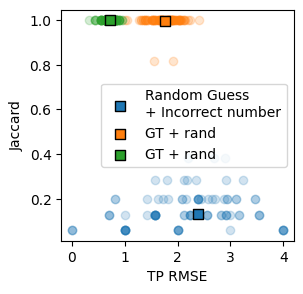

In [ ]:
labels = ['Random Guess\n+ Incorrect number', r'GT + rand ', r'GT + rand ']

fig, ax = plt.subplots(figsize = (3,3)); alpha = 0.2
T = 200; ngts = 10; npreds = 8

for case, (label, color) in enumerate(zip(labels, ['C0', 'C1', 'C2'])):
    rmse, ji = [], [];    GT, preds = [], []
    for _ in range(100):
        # take ngts changepoints
        GT.append(np.sort(np.random.choice(np.arange(1,T), ngts, replace = False)))
        if case == 0:
            # random guess
            preds.append(np.sort(np.random.choice(np.arange(1,T), npreds, replace = False)))                  
        elif case == 1:
            # GT + rand 3
            preds.append(GT[-1] + np.random.randint(-3, 3, ngts))
        elif case == 2:
            # GT + rand 1
            preds.append(GT[-1] + np.random.randint(-1, 1, ngts))

        RMSE, JI = single_changepoint_error(GT[-1], preds[-1], threshold = 5)     
        
        rmse.append(RMSE)
        ji.append(JI)

    rmse_e, ji_e = ensemble_changepoint_error(GT, preds, threshold = 5)
    
    ax.scatter(rmse, ji, c = color, alpha = alpha)
    ax.scatter(rmse_e, ji_e, c = color, label = label, s = 50, marker = 's', edgecolors = 'k')
plt.setp(ax, xlabel = 'TP RMSE', ylabel = 'Jaccard')
ax.legend();#loc = (0.91,0.4));

In [ ]:
# ensemble RMSE, JI
m_cp_r, m_cp_j = ensemble_changepoint_error(true_cps, seg_cps); m_cp_r, m_cp_j

(1.514740369185901, 0.4572045870034901)

# Anomalous exponent $\alpha$

In [ ]:
bound_alpha = [0, 1.999]
bins_a = np.linspace(0,2,200)

## Prediction distribution for fixed $\alpha$ and L

In [ ]:
preds_a_flat = preds_a.reshape(-1)
targs_a_flat = targs_a.reshape(-1)

In [ ]:
model_a_name

'xresattn_alpha_2d_varlen_relpolar_yrange_m01_21_big17E3'

In [ ]:
preds_a_flat = np.clip(preds_a_flat, 0, 1.999)

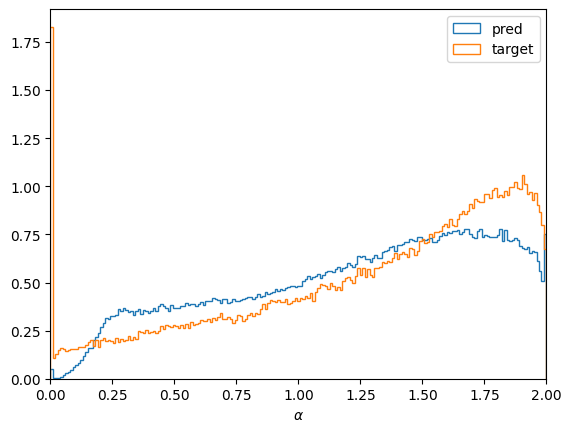

In [ ]:
h = plt.hist(preds_a_flat, bins=bins_a, histtype='step', density=True, label='pred');
plt.hist(targs_a_flat, bins=bins_a, histtype='step', density=True, label='target');

plt.xlim(0,2); plt.xlabel(r'$\alpha$'); plt.legend();
#save_plot(plt.gcf(), model_a_name+'_alphadistro_on_a0a1')
save_plot(plt.gcf(), model_a_name+'_alphadistro_on_medium_49')

In [ ]:
s = SigmoidRange(-0.1,2.1)
tar = torch.rand(10_000)*2
pre = s(tar*3.02-3.01).numpy()

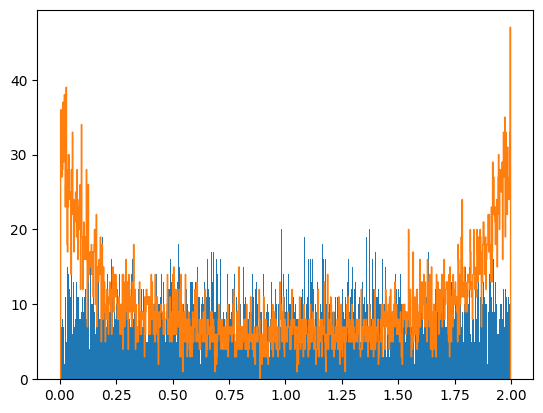

In [ ]:
plt.hist(tar.numpy(), 1000);
plt.hist(pre, 1000, histtype='step');

The range of the sogmoid should be larger to not crop border values!!
The current range introduces a cut off at alpha= 0.1, and 1.9.
The range should be like a 10% distributed in both limits: y_range=(-0.1,2.1).


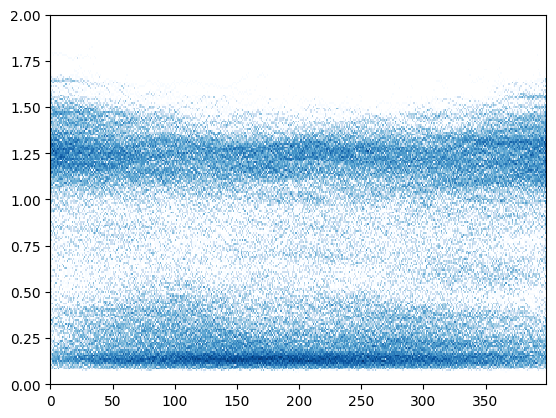

In [ ]:
plt.hist2d(np.tile(np.arange(preds_a.shape[-1]),preds_a.shape[0]),preds_a.reshape(-1),
          bins=[np.arange(preds_a.shape[-1]),bins_a], cmap='Blues', norm='log');

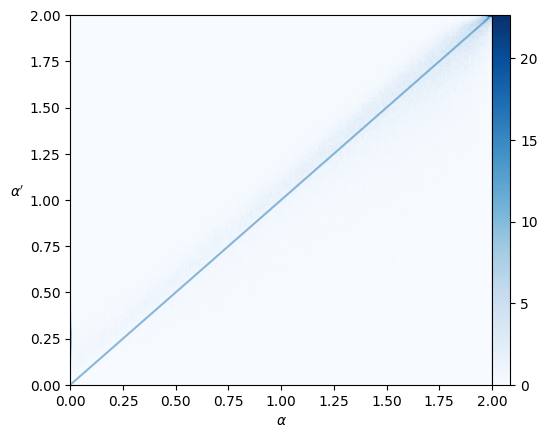

In [ ]:
plt.hist2d(targs_a_flat, preds_a_flat, bins=bins_a,
           density=True, cmap='Blues',);
plt.colorbar(pad=0)
plt.plot([0,2],[0,2], 'C0', alpha=.5);
plt.xlim(0,2); plt.xlabel(r"$\alpha$");
plt.ylabel(r"$\alpha'$", rotation=0, ha='right');
save_plot(plt.gcf(), model_a_name+'_alphapredsvstrue_on_medium_49')

In [ ]:
from matplotlib.colors import LogNorm

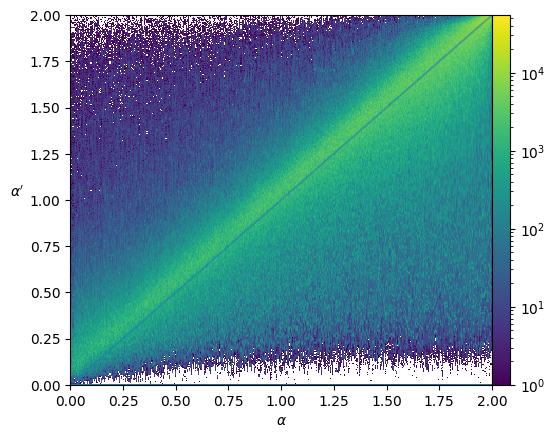

In [ ]:
bins_a = np.linspace(0,2,400)
plt.hist2d(targs_a_flat, np.clip(preds_a_flat, *bound_alpha), bins=bins_a,norm=LogNorm());
plt.colorbar(pad=0)
plt.plot([0,2],[0,2], 'C0', alpha=.5);
plt.xlim(0,2); plt.xlabel(r"$\alpha$");
plt.ylabel(r"$\alpha'$", rotation=0, ha='right');
# save_plot(plt.gcf(), model_a_name+'_alphapredsvstrue_on_medium_49')
# plt.plot(bins_a[::4][1:], preds_means);
# plt.plot(bins_a[::4][1:], preds_modes);

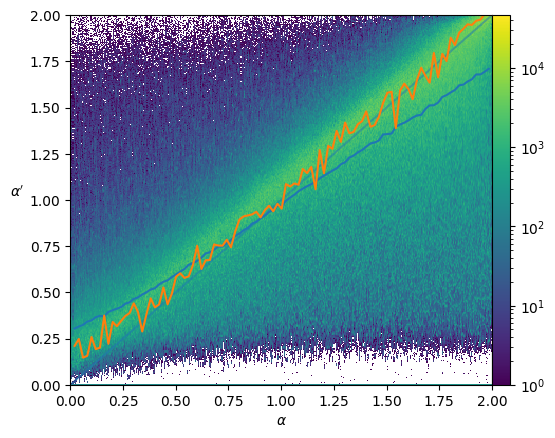

In [ ]:
bins_a = np.linspace(0,2,400)
plt.hist2d(targs_a_flat, np.clip(preds_a_flat, *bound_alpha), bins=bins_a,norm=LogNorm());
plt.colorbar(pad=0)
plt.plot([0,2],[0,2], 'C0', alpha=.5);
plt.xlim(0,2); plt.xlabel(r"$\alpha$");
plt.ylabel(r"$\alpha'$", rotation=0, ha='right');
# save_plot(plt.gcf(), model_a_name+'_alphapredsvstrue_on_medium_49')
plt.plot(bins_a[::4][1:], preds_means);
plt.plot(bins_a[::4][1:], preds_modes);

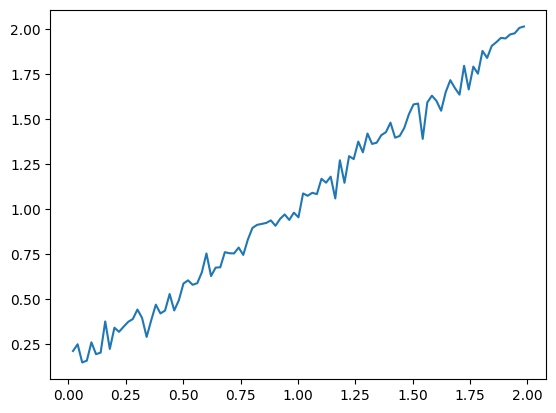

In [ ]:
plt.plot(bins_a[::4][1:], preds_modes);

In [ ]:
np.sum(np.logical_and(.28<preds_a_flat, preds_a_flat<.3))

424259

In [ ]:
from scipy import stats

0.22206037
0.13173214


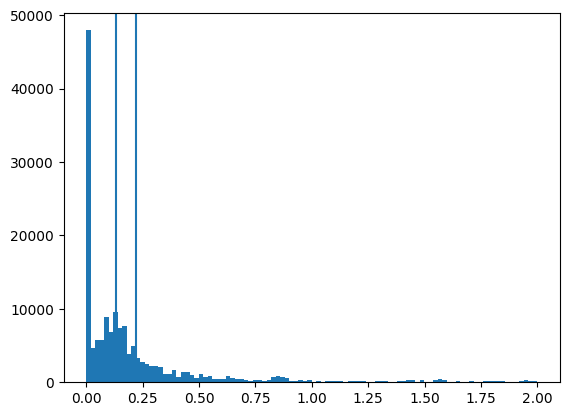

In [ ]:
targs_x = targs_a_flat[np.logical_and(.245<preds_a_flat, preds_a_flat<.255)]
plt.hist(targs_x,100);
targs_x_mean = targs_x.mean()
plt.axvline(targs_x_mean); print(targs_x_mean)
targs_x_mode = stats.mode(targs_x[targs_x>0])[0]
plt.axvline(targs_x_mode); print(targs_x_mode)

In [ ]:
bins_a = np.linspace(0,2,100)
preds_means, preds_modes = [], []
for b,b_ in zip(bins_a[:-1],bins_a[1:]):
    preds_x = preds_a_flat[np.logical_and(b<targs_a_flat, targs_a_flat<b_)]
    preds_means.append(preds_x.mean())
    preds_modes.append(stats.mode(preds_x[preds_x>0])[0])

preds_means = np.array(preds_means)
preds_modes = np.array(preds_modes)

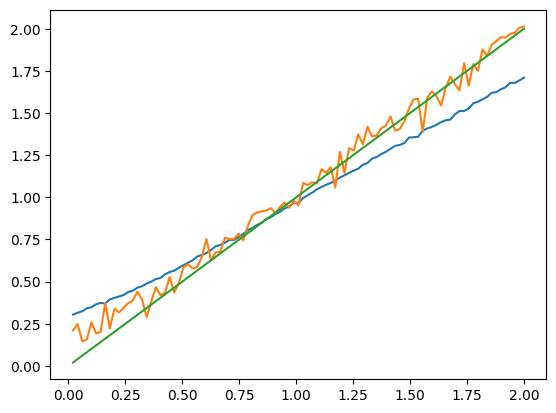

In [ ]:
plt.plot( bins_a[1:],preds_means,);
plt.plot( bins_a[1:], preds_modes,);
plt.plot( bins_a[1:], bins_a[1:]);

In [ ]:
targs_means, targs_modes = [], []
for b,b_ in zip(bins_a[:-1],bins_a[1:]):
    targs_x = targs_a_flat[np.logical_and(b<preds_a_flat, preds_a_flat<b_)]
    targs_means.append(targs_x.mean())
    targs_modes.append(stats.mode(targs_x[targs_x>0])[0])

targs_means = np.array(targs_means)
targs_modes = np.array(targs_modes)

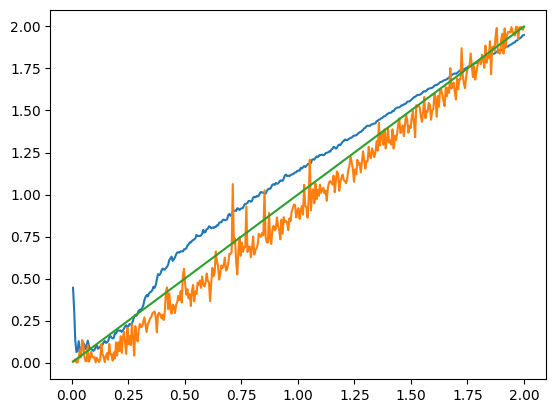

In [ ]:
plt.plot(bins_a[1:],targs_means);
plt.plot(bins_a[1:], targs_modes);
plt.plot( bins_a[1:], bins_a[1:]);

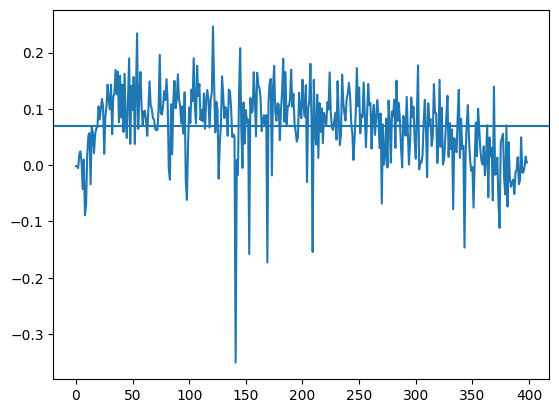

In [ ]:
plt.plot(bins_a[1:]-targs_modes);
plt.axhline((bins_a[1:]-targs_modes).mean());

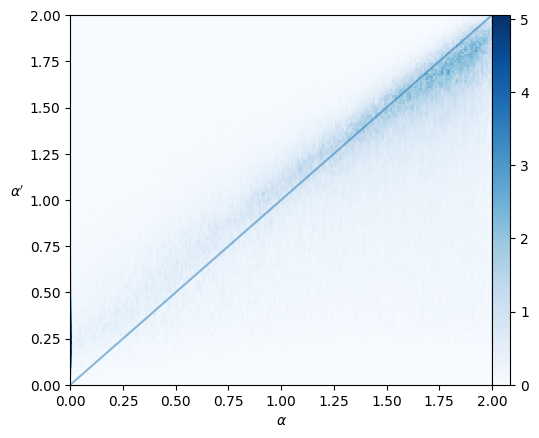

In [ ]:
plt.hist2d(targs_a_flat, preds_a_flat, bins=bins_a,
           density=True, cmap='Blues',);
plt.colorbar(pad=0)
plt.plot([0,2],[0,2], 'C0', alpha=.5);
plt.xlim(0,2); plt.xlabel(r"$\alpha$");
plt.ylabel(r"$\alpha'$", rotation=0, ha='right');

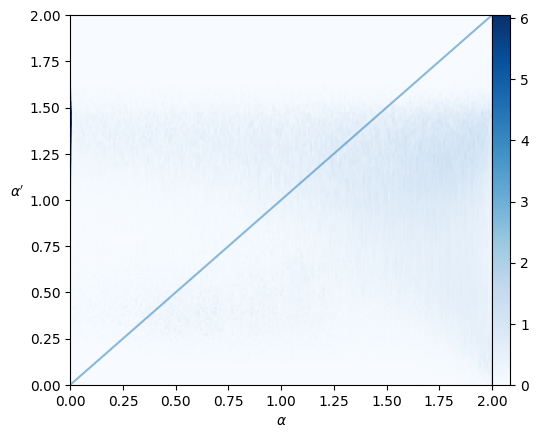

In [ ]:
plt.hist2d(targs_a_flat, preds_a_flat, bins=bins_a,
           density=True, cmap='Blues',);
plt.colorbar(pad=0)
plt.plot([0,2],[0,2], 'C0', alpha=.5);
plt.xlim(0,2); plt.xlabel(r"$\alpha$");
plt.ylabel(r"$\alpha'$", rotation=0, ha='right');

## MAE vs time

In [ ]:
# absolute error for alpha
e_a = preds_a - targs_a
ae_a = np.abs(e_a) # N, T
# mean absolute error for alpha
mae_a = ae_a.mean(0)
mae_a_mean = mae_a.mean()
mae_a_mean, ae_a.shape, mae_a.shape

(0.4089358, (480, 400), (400,))

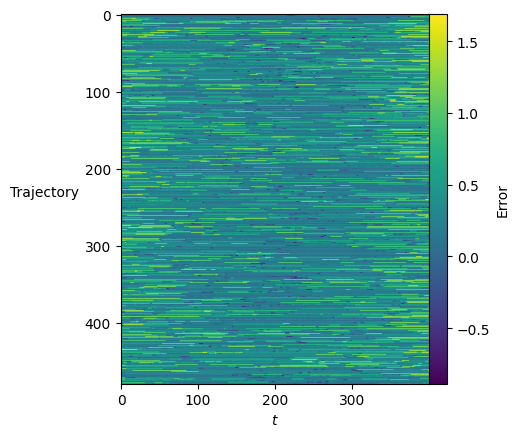

In [ ]:
plt.imshow(e_a,);# cmap='Reds',);
plt.colorbar(pad=0, label='Error');
plt.xlabel(r'$t$'); plt.ylabel('Trajectory', rotation=0, ha='right');

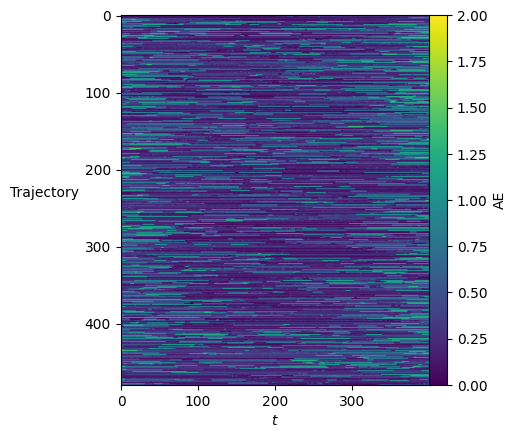

In [ ]:
plt.imshow(ae_a, vmin=0, vmax=2,);# cmap='Reds',);
plt.colorbar(pad=0, label='AE');
plt.xlabel(r'$t$'); plt.ylabel('Trajectory', rotation=0, ha='right');

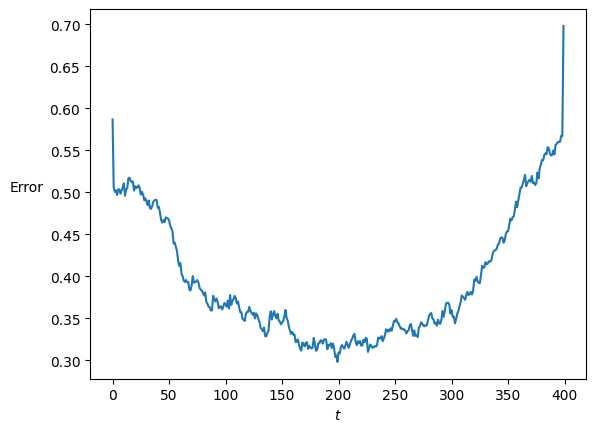

In [ ]:
plt.plot(e_a.mean(0)); plt.xlabel(r'$t$'); plt.ylabel('Error', rotation=0, ha='right');
save_plot(plt.gcf(), model_a_name+'_alpha_error_vs_t_on_L400')

There is an overestimation of $\alpha$ across all times.

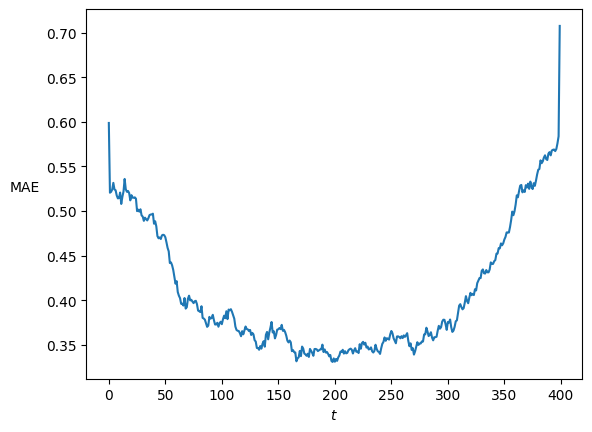

In [ ]:
plt.plot(mae_a); plt.xlabel(r'$t$'); plt.ylabel('MAE', rotation=0, ha='right');

An elevated mean absolute error in the boundaries may indicate an artifact of the padding from convolutions.

In [ ]:
lengths_buc = [p.shape[1] for p in preds_a]

lengths_buc_u = np.unique(lengths_buc)

In [ ]:
#lengths_buc_u

In [ ]:
e_a = {str(l):[] for l in lengths_buc_u}

In [ ]:
# absolute error for alpha
for l, pred, targ in zip(lengths_buc, preds_a, targs_a):
    e_a[str(l)].append(pred - targ)

In [ ]:
e_a = {k:np.concatenate(v) for k,v in e_a.items()}

In [ ]:
e_a['20'].shape

(7961, 20, 1)

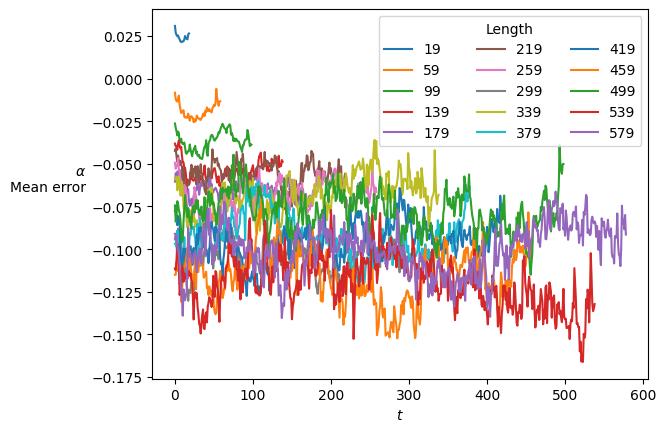

In [ ]:
for k in list(e_a.keys())[::40]:
    plt.plot(e_a[k].mean(0),label=k);
plt.legend(title='Length', ncol=3,)#bbox_to_anchor=(1,1));
plt.xlabel(r'$t$'); plt.ylabel(r'$\alpha$'+'\nMean error', rotation=0, ha='right');
save_plot(plt.gcf(), model_a_name+'_alphaerror_len_on_medium_49')

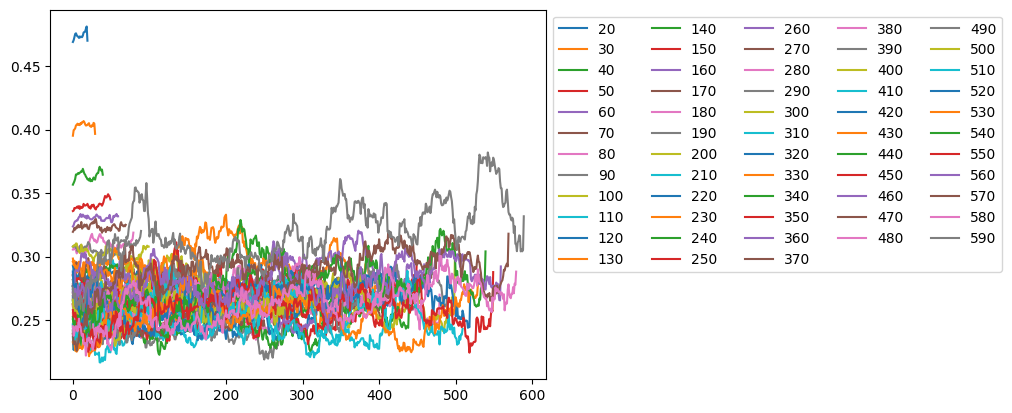

In [ ]:
for k in list(e_a.keys())[::10]:
    plt.plot(np.abs(e_a[k]).mean(0),label=k);
plt.legend(ncol=5,bbox_to_anchor=(1,1));

## MAE vs $\alpha$ for various lengths L

In [ ]:
e_a_flat = np.clip(preds_a_flat, 0.,1.999) - targs_a_flat

In [ ]:
np.abs(e_a_flat).mean()

0.17610082

In [ ]:
np.abs(np.clip(np.clip(preds_a_flat, 0.,1.999)-0.05,*bound_alpha) - targs_a_flat).mean()

0.22551304

In [ ]:
targs_a.shape, ae_a.shape

((480, 400), (480, 400))

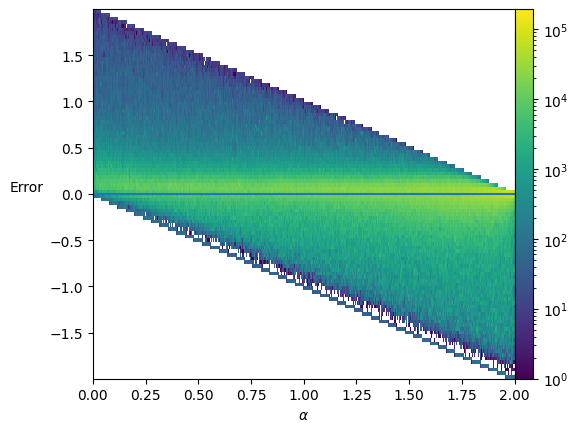

In [ ]:
plt.hist2d(targs_a_flat,e_a_flat, bins=[bins_a, 100] ,
           #density=True, 
           norm=matplotlib.colors.LogNorm());
plt.colorbar(pad=0); plt.axhline(0)
plt.xlim(0,2); plt.xlabel(r'$\alpha$');
plt.ylabel('Error', rotation=0, ha='right');

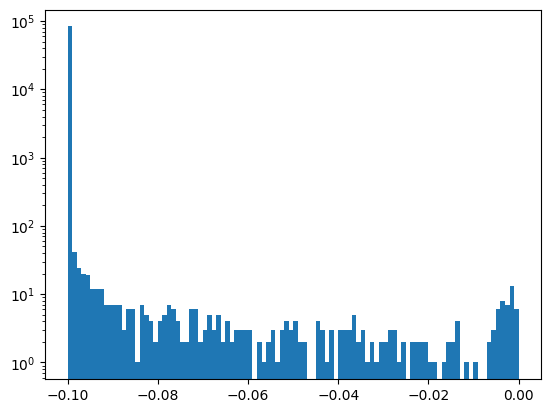

In [ ]:
plt.hist(preds_a_flat[preds_a_flat<0],100, log=True);

In [ ]:
preds_a_flat[preds_a_flat>2][0:200]

array([2.0078096, 2.007423 , 2.0073283, 2.0072384, 2.007608 , 2.0073717,
       2.0070615, 2.0073376, 2.0071418, 2.0073097, 2.0074186, 2.0074785,
       2.007107 , 2.007164 , 2.0072098, 2.0072854, 2.0071135, 2.0068712,
       2.0067205, 2.0172398, 2.017145 , 2.0169406, 2.0174508, 2.017275 ,
       2.017401 , 2.0172732, 2.0173588, 2.0172384, 2.017228 , 2.0172257,
       2.0171487, 2.016951 , 2.017007 , 2.0170531, 2.017031 , 2.0168087,
       2.016481 , 2.016458 , 2.0141988, 2.0137682, 2.0132923, 2.0132613,
       2.013296 , 2.0135908, 2.01312  , 2.0132427, 2.0130718, 2.0130773,
       2.0129535, 2.013171 , 2.0130575, 2.013326 , 2.0132413, 2.0130315,
       2.013134 , 2.0128627, 2.0125642, 2.0041678, 2.0056329, 2.0050302,
       2.0047982, 2.0057657, 2.0054193, 2.0043614, 2.004996 , 2.003088 ,
       2.011873 , 2.012429 , 2.0117176, 2.011914 , 2.0118568, 2.0120468,
       2.0122333, 2.011829 , 2.0115795, 2.0116184, 2.0113146, 2.011282 ,
       2.011637 , 2.011974 , 2.0119116, 2.011624 , 

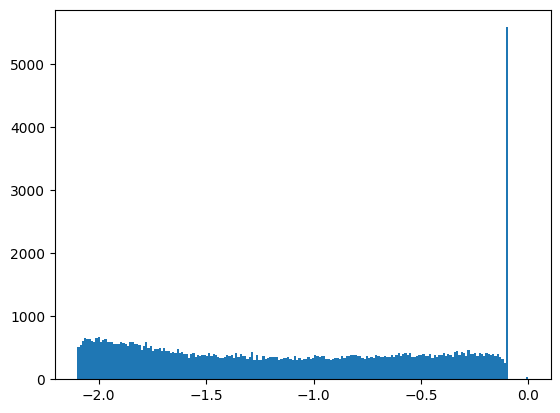

In [ ]:
plt.hist(e_a_flat[preds_a_flat<0], bins=200,);

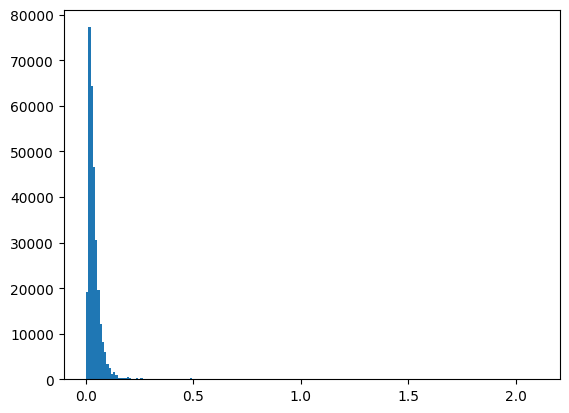

In [ ]:
plt.hist(e_a_flat[preds_a_flat>2], bins=200,);

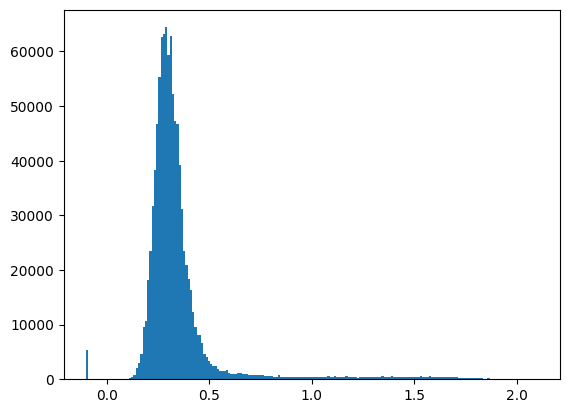

In [ ]:
plt.hist(e_a_flat[targs_a_flat==0], bins=200,);
# plt.xlim(0,2); plt.xlabel(r'$\alpha$');
# plt.ylabel('Error', rotation=0, ha='right');

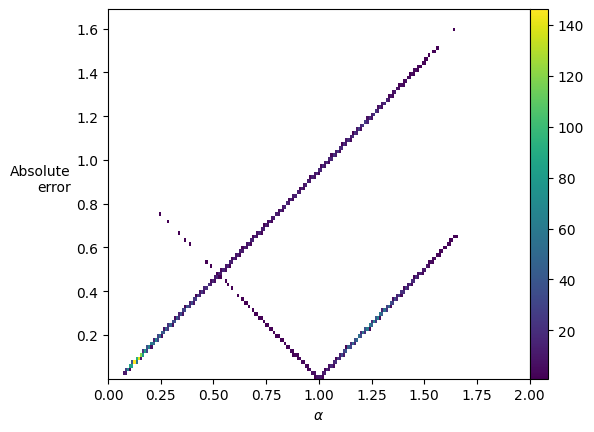

In [ ]:
plt.hist2d(preds_a.reshape(-1),ae_a.reshape(-1), bins=[bins_a, 100] ,
           density=True, cmin=1);
plt.colorbar(pad=0)
plt.xlim(0,2); plt.xlabel(r'$\alpha$');
plt.ylabel('Absolute\nerror', rotation=0, ha='right');

In [ ]:
# varying Length


## MAE vs length L for various $\alpha$

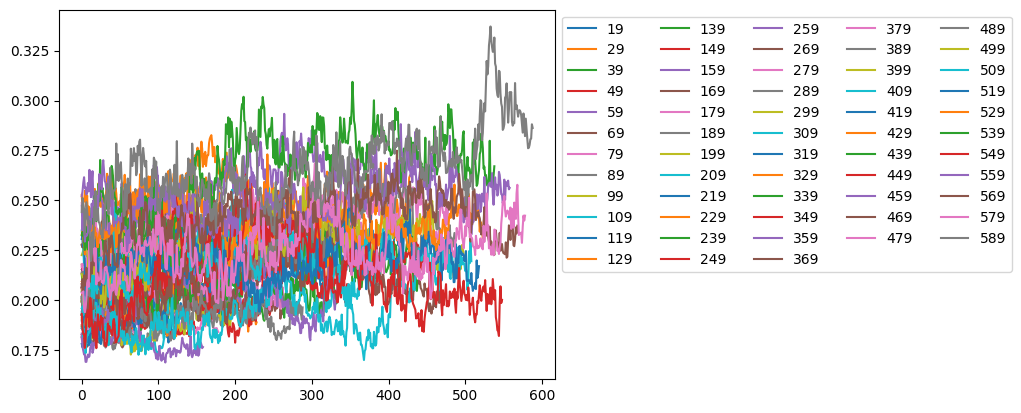

In [ ]:
for k in list(e_a.keys())[::10]:
    plt.plot(np.abs(e_a[k]).mean(0), label=k);
plt.legend(ncol=5,bbox_to_anchor=(1,1));

## Anisotropic FBM

In [ ]:
from andi_datasets.models_phenom import models_phenom
from andi_datasets.analysis import msd_analysis
import numpy as np
import matplotlib.pyplot as plt

alpha1 = 0.01; alpha2 = 1.9
trajs1 = models_phenom().single_state(N = 1000, T = 200, alphas=[alpha1, 0])[0][:,:,0]
trajs2 = models_phenom().single_state(N = 1000, T = 200, alphas=[alpha2, 0])[0][:,:,0]

#trajs1 = np.zeros_like(trajs2)
trajs = np.concatenate((trajs2[:,:,np.newaxis], trajs2[:,:,np.newaxis]), axis = -1)

In [ ]:
trajs.shape # T, N , d

(200, 1000, 2)

In [ ]:
trajs_t =  np.transpose(trajs, (1,0,2))

In [ ]:
disp = trajs_t[:,1:] - trajs_t[:,:-1] # [traj[1:] - traj[:-1] for traj in trajs]
std  = disp.std(1, keepdims=True)  # [np.expand_dims(dis.std(0),0) for dis in disp]
print(len(std), std[0], std.shape, disp.shape)
trajs_norm = np.concatenate((np.zeros_like(std), (disp/std).cumsum(1)), axis=1)
# L([torch.cat((torch.tensor(np.zeros_like(sd), dtype=torch.float),
#                           torch.tensor(dis/sd, dtype=torch.float
#                                       ).cumsum(0)), dim=0).unsqueeze(0).to(default_device())
                # for dis, sd in zip(disp, std)])
trajs_norm.shape

1000 [[0.80064679 0.80064679]] (1000, 1, 2) (1000, 199, 2)


(1000, 200, 2)

In [ ]:
trajs_norm[0]

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 6.45628468e-01,  6.45628468e-01],
       [-8.55256368e-03, -8.55256368e-03],
       [-1.18233669e+00, -1.18233669e+00],
       [-1.10018780e+00, -1.10018780e+00],
       [-1.08015226e+00, -1.08015226e+00],
       [-1.44707124e+00, -1.44707124e+00],
       [-2.14117783e+00, -2.14117783e+00],
       [-1.76802648e+00, -1.76802648e+00],
       [-1.78287751e+00, -1.78287751e+00],
       [-2.97061216e+00, -2.97061216e+00],
       [-4.90407279e+00, -4.90407279e+00],
       [-7.39834801e+00, -7.39834801e+00],
       [-7.87946312e+00, -7.87946312e+00],
       [-9.04537316e+00, -9.04537316e+00],
       [-1.01082688e+01, -1.01082688e+01],
       [-1.06245742e+01, -1.06245742e+01],
       [-9.93513866e+00, -9.93513866e+00],
       [-9.27711871e+00, -9.27711871e+00],
       [-1.00324231e+01, -1.00324231e+01],
       [-1.02053155e+01, -1.02053155e+01],
       [-9.45756647e+00, -9.45756647e+00],
       [-8.65186912e+00, -8.65186912e+00],
       [-8.

In [ ]:
with torch.no_grad():
    preds = learn_a.model(torch.tensor(trajs_norm, device='cuda', dtype=torch.float32))

In [ ]:
preds.shape

torch.Size([1000, 200, 1])

tensor(1.7993)

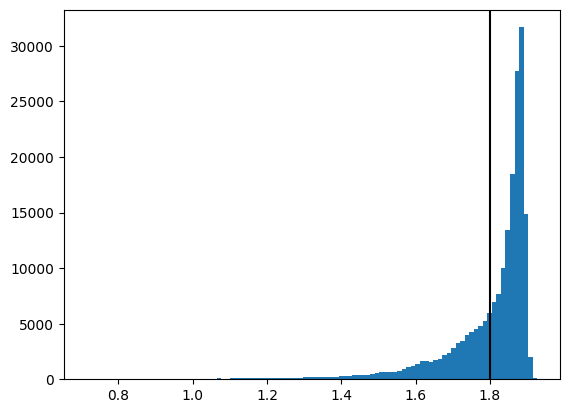

In [ ]:
plt.hist(preds.cpu().numpy().reshape(-1),100);
plt.axvline(preds.mean().cpu(), c='k');
preds.mean().cpu()

In [ ]:
def pred_varlen(model, trajs, lengths):
    with torch.no_grad():
        return [[to_detach(model(x[:,:l])).squeeze() for x in tqdm(trajs)] for l in lengths]

In [ ]:
preds_a_b =      pred_varlen(learn_exp.model, trajs_norm_b,lengths)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

# Diffusion coefficient $D$

## Prediction distribution at all times for fixed $D$ and time lengths L

In [ ]:
preds_D_flat = preds_D.reshape(-1)
targs_D_flat = targs_D.reshape(-1)

In [ ]:
bound_D = [1e-12, 1e6]
bins_D = np.geomspace(*bound_D, 180)
# bins_D = np.geomspace(1e-2,1e1, 180)
bins_D = np.geomspace(1e-6,1e3, 180)

In [ ]:
preds_D[0].shape, targs_D[0].shape

((200, 19, 1), (200, 19, 1))

In [ ]:
len(targs_D)

14949

In [ ]:
model_log_D_name, model_log_D_name_

('xresattn_2d_varlen_relpolar_log10r_yrange_m105_45_big22E2',
 'logxresattn_bm_2d_1_to_5_cp_varlen_42')

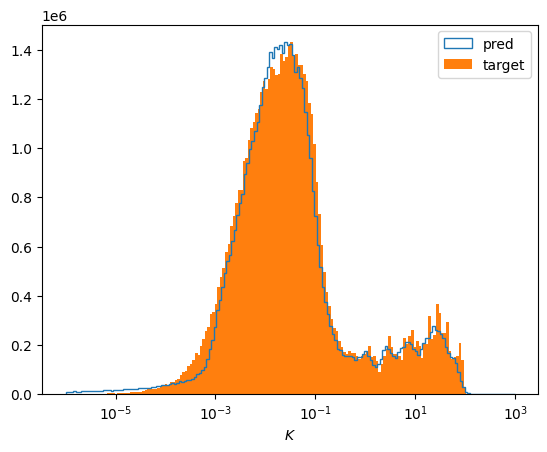

In [ ]:
h = plt.hist(preds_D_flat, bins=bins_D,
             histtype='step',label='pred');

arr_hist, edges = np.histogram(targs_D_flat,
                               bins=bins_D)
samp = arr_hist / max(arr_hist)*h[0].max()
plt.bar(edges[:-1], samp, width=np.diff(edges), label='target')

plt.xscale('log'); plt.xlabel(r'$K$'); plt.legend();
#save_plot(plt.gcf(), model_log_D_name+'_Ddistro_on_D3em2D035')
save_plot(plt.gcf(), model_log_D_name+'_Ddistro_on_medium_49')

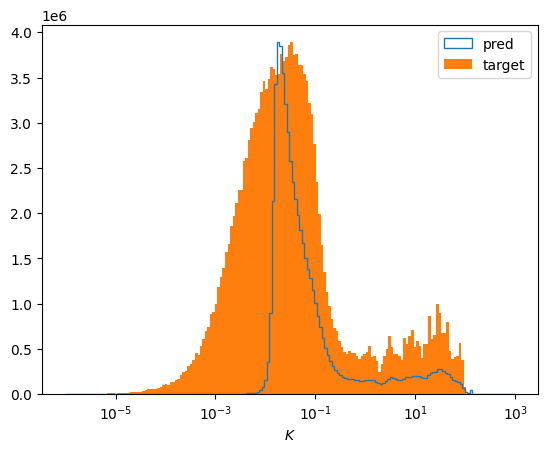

In [ ]:
h = plt.hist(preds_D_flat_, bins=bins_D,
             histtype='step',label='pred');

arr_hist, edges = np.histogram(targs_D_flat_,
                               bins=bins_D)
samp = arr_hist / max(arr_hist)*h[0].max()
plt.bar(edges[:-1], samp, width=np.diff(edges), label='target')

plt.xscale('log'); plt.xlabel(r'$K$'); plt.legend();
#save_plot(plt.gcf(), model_log_D_name+'_Ddistro_on_D3em2D035')
save_plot(plt.gcf(), model_log_D_name_+'_Ddistro_on_medium_49')

In [ ]:
# for each unique D or digitized
# u_D = np.digitize(targs_D)
u_D = np.unique(targs_D);
u_D

array([0.03162277, 0.3548134 ], dtype=float32)

In [ ]:
masks_D = []; idx_D = []
for D_ in u_D:
    masks_D.append((targs_D==D_).reshape(targs_D.shape))
    idx_D.append(np.nonzero(masks_D[-1]))

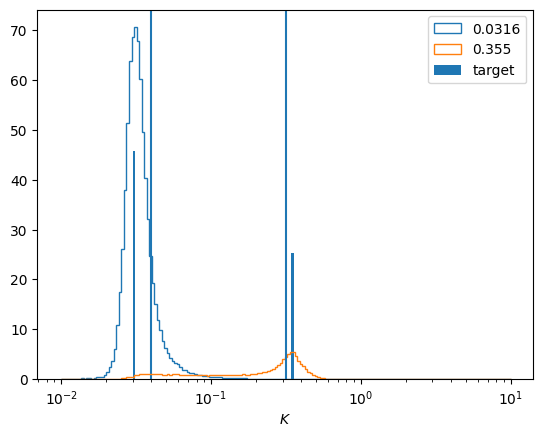

In [ ]:
# h = plt.hist(preds_D.reshape(-1), bins=bins_D,
#              histtype='step', density=True, label='pred');

arr_hist, edges = np.histogram(targs_D.reshape(-1),
                               bins=bins_D)
samp = arr_hist / max(arr_hist)*h[0].max()
plt.bar(edges[:-1], samp, width=np.diff(edges), label='target')

for i,D_ in enumerate(u_D):
    plt.hist(preds_D[masks_D[i]], bins=bins_D,
             histtype='step', # density=True, # density is not well computed with log scale!!!
             label=f'{D_:.3g}',);
    plt.axvline(preds_D[masks_D[i]].mean());

plt.xscale('log'); plt.xlabel(r'$K$'); plt.legend();

## Prediction distribution in time

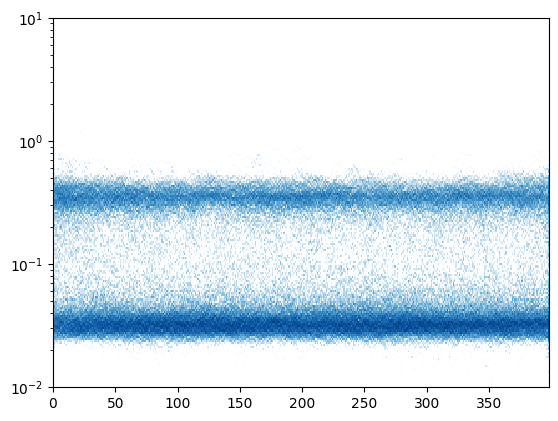

In [ ]:
plt.hist2d(np.tile(np.arange(preds_D.shape[-1]),preds_D.shape[0]),preds_D.reshape(-1),
          bins=[np.arange(preds_D.shape[-1]),bins_D], cmap='Blues', norm='log');
plt.yscale('log');

In [ ]:
def scatter_mean(shape, src, idx):
    mean=np.zeros(shape)
    for i,j in enumerate(idx):
        mean[j] += src[i]
    u=np.unique(idx, return_counts=True)
    return mean[u[0]]/u[1]

In [ ]:
means_D = [scatter_mean(preds_D.shape[-1], preds_D[mask], idx[1])
           for mask,idx in zip(masks_D, idx_D)]

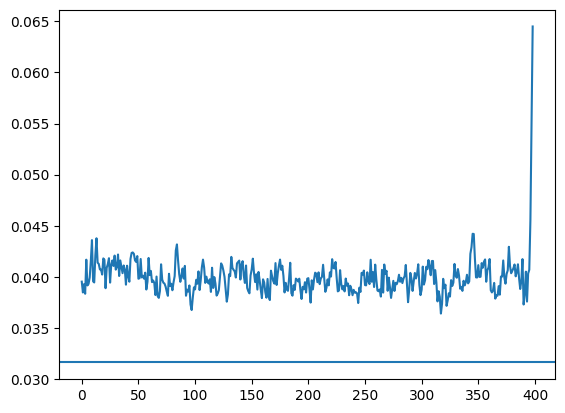

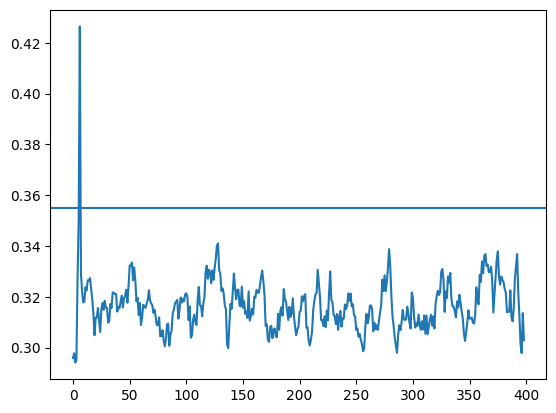

In [ ]:
for i, D_ in enumerate(u_D):
    plt.figure()
    plt.plot(means_D[i]);plt.axhline(D_);

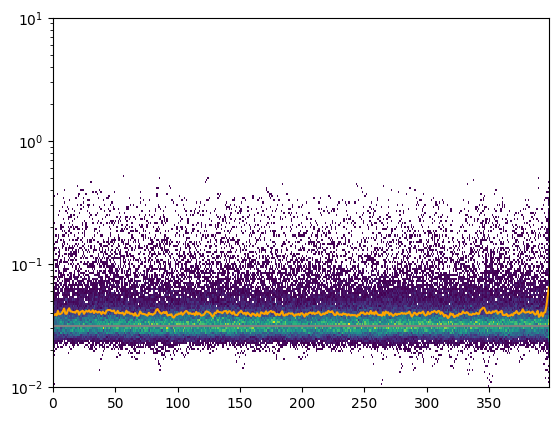

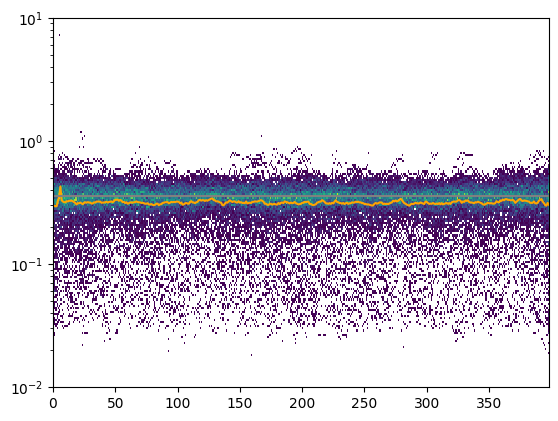

In [ ]:
for i, (D_, mask, idx, means) in enumerate(zip(u_D, masks_D, idx_D, means_D)):
    plt.figure()
    plt.hist2d(idx[1],preds_D[mask],
               bins=[np.arange(preds_D.shape[-1]),bins_D], cmin=1);
    plt.yscale('log');
    plt.plot(means, c='orange');plt.axhline(D_, c='gray');

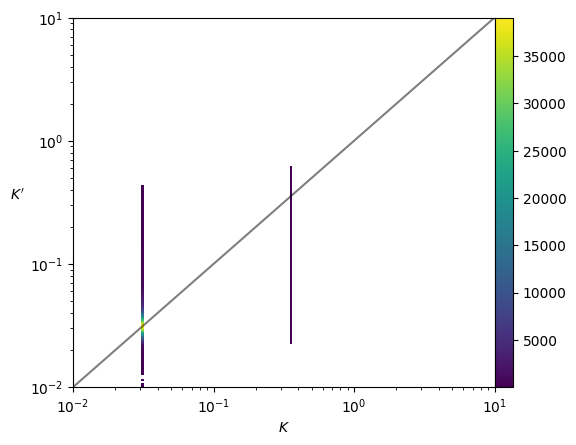

In [ ]:
plt.hist2d(targs_D.reshape(-1), preds_D.reshape(-1), bins=bins_D,
           #density=True,
           cmin=1);
plt.colorbar(pad=0)
plt.plot(bins_D[[0,-1]], bins_D[[0,-1]], 'k', alpha=.5);
plt.setp(plt.gca(), xscale='log',yscale='log', xlabel=r"$K$");
plt.ylabel(r"$K'$", rotation=0, ha='right');

## MSLE vs time

In [ ]:
# squared logarithmic error for the generalized diffusion coefficient
sle_D = (np.log(preds_D+1) - np.log(targs_D+1))**2
msle_D = sle_D.mean(0)
msle_D_mean = msle_D.mean(); msle_D_mean

TypeError: can only concatenate list (not "int") to list

In [ ]:
lengths_buc = [p.shape[1] for p in preds_D]

lengths_buc_u = np.unique(lengths_buc)

In [ ]:
sle_D = {str(l):[] for l in lengths_buc_u}

In [ ]:
# absolute error for alpha
for l, pred, targ in zip(lengths_buc, preds_D, targs_D):
    sle_D[str(l)].append((np.log(pred+1) - np.log(targ+1))**2)

In [ ]:
sle_D = {k:np.concatenate(v) for k,v in sle_D.items()}

In [ ]:
# squared logarithmic error for the generalized diffusion coefficient
sle_D_flat = (np.log(preds_D_flat+1) - np.log(targs_D_flat+1))**2

In [ ]:
sle_D_flat.mean()

0.011489157

In [ ]:
# squared logarithmic error for the generalized diffusion coefficient
sle_D_flat_ = (np.log(preds_D_flat_+1) - np.log(targs_D_flat_+1))**2

In [ ]:
sle_D_flat_.mean()

0.010718638

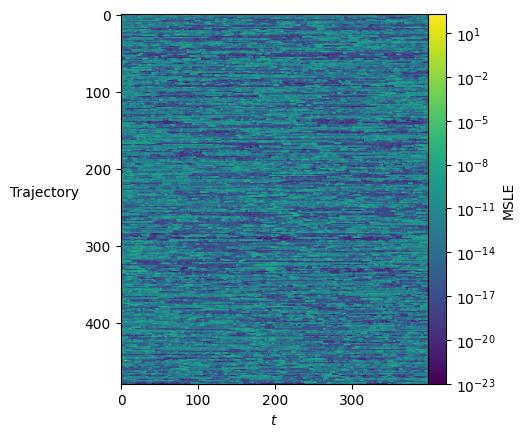

In [ ]:
plt.imshow(sle_D, norm='log', vmin=1e-23, vmax=200);
plt.colorbar(pad=0, label='MSLE');
plt.xlabel(r'$t$'); plt.ylabel('Trajectory', rotation=0, ha='right');

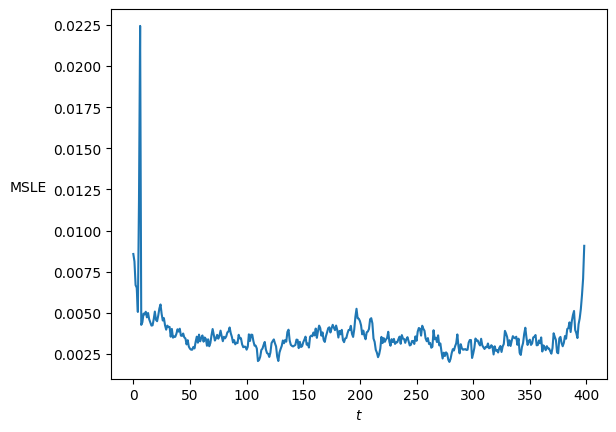

In [ ]:
plt.plot(msle_D); plt.xlabel(r'$t$'); plt.ylabel('MSLE', rotation=0, ha='right');
save_plot(plt.gcf(), model_a_name+'_DMSLE_on_multistate_L400')

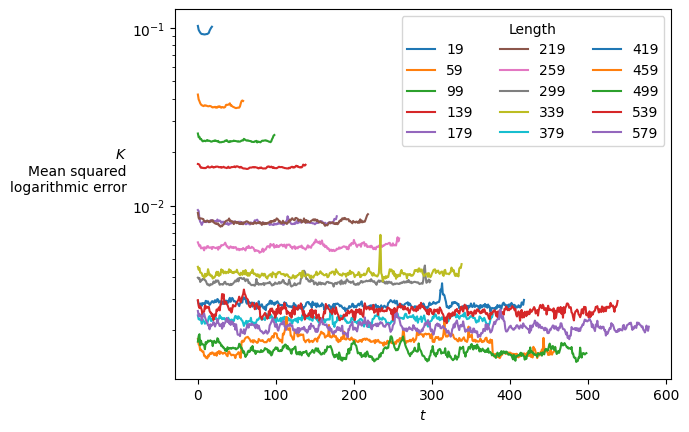

In [ ]:
for k in list(sle_D.keys())[::40]:
    plt.semilogy(sle_D[k].mean(0),label=k);
plt.legend(title='Length', ncol=3,)#bbox_to_anchor=(1,1));
plt.xlabel(r'$t$'); plt.ylabel(r'$K$'+'\nMean squared\nlogarithmic error', rotation=0, ha='right');
save_plot(plt.gcf(), model_log_D_name+'_DSLE_len_on_medium_49')

## MALE vs time

In [ ]:
targs_D.shape, preds_D.shape, sle_D.shape, msle_D.shape

((480, 399), (480, 399), (480, 399), (399,))

In [ ]:
# Mean absolute logarithmic error for the generalized diffusion coefficient
le_D = np.log(preds_D/targs_D)
ale_D = np.abs(le_D)
male_D = ale_D.mean(0)
male_D_mean = male_D.mean(); male_D_mean

0.26344696

In [ ]:
# Mean absolute logarithmic error for the generalized diffusion coefficient
le_D_flat = np.log(preds_D_flat/targs_D_flat)
ale_D_flat = np.abs(le_D_flat)
male_D_flat = ale_D_flat.mean()
male_D_flat

0.51450163

In [ ]:
# Mean absolute logarithmic error for the generalized diffusion coefficient
le_D_flat_ = np.log(preds_D_flat_/targs_D_flat_)
ale_D_flat_ = np.abs(le_D_flat_)
male_D_flat_ = ale_D_flat_.mean()
male_D_flat_

1.2059547

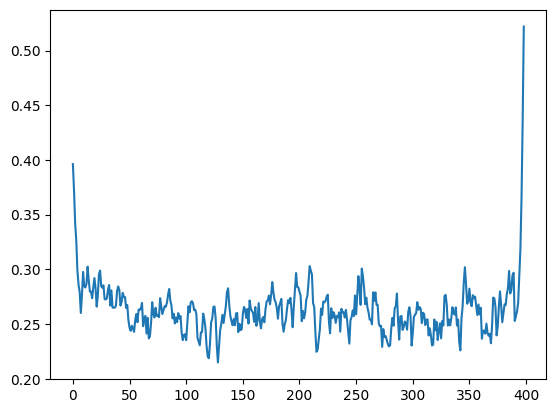

In [ ]:
plt.plot(male_D);

An elevated error in the boundaries may indicate an artifact of the padding from convolutions.

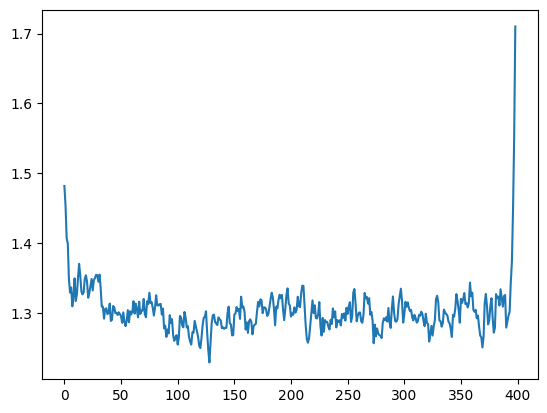

In [ ]:
# EMALE
plt.plot(np.exp(male_D));

In [ ]:
mTsle_D = [scatter_mean(sle_D.shape[-1], sle_D[mask], idx[1])
           for mask,idx in zip(masks_D, idx_D)]
mTale_D = [scatter_mean(ale_D.shape[-1], ale_D[mask], idx[1])
           for mask,idx in zip(masks_D, idx_D)]

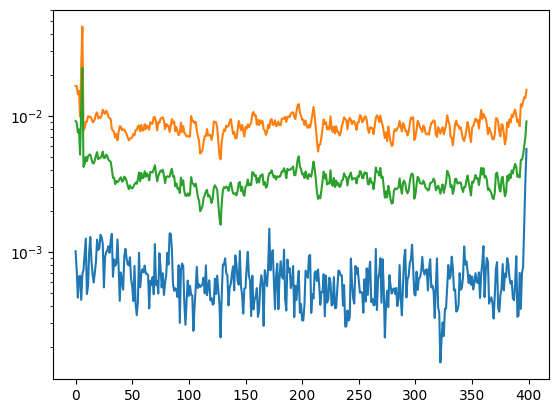

In [ ]:
for i,D_ in enumerate(u_D):
    plt.plot(mTsle_D[i])

plt.plot(msle_D);plt.yscale('log')

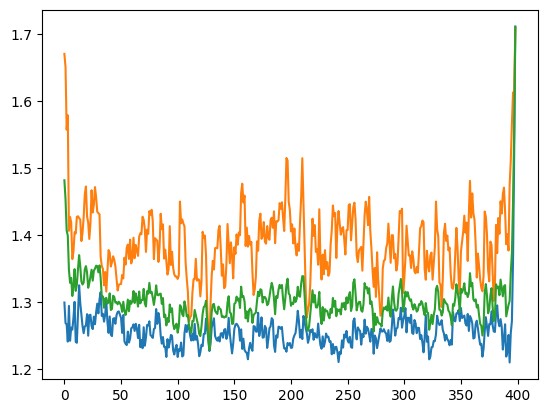

In [ ]:
for i,D_ in enumerate(u_D):
    plt.plot(np.exp(mTale_D[i]))
plt.plot(np.exp(male_D));

## MSLE vs $D$ for various lengths L

In [ ]:
targs_D.shape, le_D.shape

((480, 399), (480, 399))

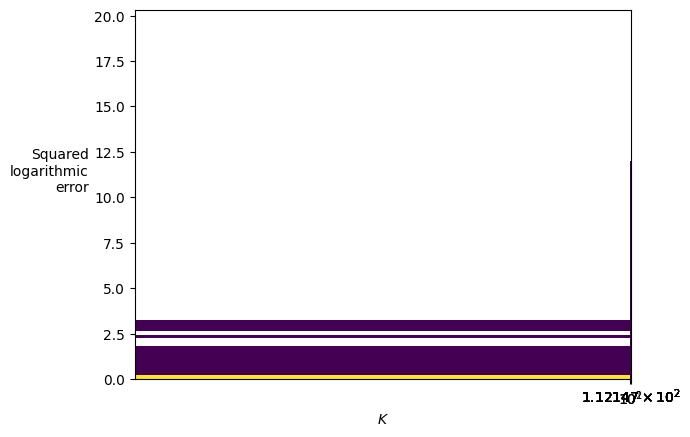

In [ ]:
plt.hist2d(targs_D_flat,sle_D_flat, 100, cmin=1);
plt.xlabel(r'$K$'); plt.xscale('log'); # linear y
plt.ylabel('Squared\nlogarithmic\nerror', rotation=0, ha='right');

In [ ]:
preds_D_flat.min(), preds_D_flat.max()

(7.948283e-05, 125.89251)

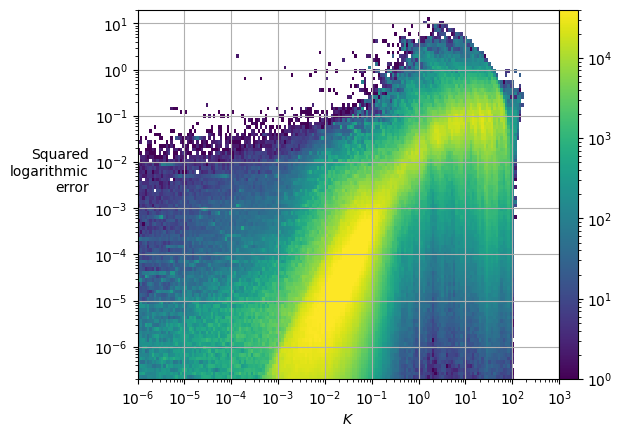

In [ ]:
bins_sle = np.geomspace(2e-7,2e1,100)
plt.hist2d(preds_D_flat,sle_D_flat, bins=[bins_D, bins_sle],
           #density=True,
           norm=matplotlib.colors.LogNorm(vmin=1, vmax=4e4));
plt.grid()
cbar = plt.colorbar(pad=0)
plt.xscale('log'); plt.xlabel(r'$K$');
plt.yscale('log')
plt.ylabel('Squared\nlogarithmic\nerror', rotation=0, ha='right');
save_plot(plt.gcf(), model_log_D_name+'pred_D_vs_SLE_on_medium_49')

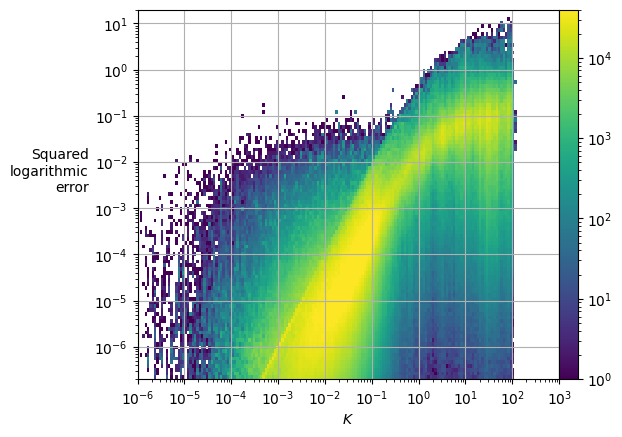

In [ ]:
bins_sle = np.geomspace(2e-7,2e1,100)
plt.hist2d(targs_D_flat,sle_D_flat, bins=[bins_D, bins_sle],
           #density=True,
           norm=matplotlib.colors.LogNorm(vmin=1, vmax=4e4));
plt.grid()
cbar = plt.colorbar(pad=0)
plt.xscale('log'); plt.xlabel(r'$K$');
plt.yscale('log')
plt.ylabel('Squared\nlogarithmic\nerror', rotation=0, ha='right');
save_plot(plt.gcf(), model_log_D_name+'targ_D_vs_SLE_on_medium_49')

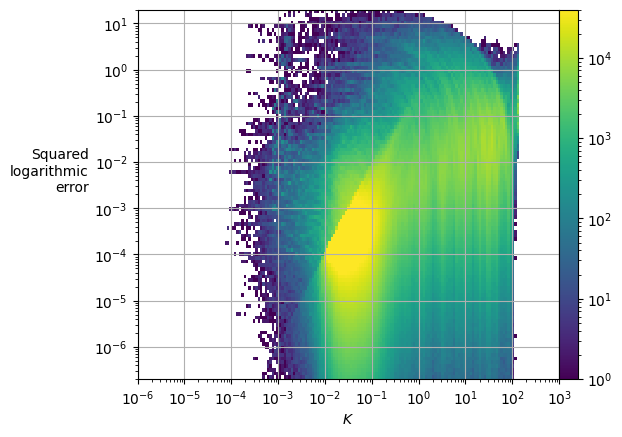

In [ ]:
bins_sle = np.geomspace(2e-7,2e1,100)
plt.hist2d(preds_D_flat_,sle_D_flat_, bins=[bins_D, bins_sle],
           #density=True,
           norm=matplotlib.colors.LogNorm(vmin=1, vmax=4e4));
plt.colorbar(pad=0)
plt.grid()
plt.xscale('log'); plt.xlabel(r'$K$');
plt.yscale('log')
plt.ylabel('Squared\nlogarithmic\nerror', rotation=0, ha='right');
save_plot(plt.gcf(), model_log_D_name_+'pred_D_vs_SLE_on_medium_49_')

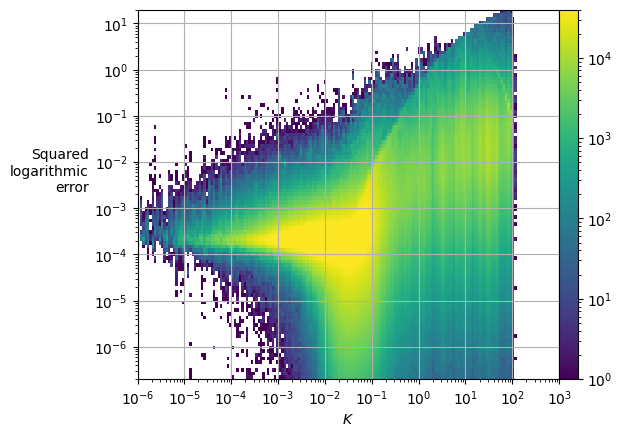

In [ ]:
bins_sle = np.geomspace(2e-7,2e1,100)
plt.hist2d(targs_D_flat_,sle_D_flat_, bins=[bins_D, bins_sle],
           #density=True,
           norm=matplotlib.colors.LogNorm(vmin=1, vmax=4e4));
plt.colorbar(pad=0)
plt.grid()
plt.xscale('log'); plt.xlabel(r'$K$');
plt.yscale('log')
plt.ylabel('Squared\nlogarithmic\nerror', rotation=0, ha='right');
save_plot(plt.gcf(), model_log_D_name_+'targ_D_vs_SLE_on_medium_49_')

In [ ]:
bins_sle = np.geomspace(1e-7,1e0,100)
plt.hist2d(preds_D_flat,sle_D_flat, bins=[bins_D, bins_sle] ,
           #density=True,
           cmin=1);
plt.colorbar(pad=0)
plt.xscale('log'); plt.xlabel(r'$K$');
plt.yscale('log')
plt.ylabel('Squared\nlogarithmic\nerror', rotation=0, ha='right');

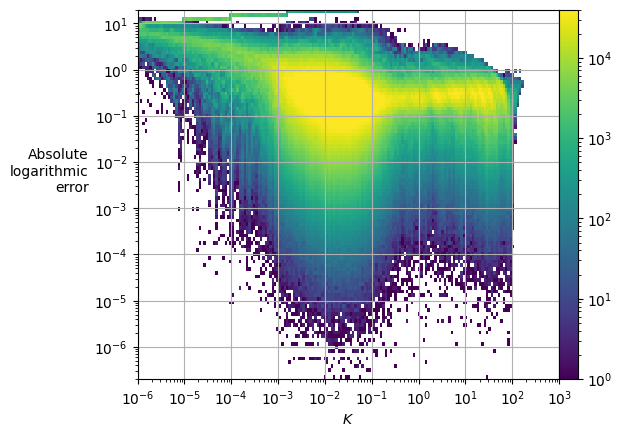

In [ ]:
bins_sle = np.geomspace(2e-7,2e1,100)
plt.hist2d(preds_D_flat,ale_D_flat, bins=[bins_D, bins_sle],
           #density=True,
           norm=matplotlib.colors.LogNorm(vmin=1, vmax=4e4));
plt.grid()
cbar = plt.colorbar(pad=0)
plt.xscale('log'); plt.xlabel(r'$K$');
plt.yscale('log')
plt.ylabel('Absolute\nlogarithmic\nerror', rotation=0, ha='right');
save_plot(plt.gcf(), model_log_D_name+'_pred_D_vs_ALE_on_medium_49')

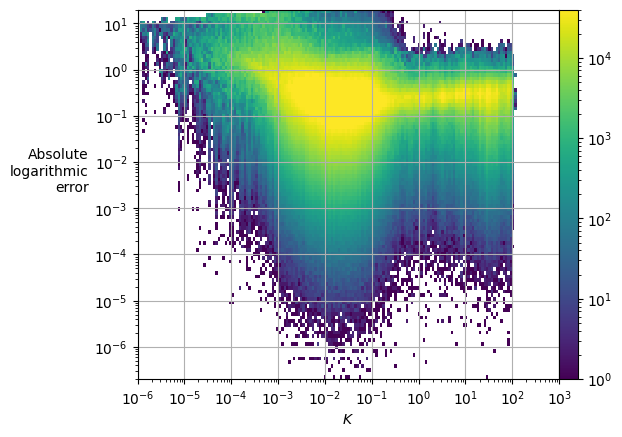

In [ ]:
bins_sle = np.geomspace(2e-7,2e1,100)
plt.hist2d(targs_D_flat,ale_D_flat, bins=[bins_D, bins_sle],
           #density=True,
           norm=matplotlib.colors.LogNorm(vmin=1, vmax=4e4));
plt.grid()
cbar = plt.colorbar(pad=0)
plt.xscale('log'); plt.xlabel(r'$K$');
plt.yscale('log')
plt.ylabel('Absolute\nlogarithmic\nerror', rotation=0, ha='right');
save_plot(plt.gcf(), model_log_D_name+'_targ_D_vs_ALE_on_medium_49')

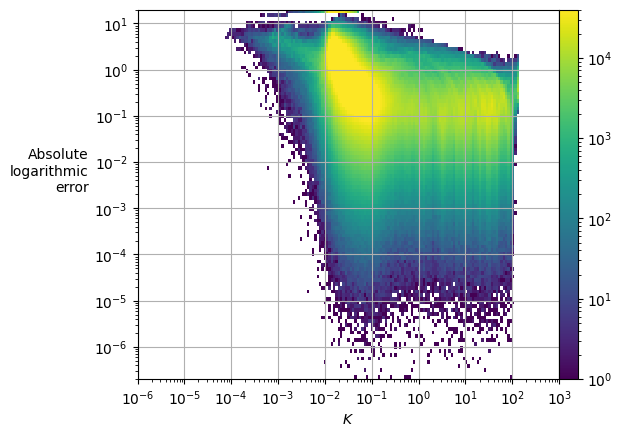

In [ ]:
bins_sle = np.geomspace(2e-7,2e1,100)
plt.hist2d(preds_D_flat_,ale_D_flat_, bins=[bins_D, bins_sle],
           #density=True,
           norm=matplotlib.colors.LogNorm(vmin=1, vmax=4e4));
plt.colorbar(pad=0)
plt.grid()
plt.xscale('log'); plt.xlabel(r'$K$');
plt.yscale('log')
plt.ylabel('Absolute\nlogarithmic\nerror', rotation=0, ha='right');
save_plot(plt.gcf(), model_log_D_name_+'_pred_D_vs_ALE_on_medium_49_')

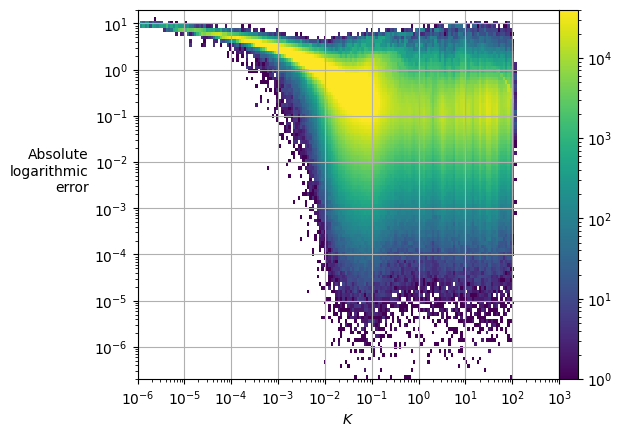

In [ ]:
bins_sle = np.geomspace(2e-7,2e1,100)
plt.hist2d(targs_D_flat_,ale_D_flat_, bins=[bins_D, bins_sle],
           #density=True,
           norm=matplotlib.colors.LogNorm(vmin=1, vmax=4e4));
plt.colorbar(pad=0)
plt.grid()
plt.xscale('log'); plt.xlabel(r'$K$');
plt.yscale('log')
plt.ylabel('Absolute\nlogarithmic\nerror', rotation=0, ha='right');
save_plot(plt.gcf(), model_log_D_name_+'_targ_D_vs_ALE_on_medium_49_')

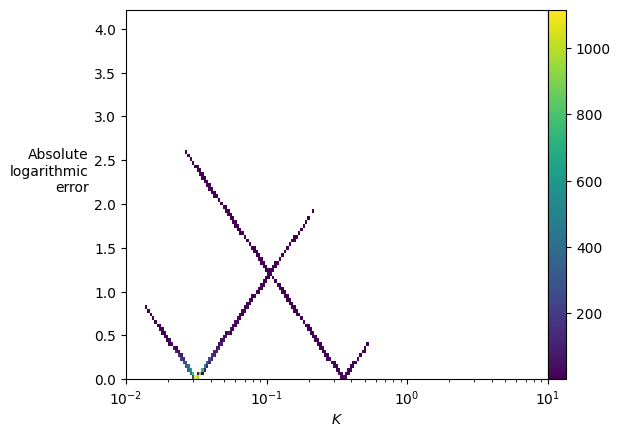

In [ ]:
plt.hist2d(preds_D.reshape(-1),ale_D.reshape(-1), bins=[bins_D, 100] ,
           #density=True,
           cmin=1);
plt.colorbar(pad=0)
plt.xscale('log'); plt.xlabel(r'$K$');
plt.ylabel('Absolute\nlogarithmic\nerror', rotation=0, ha='right');

In [ ]:
bins_D = np.geomspace(1e-2,1e0,100)

## MSLE vs length L for various $D$

# Alpha and D

## Distribution

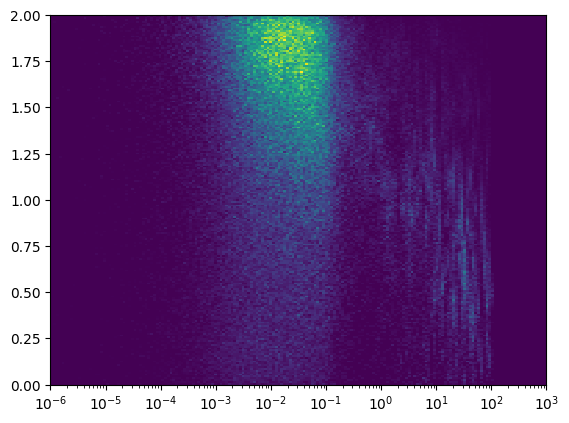

In [ ]:
plt.hist2d(targs_D_flat, targs_a_flat, bins=[bins_D, bins_a]);plt.xscale('log');
save_plot(plt.gcf(), 'aD_hist2d_on_medium_49')

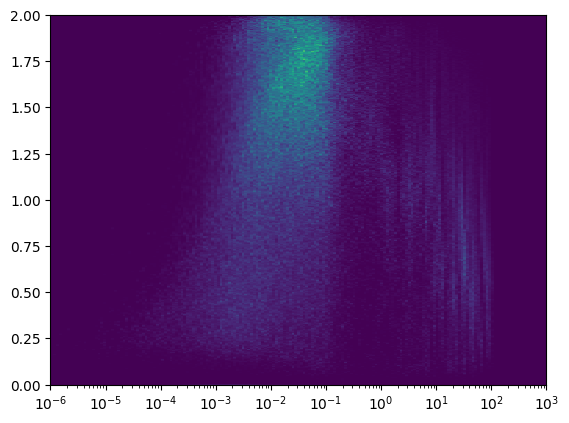

In [ ]:
plt.hist2d(targs_D_flat, preds_a_flat, bins=[bins_D, bins_a]);plt.xscale('log');
save_plot(plt.gcf(), model_a_name+model_log_D_name+'_apredDtarg_hist2d_on_medium_49')

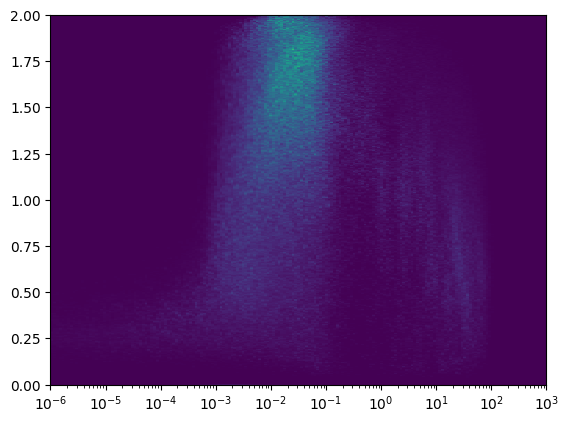

In [ ]:
plt.hist2d(preds_D_flat, preds_a_flat, bins=[bins_D, bins_a]);plt.xscale('log');
save_plot(plt.gcf(), model_a_name+model_log_D_name+'_aD_hist2d_on_medium_49')

## Error

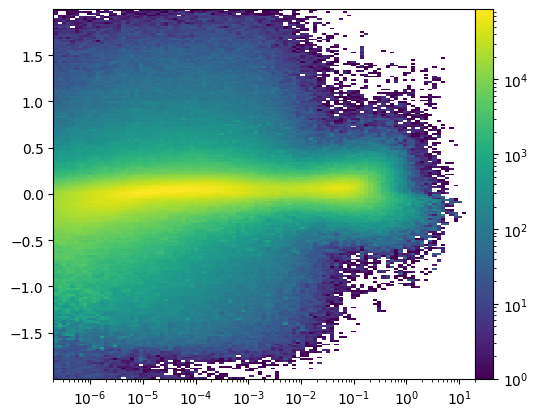

In [ ]:
plt.hist2d(sle_D_flat, e_a_flat, bins=[bins_sle, 200],
           norm=matplotlib.colors.LogNorm()
          );plt.xscale('log');plt.colorbar(pad=0);
save_plot(plt.gcf(), model_a_name+model_log_D_name+'_erroralpha_sleD_on_medium_49')

# Change points CP

## Distributions

In [ ]:
# number of changepoints per trajectory = number of segments + 1
num_cps = np.array([len(cps) for cps in true_cps])
num_seg_cps = np.array([len(cps) for cps in seg_cps])

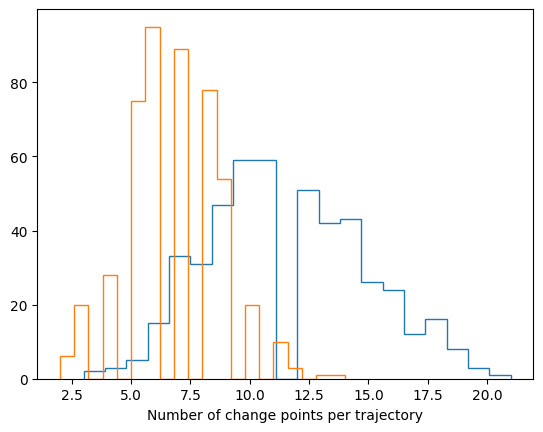

In [ ]:
plt.hist(num_cps, 20, histtype='step');
plt.hist(num_seg_cps, 20, histtype='step');
plt.xlabel('Number of change points per trajectory');

In [ ]:
# TODO number of change points per trajectory length

In [ ]:
e_cps = num_seg_cps-num_cps

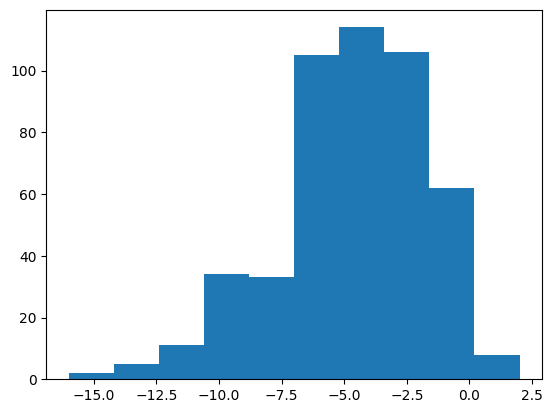

In [ ]:
plt.hist(e_cps,);

In [ ]:
flat_cps = [item for sublist in true_cps
           for item in sublist]
flat_seg_cps = [item for sublist in seg_cps
           for item in sublist]

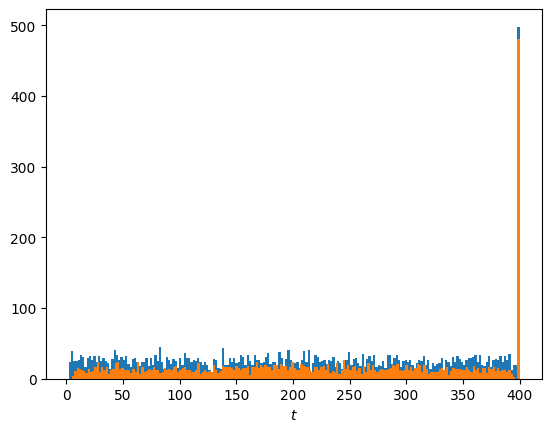

In [ ]:
# distribution of changepoints in time
plt.hist(flat_cps, 200, );plt.hist(flat_seg_cps, 200, );
plt.xlabel(r'$t$');

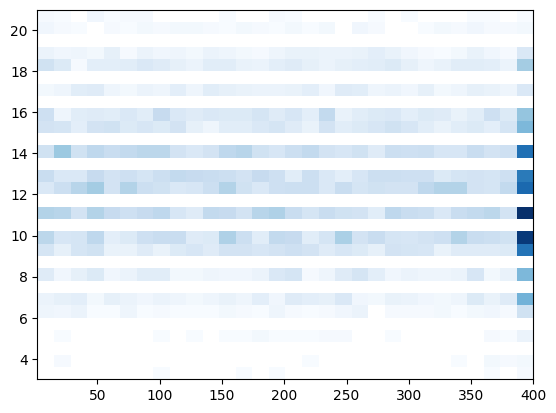

In [ ]:
plt.hist2d(flat_cps, np.array(num_cps).repeat(num_cps), 30, cmap='Blues', cmin=1);

In [ ]:
# length of the segments
len_cps     = [cps[1:]-cps[:-1] for cps in true_cps]
len_seg_cps = [cps[1:]-cps[:-1] for cps in seg_cps]

In [ ]:
flat_len_cps = [item for sublist in len_cps
           for item in sublist]
flat_len_seg_cps = [item for sublist in len_seg_cps
           for item in sublist]

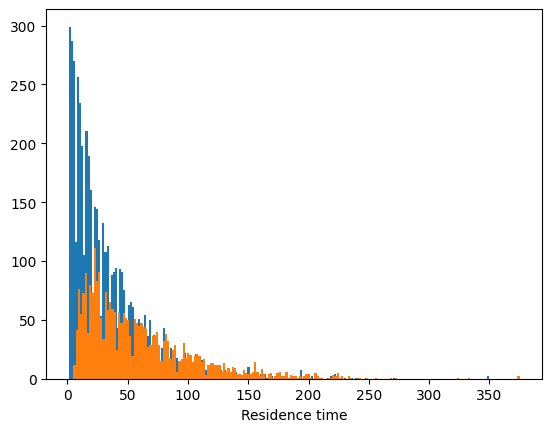

In [ ]:
# distribution of segment length /residence time
plt.hist(flat_len_cps, 200, );plt.hist(flat_len_seg_cps, 200, );
plt.xlabel(r'Residence time');

## Errors

In [ ]:
from andi_datasets.utils_challenge import single_changepoint_error, ensemble_changepoint_error

In [ ]:
TP_rmse, JI = zip(*[single_changepoint_error(true_cps_, seg_cps_,)
               for true_cps_, seg_cps_ in zip(true_cps, seg_cps)])

In [ ]:
TP_rmse_e, JI_e = ensemble_changepoint_error(true_cps, seg_cps,)

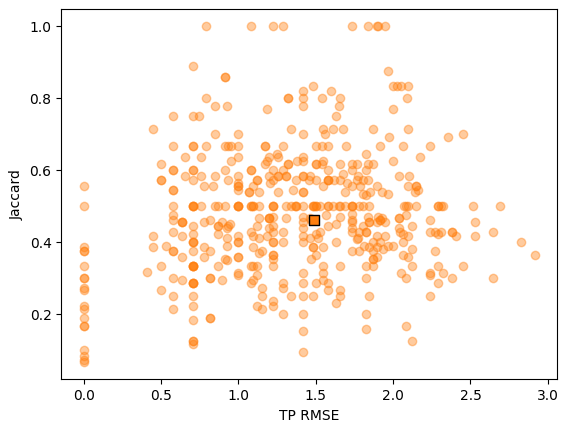

In [ ]:
plt.scatter(TP_rmse, JI, c = 'C1', alpha = 0.4)
plt.scatter(TP_rmse_e, JI_e , c = 'C1', s = 50, marker = 's', edgecolors = 'k')
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');

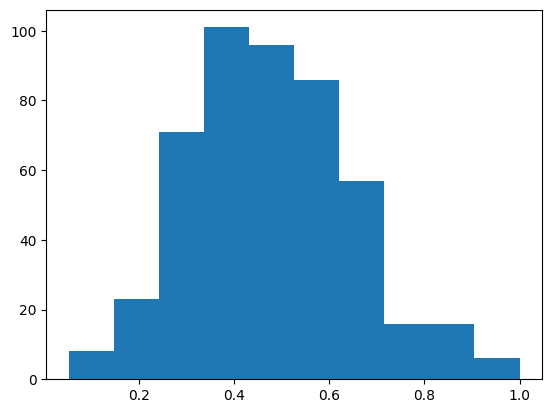

In [ ]:
plt.hist(JI);

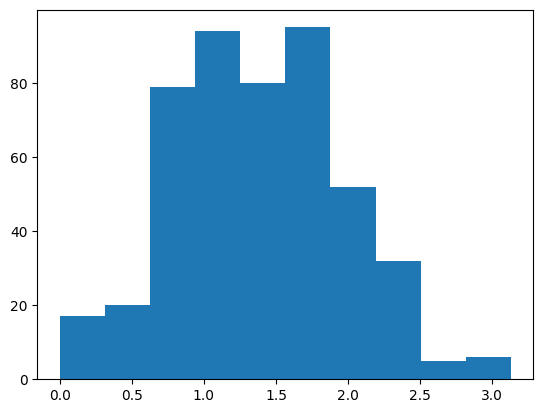

In [ ]:
plt.hist(TP_rmse);

## CP Metric without length cp

when there is no true_cp:
    if:
        pred empty = perfect
        return 0,1
    else:
        FP = len(pred)
        return ??FP,0
when there is one or more true_cp:
    if pred_empty:
        FN = len(true_cp)
        return FN, 0
    elif pred one or more:
        assignment  # only if true_cp and pred_cp are non empty
        for p in assignment:
            if in threshold:TP
            else: FP and FN

In [ ]:
true_len = L(cps[-1:] for cps in true_cps)

In [ ]:
# metrics when predicting only the length of the trajectories
TP_rmse_len, JI_len = ensemble_changepoint_error(true_cps, true_len)
TP_rmse_len, JI_len

(0.0, 0.08689355539464157)

In [ ]:
TP_, JI_ = [],[]
TP_.append(TP_rmse_e)
JI_.append(JI_e)

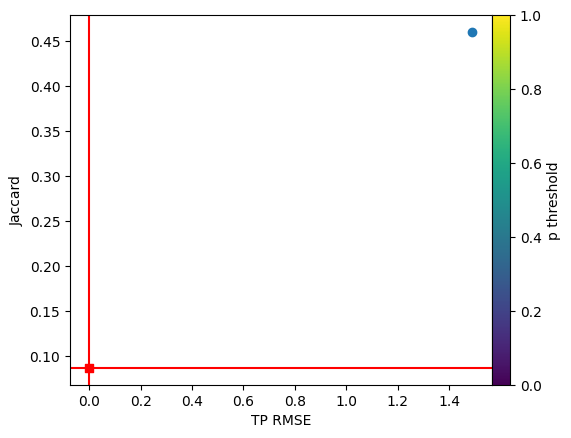

In [ ]:
plt.scatter(TP_rmse_len, JI_len, marker='s',c='r', );
plt.axvline(TP_rmse_len, c='r', zorder=-1); plt.axhline(JI_len, c='r', zorder=-1);
plt.scatter(TP_, JI_, );#c=p_);
plt.colorbar(pad=0, label='p threshold');
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');

In [ ]:
from andi_datasets.utils_challenge import changepoint_assignment

In [ ]:
true_cps[0], seg_cps[0][0:0]

(array([ 81, 132, 175, 247, 261, 269, 304, 331, 387, 400]),
 array([], dtype=int64))

In [ ]:
changepoint_assignment(true_cps[0][0:0], seg_cps[0])

((array([], dtype=int64), array([], dtype=int64)),
 array([], shape=(0, 7), dtype=float64))

In [ ]:
np.sqrt(np.mean([]))

/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [ ]:
single_changepoint_error(true_cps[0][0:0], seg_cps[0])

/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gfernandez/miniforge3/envs/step/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(nan, 0.0)

In [ ]:
single_changepoint_error??

Signature: single_changepoint_error(GT, preds, threshold=5)
Docstring:
Given the groundtruth and predicted changepoints for a single trajectory, first solves the assignment problem between changepoints,
then calculates the RMSE of the true positive pairs and the Jaccard index.

Parameters
----------
GT : list
    List of groundtruth change points.
preds : list
    List of predicted change points.
threshold : float
    Distance from which predictions are considered to have failed. They are then assigned this number.

Returns
-------
tuple
    - TP_rmse: root mean square error of the true positive change points.
    - Jaccard Index of the ensemble predictions        
    
Source:   
def single_changepoint_error(GT, preds, threshold = 5):
    '''
    Given the groundtruth and predicted changepoints for a single trajectory, first solves the assignment problem between changepoints,
    then calculates the RMSE of the true positive pairs and the Jaccard index.
    
    Parameters
    -------

In [ ]:
jaccard_index??

Signature: jaccard_index(true_positive, false_positive, false_negative)
Source:   
def jaccard_index(true_positive, false_positive, false_negative):
    "Computes the Jaccard index a.k.a. Tanimoto index."
    return true_positive/(true_positive + false_positive + false_negative)
File:      ~/Downloads/step/step/utils.py
Type:      function

In [ ]:
def single_changepoint_error_nolen(GT, preds, threshold = 5):
    '''
    Given the groundtruth and predicted changepoints for a single trajectory,
    first handles the empty cases, i.e., when there a no change points,
    then, solves the assignment problem between changepoints,
    and returns the RMSE of the true positive pairs and the Jaccard index.
    
    Parameters
    ----------
    GT : list
        List of groundtruth change points.
    preds : list
        List of predicted change points.
    threshold : float
        Distance from which predictions are considered to have failed.
        They are then assigned this number in the RMSE.
    
    Returns
    -------
    tuple
        - TP_rmse: root mean square error of the true positive change points.
        - Jaccard Index of the ensemble predictions        
        
    '''
    if len(GT)==0:  # when there is no true_cp:
        if len(preds)==0:    return 0,1  # perfect
        else:
            FP = len(preds)
            return min(FP,threshold), 0
    elif len(preds)==0:  # when there is one or more true_cp but preds is empty
        FN = len(GT)
        return min(FN,threshold), 0
    else: # there are one or more preds and true cps:
        assignment, _ = changepoint_assignment(GT, preds) # only if true_cp and pred_cp are non empty
        assignment = np.array(assignment)
        
        TP, FP, FN = 0, 0, 0
        TP_rmse = []
        for p in assignment.transpose():
            if np.abs(GT[p[0]] - preds[p[1]]) < threshold:
                TP += 1
                TP_rmse.append((GT[p[0]] - preds[p[1]])**2)
            else: # if the cp candidate is not in threshold
                # cp_candidate is a False Positive
                FP += 1
                # and the prediction missed a cp, hence, there is a False Negative
                FN += 1

        # Checking false positive and missed events
        if len(preds) > len(GT):
            FP += len(preds) - len(GT)
        elif len(preds) < len(GT):
            FN += len(GT) - len(preds)

        # Calculating RMSE
        TP_rmse = np.sqrt(np.mean(TP_rmse)) if len(TP_rmse) > 0 else threshold
        
        return TP_rmse, jaccard_index(TP, FP, FN)

In [ ]:
ensemble_changepoint_error??

Signature: ensemble_changepoint_error(GT_ensemble, pred_ensemble, threshold=5)
Source:   
def ensemble_changepoint_error(GT_ensemble, pred_ensemble, threshold = 5):    
    ''' 
    Given an ensemble of groundtruth and predicted change points, iterates
    over each trajectory's changepoints. For each, it solves the assignment problem 
    between changepoints. Then, calculates the RMSE of the true positive pairs and
    the Jaccard index over the ensemble of changepoints (i.e. not the mean of them 
    w.r.t. to the trajectories)
    
    Parameters
    ----------
    GT_ensemble : list, array
        Ensemble of groutruth change points.
    pred_ensemble : list
        Ensemble of predicted change points.
    threshold : float
        Distance from which predictions are considered to have failed. They are then assigned this number.
    
    Returns
    -------
    tuple
        - TP_rmse: root mean square error of the true positive change points.
        - Jaccard Index of the ensemb

In [ ]:
def ensemble_changepoint_error_nolen(GT_ensemble, pred_ensemble, threshold = 5):    
    ''' 
    Given an ensemble of groundtruth and predicted change points,
    iterates over each trajectory's changepoints.
    For each trajectory ground truth (GT) and prediction pair,
    it handles the empty cases, and if they are not empty,
    it solves the assignment problem between changepoints. 
    Then, calculates the RMSE of the true positive (TP) pairs and
    the Jaccard index over the ensemble of changepoints 
    (i.e., not the mean of the TP pairs w.r.t. to the trajectories)
    
    Parameters
    ----------
    GT_ensemble : list, array
        Ensemble of groutruth change points.
    pred_ensemble : list
        Ensemble of predicted change points.
    threshold : float
        Distance from which predictions are considered to have failed. They are then assigned this number.
    
    Returns
    -------
    tuple
        - TP_rmse: root mean square error of the true positive change points.
        - Jaccard Index of the ensemble predictions
    
    '''
    
    TP, FP, FN = 0, 0, 0
    TP_rmse = []
    num_cp_GT = 0
    for true_cp, pred_traj in zip(GT_ensemble, pred_ensemble):
        num_cp_GT += len(true_cp)
        #-------------------------------------------------------------
        if len(true_cp)==0:  # when there is no true_cp:
            if len(pred_traj)==0:    TP_rmse.append(0)  # perfect
            else:
                FP += len(pred_traj)
                TP_rmse.append(min(FP,threshold)**2)
        elif len(pred_traj)==0:  # when there is one or more true_cp but preds is empty
            FN += len(true_cp)
            TP_rmse.append(min(FN,threshold)**2)
        else: # there are one or more preds and true cps:
            assignment, _ = changepoint_assignment(true_cp, pred_traj) # only if true_cp and pred_cp are non empty
            assignment = np.array(assignment)
            for p in assignment.transpose():
                if np.abs(true_cp[p[0]] - pred_traj[p[1]]) < threshold:
                    TP += 1
                    TP_rmse.append((true_cp[p[0]] - pred_traj[p[1]])**2)
                else: # if the cp candidate is not in threshold
                    # cp_candidate is a False Positive
                    FP += 1
                    # and the prediction missed a cp, hence, there is a False Negative
                    FN += 1
    
            # Checking false positive and missed events
            if len(pred_traj) > len(true_cp):
                FP += len(pred_traj) - len(true_cp)
            elif len(pred_traj) < len(true_cp):
                FN += len(true_cp) - len(pred_traj)
        #-------------------------------------------------------------
        # assignment, _ = changepoint_assignment(gt_traj, pred_traj)
        # assignment = np.array(assignment)
        
        # for p in assignment.transpose():
            
        #     if np.abs(gt_traj[p[0]] - pred_traj[p[1]]) < threshold:
        #         TP += 1
        #         TP_rmse.append((gt_traj[p[0]] - pred_traj[p[1]])**2)
        #     else:
        #         FP += 1
        #         FN += 1    
                
        # # Checking false positive and missed events
        # if len(pred_traj) > len(gt_traj):
        #     FP += len(pred_traj) - len(gt_traj)
        # elif len(pred_traj) < len(gt_traj):
        #     FN += len(gt_traj) - len(pred_traj)
        #--------------------------------------------------------------
    # after the ensemble loop
    if TP+FP+FN == 0:
        if num_cp_GT == 0:    return 0, 1  # this means there where no CP both in GT and Pred
        warnings.warn('No segments found in your predictions dataset.')
        return threshold, 0
        
    # Calculating RMSE for all TP
    TP_rmse = np.sqrt(np.mean(TP_rmse)) if len(TP_rmse) > 0 else threshold
        
    return TP_rmse, jaccard_index(TP, FP, FN)

In [ ]:
true_nolen = L(cps[:-1] for cps in true_cps)

In [ ]:
# metrics when predicting all the cps with no length of the trajectories
TP_rmse_nolen, JI_nolen = ensemble_changepoint_error_nolen(true_nolen, true_nolen)
TP_rmse_nolen, JI_nolen

(0.0, 1.0)

Metrics here

In [ ]:
seg_cps_nolen = [cps[:-1] for cps in seg_cps] # from ruptures

In [ ]:
TP_rmse, JI = zip(*[single_changepoint_error_nolen(gtrue_cps_, pred_cps_,)
               for gtrue_cps_, pred_cps_ in zip(true_nolen, seg_cps)]) #seg_cps_nolen)])

In [ ]:
TP_rmse_e_nolen, JI_e_nolen = ensemble_changepoint_error_nolen(true_nolen, seg_cps)#_nolen)
TP_rmse_e_nolen, JI_e_nolen

(2.9254603319220887, 0.05828586567757319)

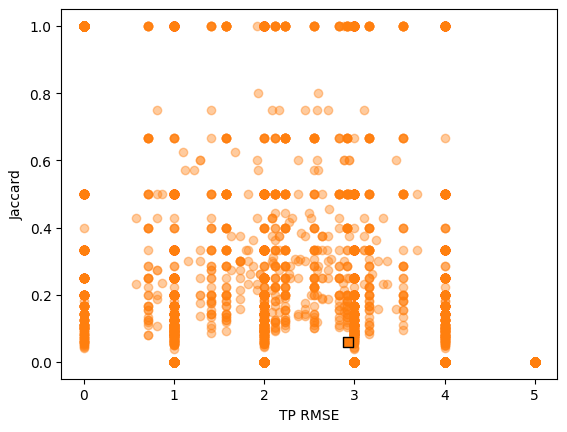

In [ ]:
plt.scatter(TP_rmse, JI, c = 'C1', alpha = 0.4)  # in medium_0 step preds with pen=10
plt.scatter(TP_rmse_e_nolen, JI_e_nolen , c = 'C1', s = 50, marker = 's', edgecolors = 'k')
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');

In [ ]:
TP_rmse_e_nolen, JI_e_nolen = ensemble_changepoint_error_nolen(true_nolen, seg_cps)#_nolen)
TP_rmse_e_nolen, JI_e_nolen

(4.150600463186031, 0.035905644742056854)

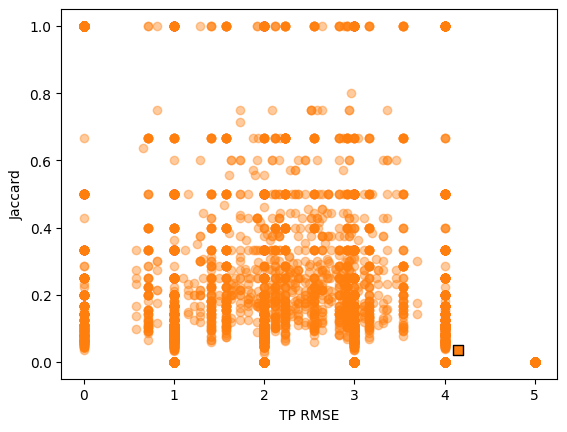

In [ ]:
plt.scatter(TP_rmse, JI, c = 'C1', alpha = 0.4) # in medium_0 step preds with pen=3.5
plt.scatter(TP_rmse_e_nolen, JI_e_nolen , c = 'C1', s = 50, marker = 's', edgecolors = 'k')
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');

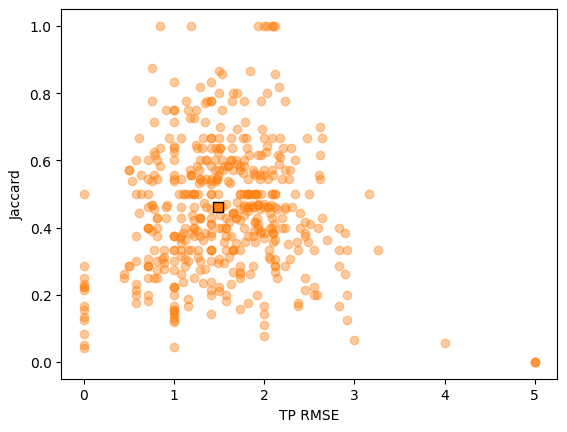

In [ ]:
plt.scatter(TP_rmse, JI, c = 'C1', alpha = 0.4) # in multistate with pen=3.5
plt.scatter(TP_rmse_e, JI_e , c = 'C1', s = 50, marker = 's', edgecolors = 'k')
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');

In [ ]:
p_ = np.linspace(2,7,11)
TP_, JI_ = [],[]

In [ ]:
p_ = np.append(p_, np.linspace(10,30,3)); p_

array([ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
       10. , 20. , 30. ])

In [ ]:
p_[-3:]

array([10., 20., 30.])

TODO penalty depends on trajectory length?  Does not seem. Look at distribution of  number of change points per length.

In [ ]:
len(true_cps_)

54812

In [ ]:
true_cps_shapes = list(map(lambda x: x.shape[0], true_cps_))

In [ ]:
shapes  = list(map(lambda x: x.shape[0], preds))
lengths = list(map(lambda x: x.shape[1], preds))

In [ ]:
shapes_cumsum = np.cumsum([0]+shapes)

In [ ]:
shapes_cumsum

array([    0,    12,    19, ..., 54675, 54796, 54812])

In [ ]:
true_cps_num_len = [sum(true_cps_shapes[i:i_]) for i,i_ in zip(shapes_cumsum[:-1], shapes_cumsum[1:])]

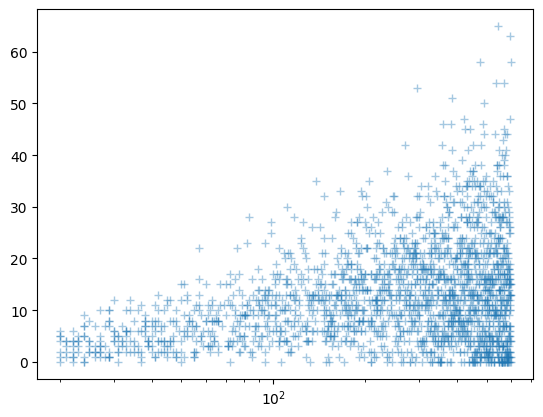

In [ ]:
plt.plot(lengths,true_cps_num_len,'+', alpha=0.4);#plt.yscale('log');
plt.xscale('log');

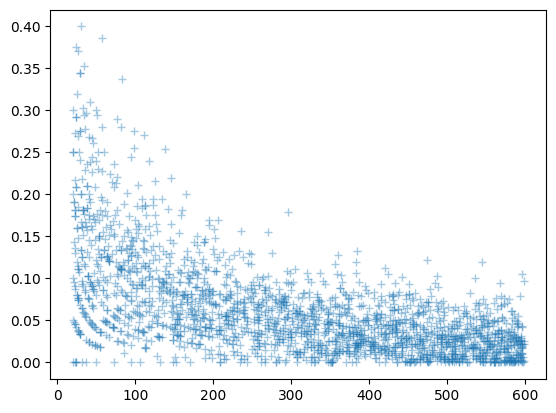

In [ ]:
plt.plot(lengths,np.array(true_cps_num_len)/np.array(lengths),'+', alpha=0.4);#plt.yscale('log');
# plt.xscale('log');

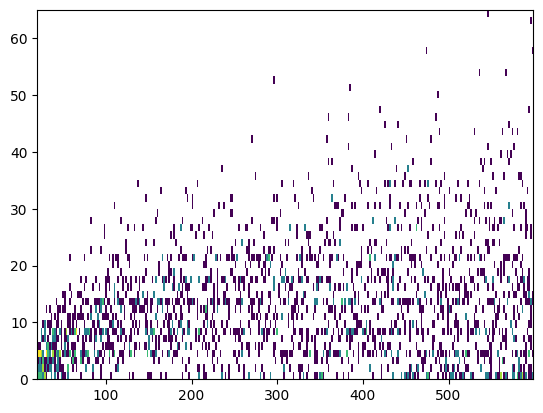

In [ ]:
plt.hist2d(lengths,true_cps_num_len,bins=[299,50], norm=matplotlib.colors.LogNorm());#plt.yscale('log');

In [ ]:
len(preds), list(map(lambda x: x.shape, preds)) #preds[0].shape,preds[1].shape

(2108,
 [torch.Size([12, 333, 2]),
  torch.Size([7, 539, 2]),
  torch.Size([11, 335, 2]),
  torch.Size([9, 421, 2]),
  torch.Size([9, 440, 2]),
  torch.Size([7, 541, 2]),
  torch.Size([105, 38, 2]),
  torch.Size([12, 320, 2]),
  torch.Size([95, 42, 2]),
  torch.Size([8, 481, 2]),
  torch.Size([8, 468, 2]),
  torch.Size([20, 199, 2]),
  torch.Size([12, 325, 2]),
  torch.Size([7, 507, 2]),
  torch.Size([8, 473, 2]),
  torch.Size([15, 258, 2]),
  torch.Size([22, 177, 2]),
  torch.Size([13, 307, 2]),
  torch.Size([10, 367, 2]),
  torch.Size([8, 469, 2]),
  torch.Size([7, 507, 2]),
  torch.Size([166, 24, 2]),
  torch.Size([10, 369, 2]),
  torch.Size([10, 390, 2]),
  torch.Size([39, 102, 2]),
  torch.Size([70, 57, 2]),
  torch.Size([25, 157, 2]),
  torch.Size([7, 562, 2]),
  torch.Size([45, 88, 2]),
  torch.Size([15, 261, 2]),
  torch.Size([7, 538, 2]),
  torch.Size([95, 42, 2]),
  torch.Size([7, 536, 2]),
  torch.Size([190, 21, 2]),
  torch.Size([133, 30, 2]),
  torch.Size([7, 525, 2]),
  t

In [ ]:
true_cps_[129:]

(#54683) [array([23, 33]),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([16]),array([], dtype=int64)...]

In [ ]:
true_cps_[129]

array([23, 33])

In [ ]:
j=6; i=129-55
find_segments(preds[j][i,:,0], preds[j][i,:,1], min_size=4, pen=4, kernel='rbf')[2][1:-1]

array([], dtype=int64)

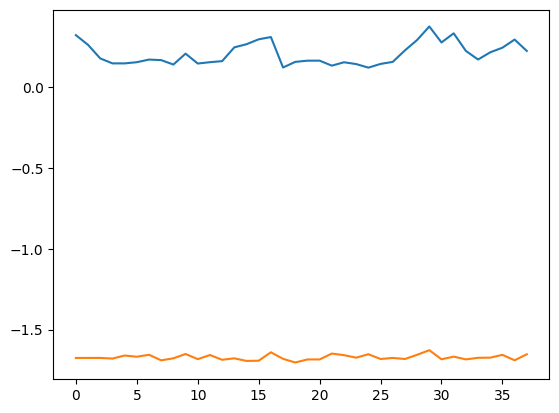

In [ ]:
plt.plot(preds[j][i].numpy());

In [ ]:
for p in p_[-3:]:
    # seg_a, seg_D, seg_cps = list(zip(*[find_segments(pred_a[1:], pred_d, min_size=4, pen=p, kernel="rbf")
                                   # for pred_a, pred_d in zip(preds_a, preds_D)]))
    seg_a, seg_D, seg_cps = list(zip(*[find_segments(pred[:,0], pred[:,1],
                                                 min_size=4, pen=p, kernel="rbf")
                                   for preds_len in preds
                                   for pred in preds_len]))
    seg_cps = [cps[1:-1] for cps in seg_cps]
    TP_rmse_e_nolen, JI_e_nolen = ensemble_changepoint_error_nolen(true_nolen, seg_cps)#_nolen)
    TP_.append(TP_rmse_e_nolen)
    JI_.append(JI_e_nolen)

max JI at pen= 10.0


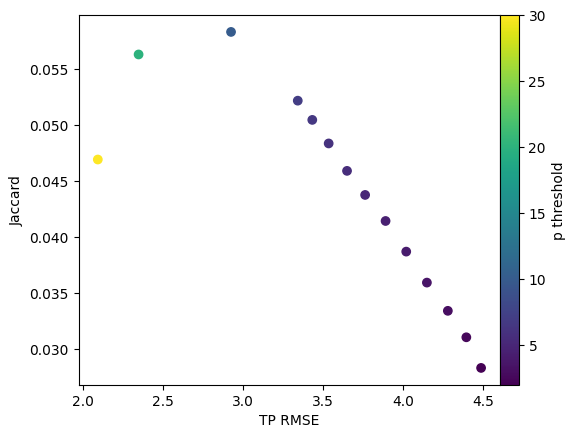

In [ ]:
plt.scatter(TP_, JI_, c=p_);
plt.colorbar(pad=0, label='p threshold');
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');
print('max JI at pen=',p_[np.argmax(JI_)])

max JI at pen= 7.0


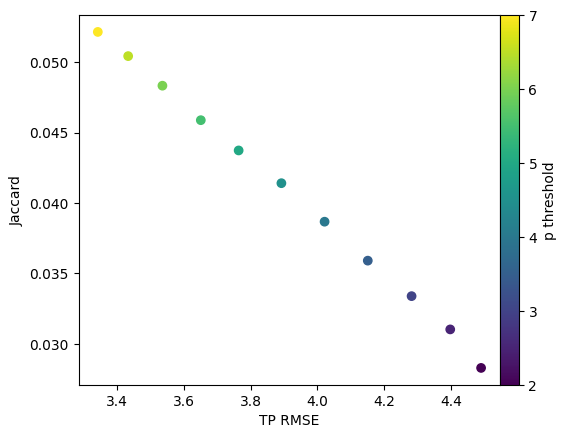

In [ ]:
plt.scatter(TP_, JI_, c=p_);
plt.colorbar(pad=0, label='p threshold');
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');
print('max JI at pen=',p_[np.argmax(JI_)])

max JI at pen= 3.5


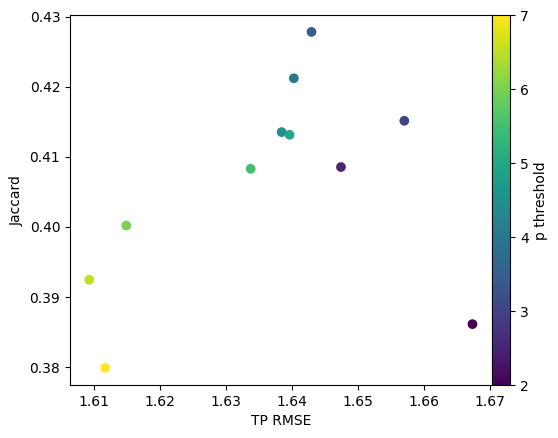

In [ ]:
# plt.scatter(TP_rmse_len, JI_len, marker='s',c='r', );
# plt.axvline(TP_rmse_len, c='r', zorder=-1); plt.axhline(JI_len, c='r', zorder=-1);
plt.scatter(TP_, JI_, c=p_);
plt.colorbar(pad=0, label='p threshold');
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');
print('max JI at pen=',p_[np.argmax(JI_)])

## tune ruptures hyperparameter penalty

In [ ]:
TP_, JI_ = [], []

In [ ]:
#                 D, log10D      small, 
p_ = [3.5, 5, 7, 10, 10, 20, 30, 10,10] 

In [ ]:
p_[-3:]

[20, 30, 7]

In [ ]:
for p in tqdm(p_[-1:]):
    seg_a, seg_D, seg_cps = list(zip(*[find_segments(pred[:,0], np.log10(pred[:,1]),
                                                 min_size=4, pen=p, kernel="rbf")
                                   for preds_l in tqdm(preds_len[::50])
                                   for pred in preds_l]))
    seg_cps = [cps[1:-1] for cps in seg_cps]  # no initial point, no length
    TP_rmse_e_nolen, JI_e_nolen = ensemble_changepoint_error_nolen(true_cps, seg_cps)
    TP_.append(TP_rmse_e_nolen)
    JI_.append(JI_e_nolen)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
TP_, JI_

([3.3140338510593077,
  2.834265243987553,
  2.3519890520769353,
  1.9566464465713564,
  2.0753785962268387,
  1.7224439083795438,
  1.7983753459526297,
  2.6764925864730182,
  2.6698583693849476],
 [0.124764817953403,
  0.1831052148910203,
  0.24495654023513086,
  0.2764664884947399,
  0.2739767577557688,
  0.21649575611778218,
  0.14426612757097837,
  0.0012072434607645875,
  0.00041339396444811904])

max JI at pen= 10


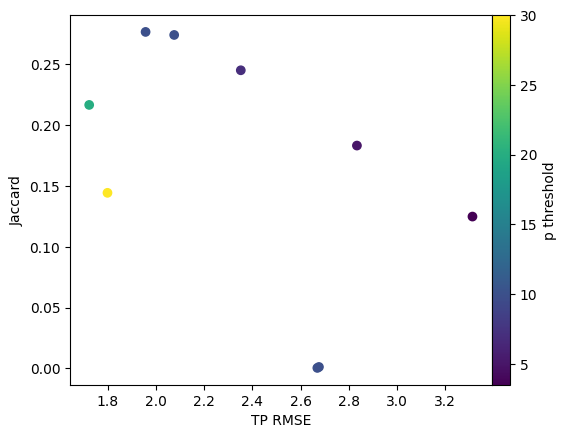

In [ ]:
plt.scatter(TP_, JI_, c=p_);
plt.colorbar(pad=0, label='p threshold');
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');
print('max JI at pen=',p_[np.argmax(JI_)])

In [ ]:
dls_a.dataset.num_trajs_len[:20].sum(), i

(104623, 14948)

In [ ]:
i=-100

In [ ]:
i+=1
seg_a[i], seg_D[i], seg_cps[i], true_cps[i]

([0.57010895, 1.4767543, 0.56730163, 1.4736234, 0.49178904, 1.477856],
 [0.008508126, 0.098832, 0.0044361404, 0.09107372, 0.005396927, 0.09939209],
 array([176, 379, 423, 438, 589]),
 array([ 32,  39,  78, 175, 379, 424, 436, 590]))

In [ ]:
print(np.cumsum([len(p) for p in preds_a[-100:]][::-1])[:14])

[ 6 12 18 24 30 36 42 48 54 60 66 72 78 84]


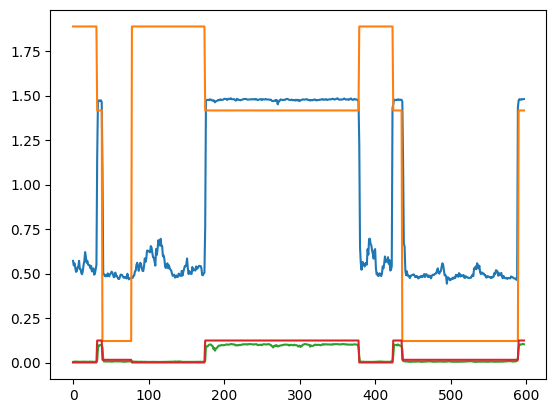

In [ ]:
plt.plot(preds_a[-14][4]);plt.plot(targs_a[-14][4]);
plt.plot(preds_D[-14][4]);plt.plot(targs_D[-14][4]);

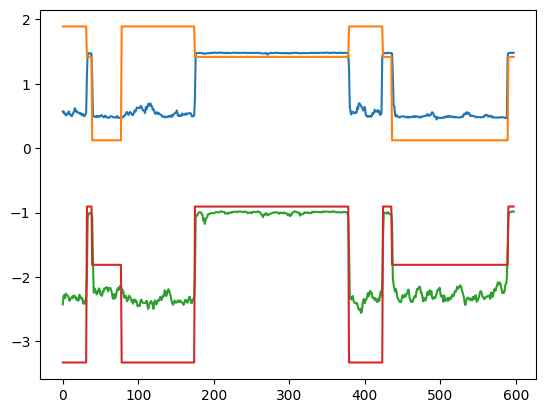

In [ ]:
plt.plot(preds_a[-14][-2]);plt.plot(targs_a[-14][-2]);
plt.plot(np.log10(preds_D[-14][-2]));plt.plot(np.log10(targs_D[-14][-2]));
for cp in seg_cps[-81]: plt.axvline(cp)

In [ ]:
 find_segments(preds_len[-14][-2][:,0], np.log10(preds_len[-14][-2][:,1]), min_size=4, pen=1, kernel="linear")

([0.5378977,
  1.4698706,
  0.52960443,
  1.4767,
  0.5648109,
  1.4763454,
  0.49297017,
  1.477856],
 [-2.3265915,
  -1.0101687,
  -2.321341,
  -1.0061958,
  -2.360126,
  -1.010486,
  -2.27384,
  -1.0041993],
 array([  0,  33,  40, 176, 380, 424, 437, 589, 598]))

In [ ]:
i, seg_a[i], np.log10(seg_D[i]),np.abs(np.diff(seg_a[i])), np.abs(np.diff(np.log10(seg_D[i]))), seg_cps[i], true_cps[i]

(-82,
 [1.0298278, 0.99182874, 1.0659443, 0.9923271, 1.0370153, 0.9664388],
 array([-2.9165206, -2.9220216, -2.9166818, -2.9196303, -2.920865 ,
        -2.9196877], dtype=float32),
 array([0.03799909, 0.07411557, 0.07361722, 0.04468822, 0.07057655],
       dtype=float32),
 array([0.00550103, 0.00533986, 0.00294852, 0.00123477, 0.00117731],
       dtype=float32),
 array([ 48, 255, 281, 412, 473]),
 array([], dtype=int64))

In [ ]:
keep_cps = np.logical_or(np.abs(np.diff(seg_a[-82]))>0.1 ,np.abs(np.diff(np.log10(seg_D[-82])))>0.1)

In [ ]:
seg_cps[-82][keep_cps]

array([], dtype=int64)

In [ ]:
i, seg_a[i], np.log10(seg_D[i]),np.diff(seg_a[i]), np.diff(np.log10(seg_D[i])), seg_cps[i], true_cps[i]

(-87,
 [1.0249277,
  0.38395566,
  1.0205014,
  0.39096618,
  1.0119077,
  0.38589475,
  1.2068073,
  0.37226787,
  1.0330521,
  1.8191975],
 array([-1.7248098, -7.2954745, -1.7013006, -5.6026406, -1.7476501,
        -8.3415575, -1.7401297, -8.670531 , -1.700284 , -1.6685447],
       dtype=float32),
 array([-0.6409721 ,  0.6365457 , -0.6295352 ,  0.6209415 , -0.6260129 ,
         0.8209125 , -0.8345394 ,  0.66078424,  0.78614545], dtype=float32),
 array([-5.570665  ,  5.594174  , -3.90134   ,  3.8549905 , -6.5939074 ,
         6.601428  , -6.930402  ,  6.9702473 ,  0.03173935], dtype=float32),
 array([ 40, 166, 197, 239, 308, 339, 369, 541, 587]),
 array([ 42, 169, 196, 236, 306, 340, 352, 370, 537, 586]))

In [ ]:
keep_cps = np.logical_or(np.abs(np.diff(seg_a[-87]))>0.1 ,np.abs(np.diff(np.log10(seg_D[-87])))>0.1)
keep_cps

/tmp/ipykernel_2427554/4068197850.py:1: RuntimeWarning: invalid value encountered in log10
  keep_cps = np.logical_or(np.abs(np.diff(seg_a[-87]))>0.1 ,np.abs(np.diff(np.log10(seg_D[-87])))>0.1)


array([], dtype=bool)

In [ ]:
i, seg_a[i], np.log10(seg_D[i]),np.diff(seg_a[i]), np.diff(np.log10(seg_D[i])), seg_cps[i], true_cps[i]

(-90,
 [1.5622687, 1.5658506, 1.5614277],
 array([-1.9958258, -1.9901832, -1.9997674], dtype=float32),
 array([ 0.00358188, -0.0044229 ], dtype=float32),
 array([ 0.00564253, -0.00958419], dtype=float32),
 array([47, 87]),
 array([], dtype=int64))

In [ ]:
i, seg_a[i], np.log10(seg_D[i]),np.diff(seg_a[i]), np.diff(np.log10(seg_D[i])), seg_cps[i], true_cps[i]

(-91,
 [1.5343105, 1.5326157, 1.5348954],
 array([-1.4671963, -1.6731782, -1.4491309], dtype=float32),
 array([-0.0016948 ,  0.00227976], dtype=float32),
 array([-0.20598185,  0.2240473 ], dtype=float32),
 array([131, 198]),
 array([132, 197, 240, 303, 322, 339, 435, 463, 474, 506, 526]))

In [ ]:
keep_cps = np.logical_or(np.abs(np.diff(seg_a[-91]))>0.1 ,np.abs(np.diff(seg_D[-91]))>0.1)
keep_cps

array([False])

In [ ]:
np.diff(seg_D[-91])

array([0.00095093], dtype=float32)

ValueError: operands could not be broadcast together with shape (1,) (3,)

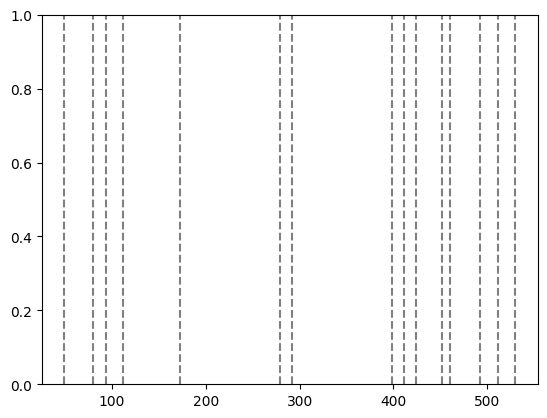

In [ ]:
# cps
for cp in cps[1:]: plt.axvline(cp-1, ls='--', c='gray'); # minus one to start at 0
# alpha
# plt.plot(targs_a[i], label='target'); plt.plot(pred_a[i], label='pred');
plt.plot(np.array(a_seg[i]).repeat(seg_cps[i]), label='seg pred');
plt.ylim(-0.11, 2.11);
plt.legend();

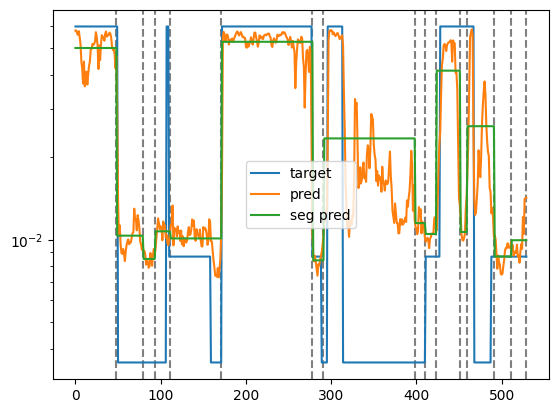

In [ ]:
# cps
for cp in cps_D[1:]: plt.axvline(cp-1, ls='--', c='gray');
# D
plt.plot(targs_D[i][0], label='target'); plt.plot(pred_d, label='pred');
plt.yscale('log');
plt.plot(np.array(d_seg).repeat(cps_D[1:] - cps_D[:-1]), label='seg pred');
plt.legend();
#plt.xlim(390,400);

In [ ]:
len(preds_a[i][0])

598

In [ ]:
print(cps[1:])
print(true_cps_nolen[i][0])

[ 50  81  95 113 173 280 293 400 412 425 453 461 493 513 531]
[ 89  94 135 144 174 208 306 320 342 442 476 514]


In [ ]:
# TODO analyze raw numbers of TP, TN, FP, FN

In [ ]:
# TODO analyze per length

# Diffusive states

# Global metric

We want a scalar to quantify the overall performance of a model.
We devise a weighted sum of the challenge metrics to reach zero error or accuracy one.

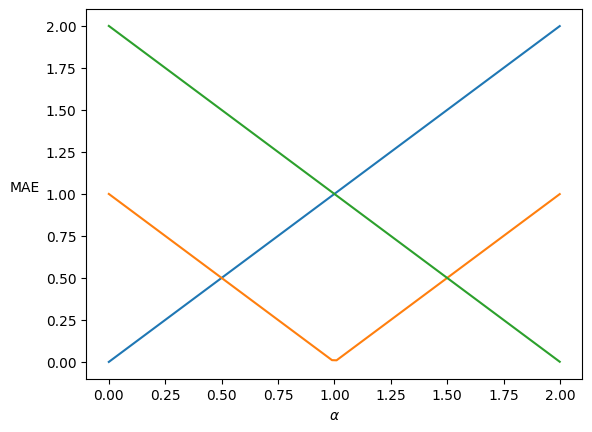

In [ ]:
range_alpha = np.linspace(*bound_alpha, 100)
mae_alpha = np.abs(range_alpha-0)
plt.plot(range_alpha, mae_alpha);
mae_alpha = np.abs(range_alpha-1)
plt.plot(range_alpha, mae_alpha);
mae_alpha = np.abs(range_alpha-2)
plt.plot(range_alpha, mae_alpha);
plt.xlabel(r'$\alpha$'); plt.ylabel('MAE', rotation=0, ha='right');

See the range of MSLE and ALE in the notebook metric_D_MSLE_vs_ALE.

 | Magnitude | Range   | Metric | metric range     | random guess | good  | normalizing factor |
 |-----------|---------|--------|------------------|--------------|-------|--------------------|
 | $\alpha$  | 0, 2    | MAE    | 0, 2             |         0.5  |  0.1  | 0.4                |
 | log D     | -12, 6  | MSLE   | 0, 1000          |         4    |  0.1  | 3.9                |
 | states    | 1, 4    | F1     | 1, 0             |         1/4 |  0.95 | 0.7                |
 | CP        | 1, T-1    | JSC    | 1, 0             |           1/(T-2)   |       |                    |
 | TP CP        | 1, T-1    | RMSE   |                  |              |       |                    |

In [ ]:
# MAE of random guess for alpha
rand_a = np.abs(np.random.rand(10000)*2-1).mean();
rand_a

0.4973312540506182

In [ ]:
good_a = 0.1
# normalizing factor for alpha is
norm_a = np.abs(0.5-good_a)

In [ ]:
good_D = 0.1
# LMSE of random guess for D
rand_D = np.mean((np.log10(1e-1+1) - np.log10(10**(np.random.rand(10000)*18-12)+1))**2); rand_D

4.007672217147329

In [ ]:
# normalizing factor for D is
norm_D = np.abs(4-good_D)

In [ ]:
# random guess for diffusion state gives F1 1/4 as there are 4 possible states
rand_states = 0.25 #np.random.randint(0, high=4, size=len(seg_a))
good_states = 0.95

In [ ]:
# normalizing factor for F1 Classification is
norm_states = good_states-rand_states

In [ ]:
# random guess for CP
rand_cp = np.sort(np.random.choice(np.arange(1,T-1), np.random.randint(low=0,high=10), replace = False))

In [ ]:
# normalizing factor for CP is
norm_cp

In [ ]:
rand_a/norm_a, rand_D/norm_D, rand_states/norm_states, rand_cp/norm_cp

(1.2392949295472369, 0.9777654727745625)

In [ ]:
# global error metric
sum([mae_a-rand_a/norm_a, rand_D/norm_D, (f1_states-rand_states)/norm_states, rand_cp/norm_cp])/4

(1.2392949295472369, 0.9777654727745625)

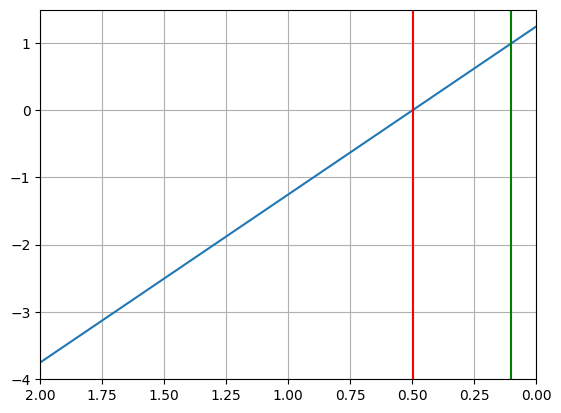

In [ ]:
mae_a = np.linspace(0,2)
norm_mae_a = (rand_a-mae_a)/norm_a
plt.plot(mae_a, norm_mae_a); plt.xlim(2,0)
plt.axvline(rand_a, c='r');
plt.axvline(good_a, c='g');
plt.grid();

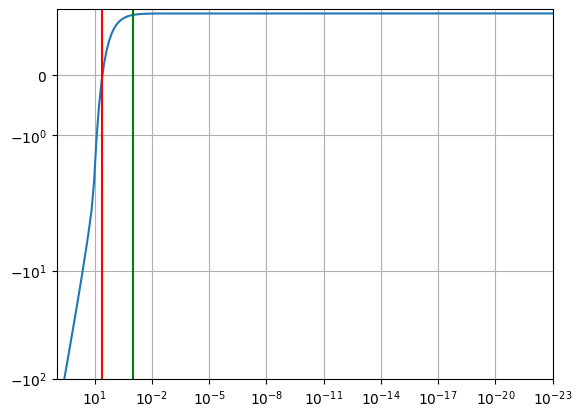

In [ ]:
lmse_D = np.geomspace(1e-23,1e3,200)
norm_lmse_D = (rand_D-lmse_D)/norm_D
plt.plot(lmse_D, norm_lmse_D); plt.xlim(1000,1e-23)
plt.xscale('log'); plt.yscale('symlog'); plt.ylim(-100, 1.1)
plt.axvline(rand_D, c='r');
plt.axvline(good_D, c='g');
plt.grid();

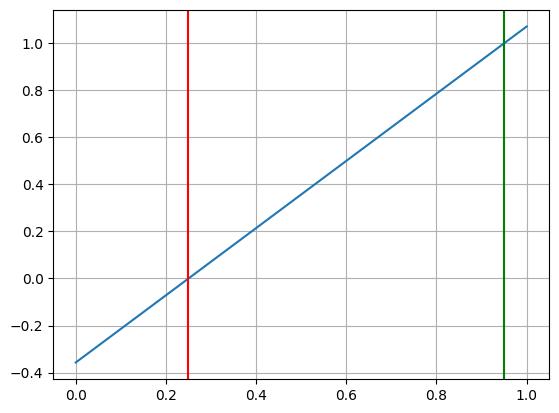

In [ ]:
f1_states = np.linspace(0,1)
norm_f1_states = (f1_states-rand_states)/norm_states
plt.plot(f1_states, norm_f1_states);
plt.axvline(rand_states, c='r');
plt.axvline(good_states, c='g');
plt.grid();

In [ ]:
GT

array([[ 13,  47, 110, ..., 181, 184, 186],
       [ 17,  35,  40, ..., 159, 191, 192],
       [ 44,  70,  83, ..., 184, 187, 191],
       ...,
       [ 27,  47,  68, ..., 178, 185, 191],
       [ 47,  71,  73, ..., 186, 190, 194],
       [  1,   4,  23, ..., 125, 142, 144]])

In [ ]:
rand_cp

array([[  7,  13,  29, ..., 164, 171, 182],
       [  6,  11,  41, ..., 166, 178, 189],
       [ 64,  81,  93, ..., 162, 173, 190],
       ...,
       [ 44,  47,  50, ..., 157, 194, 196],
       [  8,  13,  45, ..., 159, 165, 197],
       [  7,  19,  22, ..., 105, 124, 181]])

In [ ]:
rand_cp.shape

(400, 10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


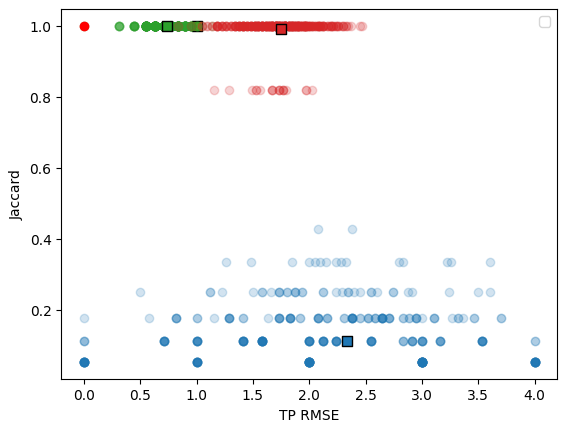

In [ ]:
T = 200; ngts = 10; npreds = 8
N=400
GT = np.sort(np.array([np.random.choice(np.arange(1,T), ngts, replace = False) 
                       for i in range(N)])
             ,axis=-1)

# random guess
rand_cp_ = np.sort(np.array([np.random.choice(np.arange(1,T), ngts, replace = False) 
                       for i in range(N)])
             ,axis=-1)
rand_cp3 = GT + np.random.randint(-3, 3, size=(N,ngts))
rand_cp1 = GT + np.random.randint(-1, 1, size=(N,ngts))
rand_cpp1 = GT + 1
for i,rand_cp in enumerate([rand_cp_, rand_cpp1, rand_cp1, rand_cp3]):
    RMSE, JI = zip(*[single_changepoint_error(GT[i], rand_cp[i], threshold = 5)
                     for i in range(N)])
    
    rmse_e, ji_e = ensemble_changepoint_error(GT, rand_cp, threshold = 5)

    plt.scatter(RMSE, JI, c = f'C{i}', alpha = alpha)
    plt.scatter(rmse_e, ji_e, c = f'C{i}', s = 50, marker = 's', edgecolors = 'k')



RMSE_perfect, JI_perfect = single_changepoint_error(GT[0], GT[0], threshold = 5)
plt.scatter(RMSE_perfect, JI_perfect, c = 'red',)
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard')
plt.legend();#loc = (0.91,0.4));

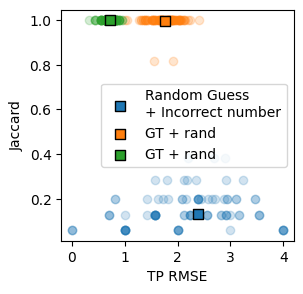

In [ ]:
labels = ['Random Guess\n+ Incorrect number', r'GT + rand ', r'GT + rand ']

fig, ax = plt.subplots(figsize = (3,3)); alpha = 0.2
T = 200; ngts = 10; npreds = 8

for case, (label, color) in enumerate(zip(labels, ['C0', 'C1', 'C2'])):
    rmse, ji = [], [];    GT, preds = [], []
    for _ in range(100):
        # take ngts changepoints
        GT.append(np.sort(np.random.choice(np.arange(1,T), ngts, replace = False)))
        if case == 0:
            # random guess
            preds.append(np.sort(np.random.choice(np.arange(1,T), npreds, replace = False)))                  
        elif case == 1:
            # GT + rand 3
            preds.append(GT[-1] + np.random.randint(-3, 3, ngts))
        elif case == 2:
            # GT + rand 1
            preds.append(GT[-1] + np.random.randint(-1, 1, ngts))

        RMSE, JI = single_changepoint_error(GT[-1], preds[-1], threshold = 5)     
        
        rmse.append(RMSE)
        ji.append(JI)

    rmse_e, ji_e = ensemble_changepoint_error(GT, preds, threshold = 5)
    
    ax.scatter(rmse, ji, c = color, alpha = alpha)
    ax.scatter(rmse_e, ji_e, c = color, label = label, s = 50, marker = 's', edgecolors = 'k')
plt.setp(ax, xlabel = 'TP RMSE', ylabel = 'Jaccard')
ax.legend();#loc = (0.91,0.4));

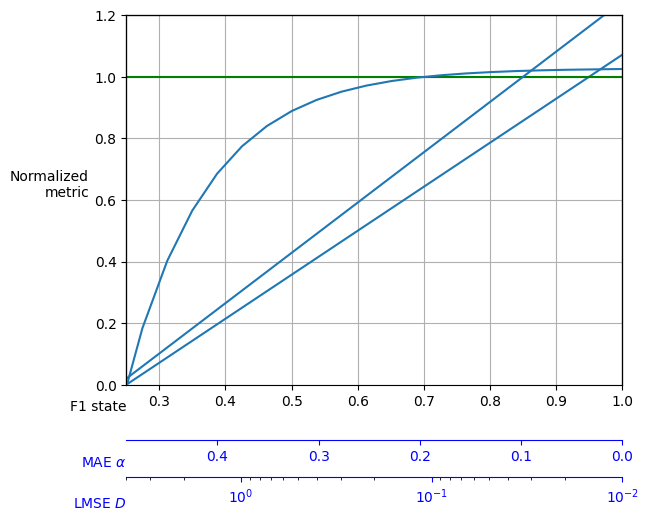

In [ ]:
plt.plot(f1_states, norm_f1_states);
plt.xlim(0.25,1); plt.xlabel(r'F1 state', x=0,va='bottom', ha='right')
plt.ylim(0,1.2); plt.ylabel('Normalized\nmetric', rotation=0, ha='right')
plt.axhline(1, c='g')
plt.grid();
ax = plt.gca()
ax_a = ax.twiny()
ax_a.plot(mae_a, norm_mae_a);
ax_a.xaxis.set_ticks_position('bottom')
ax_a.xaxis.set_label_position('bottom')
ax_a.set_xlim(0.49,0); ax_a.set_xlabel(r'MAE $\alpha$', x=0,va='bottom', ha='right')
ax_a.spines['bottom'].set_position(('axes', -0.15))
ax_a.spines['bottom'].set_color('blue')
ax_a.tick_params(axis='x', colors='blue')
ax_a.xaxis.label.set_color('blue')

ax_D = ax.twiny()
ax_D.plot(lmse_D, norm_lmse_D);
ax_D.set_xlim(4,1e-2)
ax_D.xaxis.set_ticks_position('bottom')
ax_D.xaxis.set_label_position('bottom')
ax_D.set_xscale('log');ax_D.set_xlabel(r'LMSE $D$', x=0,va='bottom', ha='right')
ax_D.spines['bottom'].set_position(('axes', -0.25))
ax_D.spines['bottom'].set_color('blue')
ax_D.tick_params(axis='x', colors='blue')
ax_D.xaxis.label.set_color('blue')

 
B: sum of errors: alpha MAE + D LMSE + 1-F1 state + RMSE CP

sum of accuracies: 1-MAE + 

In [ ]:
def sum_errors(mae_a, msle_D, F1_state, rmse_cp, JI):
    sum_=0
    for a in [mae_a, msle_D, F1_state, rmse_cp, JI]:
        if a is not None: sum_+=a
    return sum_
sum_errors(1, *[None]*4)

1

In [ ]:
# sum of errors
def sum_errors(mae_a=None, msle_D=None, f1_states=None, rmse_cp=None, JI=None):
    sume, n =  0., 0
    rand_a, norm_a = 0.5, 0.4
    rand_D, norm_D = 4, 3.9
    rand_states, norm_states = 0.25, 0.7
    if mae_a    is not None:
        sume +=  (rand_a-mae_a) /norm_a
        n+=1
    if msle_D   is not None:
        sume += (rand_D-msle_D)/norm_D
        n+=1
    if f1_states is not None:
        sume += (f1_states-rand_states)/norm_states
        n+=1
    if rmse_cp  is not None and JI  is not None:
        sume += (4-rmse_cp/3.9 + JI)/2
        n+=1
    return sume/n

In [ ]:
(4-TP_rmse_e)/3.9, JI_e

(0.6372460591831023, 0.4572045870034901)

In [ ]:
sum_errors(m_a, m_d, m_s, TP_rmse_e, JI_e)

0.8546428134262071

In [ ]:
sum_errors(msle_D=m_d)#, m_d, m_s, TP_rmse_e, JI_e)

1.0255081639180161

In [ ]:
sum_errors(mae_a=m_a,), sum_errors(f1_states=m_s,)

(0.39834081919656855, -0.0396825396825397)

In [ ]:
sum_errors(mae_a=m_a,msle_D=m_d)#, m_d, m_s, TP_rmse_e, JI_e)

0.7119244915572923

In [ ]:
sum_errors(mae_a=m_a,msle_D=m_d,f1_states=m_s,)# TP_rmse_e, JI_e)

0.4613888144773483

In [ ]:
sum_errors(mae_a_mean, msle_D_mean, F1_state, TP_rmse_e, JI_e)

In [ ]:
sum_errors(mae_a_mean, male_D_mean, F1_state, TP_rmse_e, JI_e)

In [ ]:
# save performance in csv
# timestamp, global_metric, model_name, other metrics

In [ ]:
def plot_global_metric():
    """Plot showing performance progress over time."""
    # load csv of performance
    timestamp, global_metric, model_name,
    plt.plot(timestamp, global_metric, 'o-')
    ax=plt.gca()
    for x,y,s in zip(timestamp, global_metric, model_name):
        ax.annotate(s, xy=(x, y), xycoords='data',
                    xytext=(-70, 30), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))